In [1]:
!pip install tslearn

In [2]:
!pip install seaborn

In [3]:
!pip install statsmodels

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tslearn.metrics import dtw
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.tsaplots import month_plot
from tslearn.metrics import dtw_path
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import os
import json

In [2]:
df = pd.read_csv('project_dataset.csv', parse_dates=['Date'])
df.head()

Date  IsHoliday  Dept  Weekly_Sales  Temperature  Fuel_Price  \
0 2010-02-05          0   1.0      24924.50        42.31       2.572   
1 2010-02-05          0  26.0      11737.12        42.31       2.572   
2 2010-02-05          0  17.0      13223.76        42.31       2.572   
3 2010-02-05          0  45.0         37.44        42.31       2.572   
4 2010-02-05          0  28.0       1085.29        42.31       2.572   

          CPI  Unemployment  
0  211.096358         8.106  
1  211.096358         8.106  
2  211.096358         8.106  
3  211.096358         8.106  
4  211.096358         8.106

In [3]:
df.dtypes

Date            datetime64[ns]
IsHoliday                int64
Dept                   float64
Weekly_Sales           float64
Temperature            float64
Fuel_Price             float64
CPI                    float64
Unemployment           float64
dtype: object

In [4]:
df.shape

(10244, 8)

In [5]:
df = df[df['Dept'] == 8].copy()
df.drop(columns=['Dept'], inplace=True)
df.shape

(143, 7)

From the columns, we have 6 features that we we can work with, 

- IsHoliday -Binary- deterimne if this week was a holiday or not.

- Weekly_Sales -Numeric- This is the weekly sales of teh data. -Target Value- 

- Temperature -Numeric-            

- Fuel_Price -Numeric-  Cost of fuel in the region

- CPI -Numeric-          

- Unemployment -Numeric- 

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143 entries, 31 to 10183
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          143 non-null    datetime64[ns]
 1   IsHoliday     143 non-null    int64         
 2   Weekly_Sales  143 non-null    float64       
 3   Temperature   143 non-null    float64       
 4   Fuel_Price    143 non-null    float64       
 5   CPI           143 non-null    float64       
 6   Unemployment  143 non-null    float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 8.9 KB


In [7]:
df.describe()

IsHoliday  Weekly_Sales  Temperature  Fuel_Price         CPI  \
count  143.000000    143.000000   143.000000  143.000000  143.000000   
mean     0.069930  35718.257622    68.306783    3.219699  215.996892   
std      0.255926   2490.769188    14.250486    0.427313    4.350890   
min      0.000000  31061.210000    35.400000    2.514000  210.337426   
25%      0.000000  34010.225000    58.265000    2.764500  211.549277   
50%      0.000000  35356.120000    69.640000    3.290000  215.459905   
75%      0.000000  37262.380000    80.485000    3.594000  220.531330   
max      1.000000  42663.750000    91.650000    3.907000  223.444251   

       Unemployment  
count    143.000000  
mean       7.610420  
std        0.383749  
min        6.573000  
25%        7.348000  
50%        7.787000  
75%        7.838000  
max        8.106000

In [8]:
df.isnull().sum()

Date            0
IsHoliday       0
Weekly_Sales    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

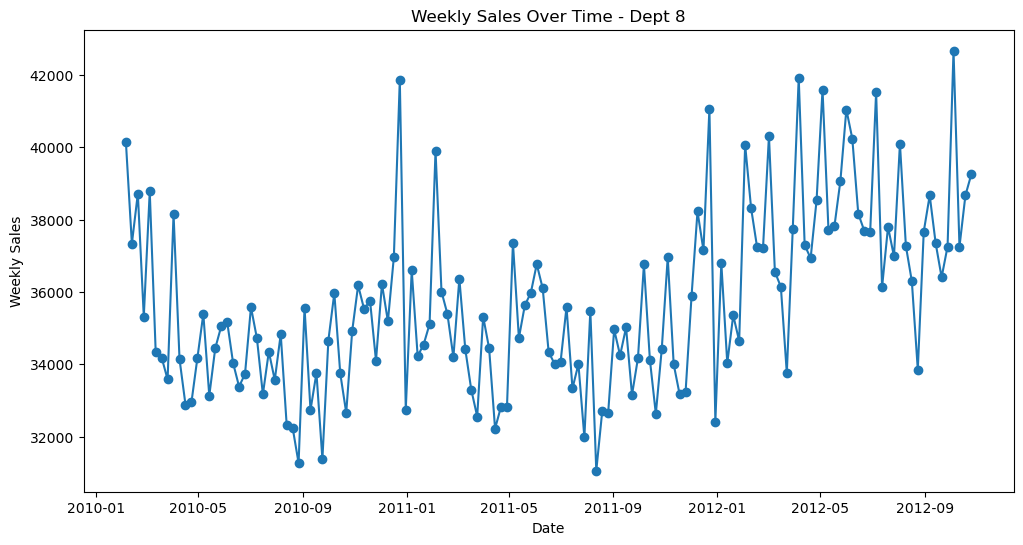

In [9]:
plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['Weekly_Sales'], marker='o')
plt.title('Weekly Sales Over Time - Dept 8')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
#plt.grid(True)
plt.show()

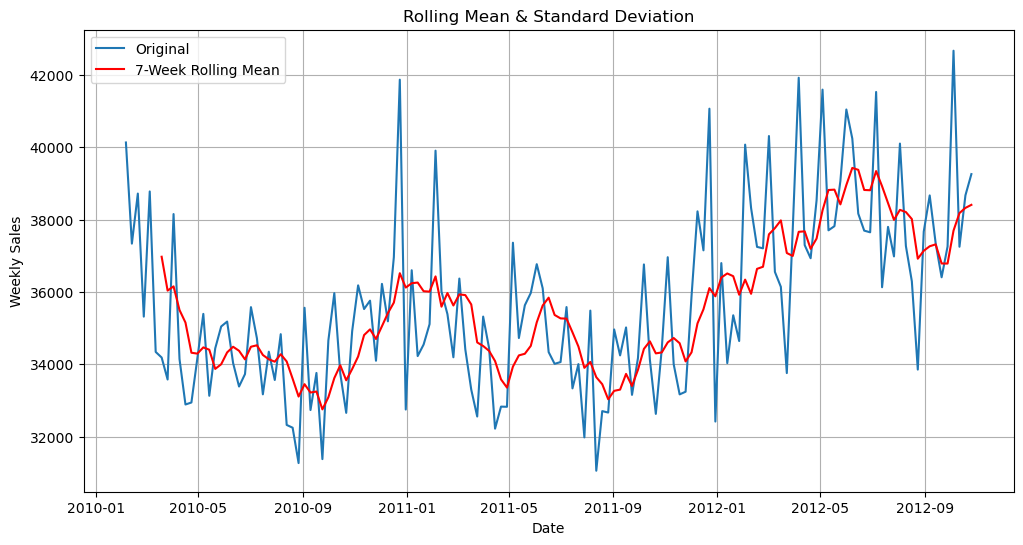

In [10]:
window = 7 

df_sorted = df.sort_values('Date').set_index('Date')

rolling_mean = df_sorted['Weekly_Sales'].rolling(window=window).mean()
rolling_std = df_sorted['Weekly_Sales'].rolling(window=window).std()

plt.figure(figsize=(12,6))
plt.plot(df_sorted['Weekly_Sales'], label='Original')
plt.plot(rolling_mean, color='red', label=f'{window}-Week Rolling Mean')
#plt.plot(rolling_std, color='green', label=f'{window}-Week Rolling Std')
plt.title('Rolling Mean & Standard Deviation')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True)
plt.show()


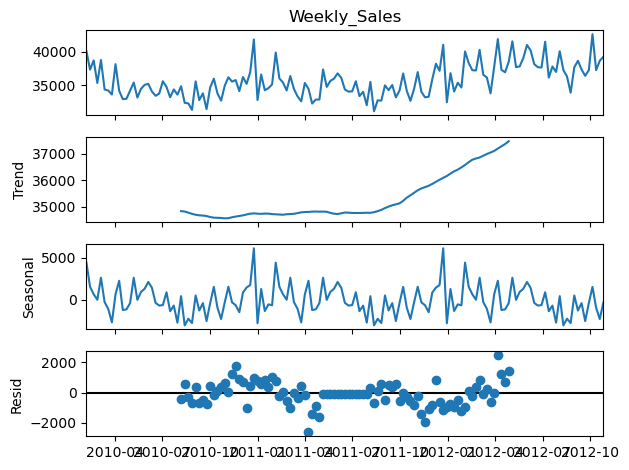

In [11]:
result = seasonal_decompose(df_sorted['Weekly_Sales'], model='additive', period=52)
result.plot()
plt.show()

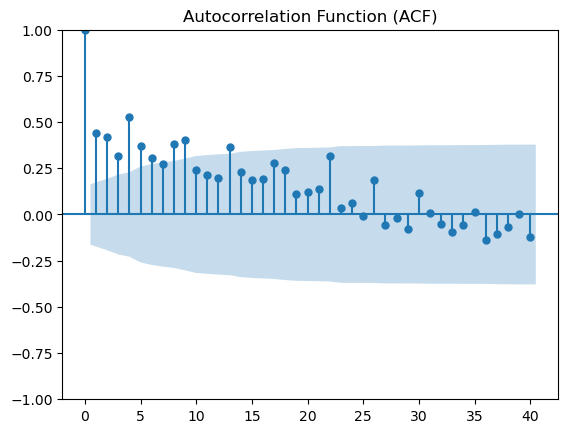

In [12]:
plot_acf(df_sorted['Weekly_Sales'], lags=40)
plt.title('Autocorrelation Function (ACF)')
plt.show()

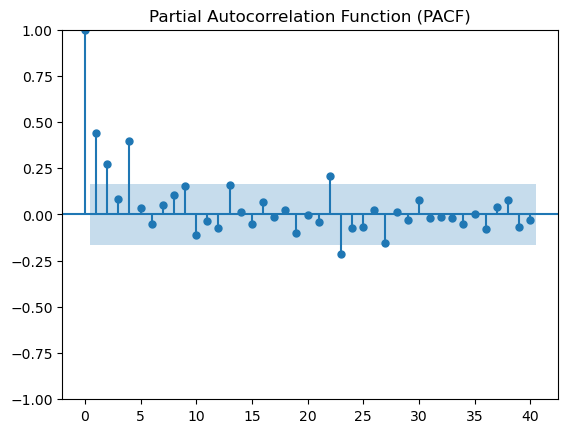

In [13]:
plot_pacf(df_sorted['Weekly_Sales'], lags=40, method='ywm')
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()


C:\Users\marha\AppData\Local\Temp\ipykernel_7724\1869793303.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.drop(columns=['IsHoliday']).corr()


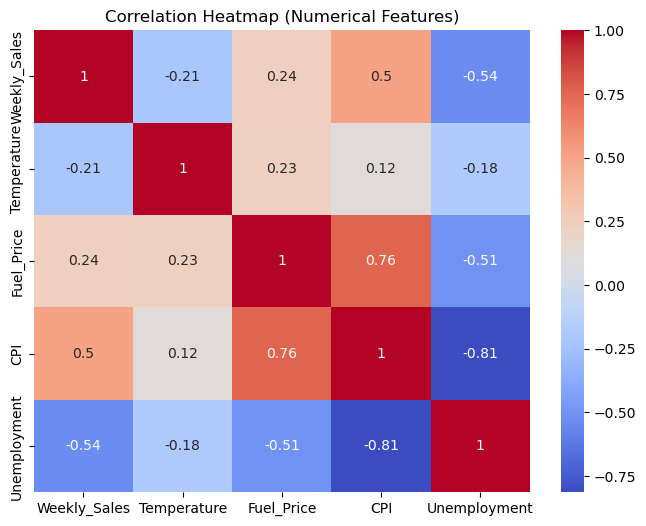

In [14]:
corr = df.drop(columns=['IsHoliday']).corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap (Numerical Features)')
plt.show()

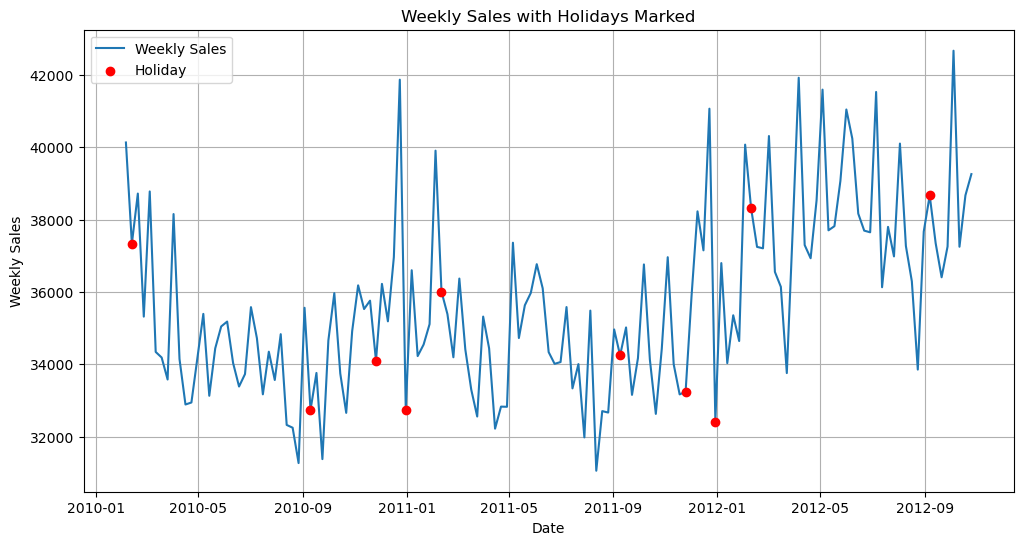

In [15]:
plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['Weekly_Sales'], label='Weekly Sales')
plt.scatter(df[df['IsHoliday'] == True]['Date'], df[df['IsHoliday'] == True]['Weekly_Sales'], color='red', label='Holiday', zorder=5)
plt.title('Weekly Sales with Holidays Marked')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.grid(True)
plt.show()

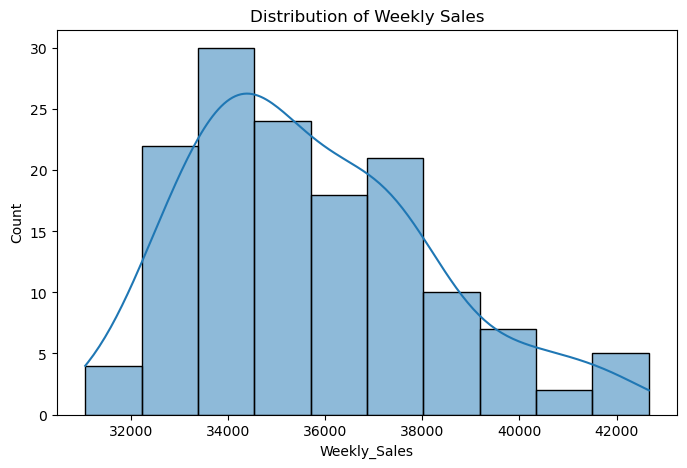

In [16]:
plt.figure(figsize=(8,5))
sns.histplot(df['Weekly_Sales'], kde=True)
plt.title('Distribution of Weekly Sales')
plt.show()


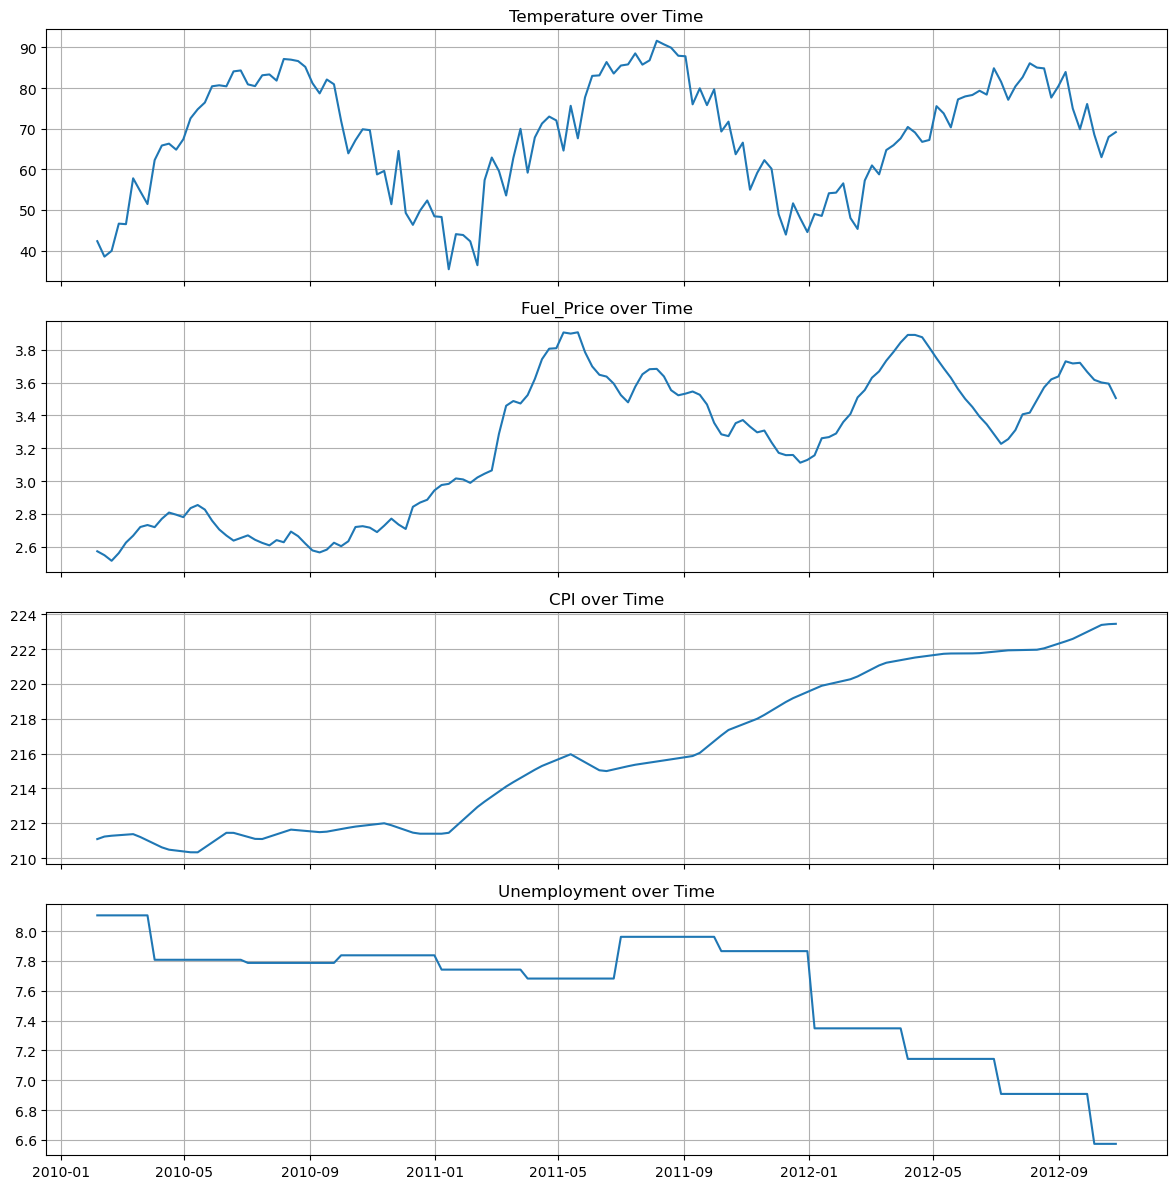

In [17]:
features = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']

fig, axs = plt.subplots(len(features), 1, figsize=(12, 12), sharex=True)

for i, feature in enumerate(features):
    axs[i].plot(df['Date'], df[feature])
    axs[i].set_title(f'{feature} over Time')
    axs[i].grid(True)

plt.tight_layout()
plt.show()


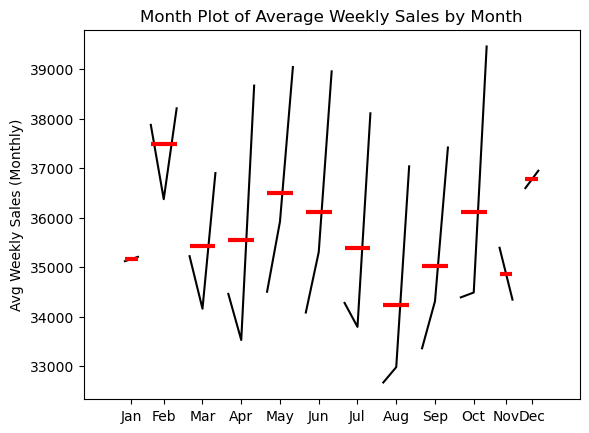

In [18]:

# First, set Date as index if not already
df_plot = df.set_index('Date')

# Monthly aggregation (mean sales per month)
monthly_sales = df_plot['Weekly_Sales'].resample('M').mean()

# Generate month plot
month_plot(monthly_sales, ylabel='Avg Weekly Sales (Monthly)')
plt.title("Month Plot of Average Weekly Sales by Month")
plt.show()

In [19]:
target_series = df_sorted['Weekly_Sales'].values

features = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']

for feature in features:
    feature_series = df_sorted[feature].values
    distance = dtw(target_series, feature_series)
    print(f'DTW distance between Weekly_Sales and {feature}: {distance:.2f}')

DTW distance between Weekly_Sales and Temperature: 427345.95
DTW distance between Weekly_Sales and Fuel_Price: 428119.76
DTW distance between Weekly_Sales and CPI: 425579.74
DTW distance between Weekly_Sales and Unemployment: 428067.64


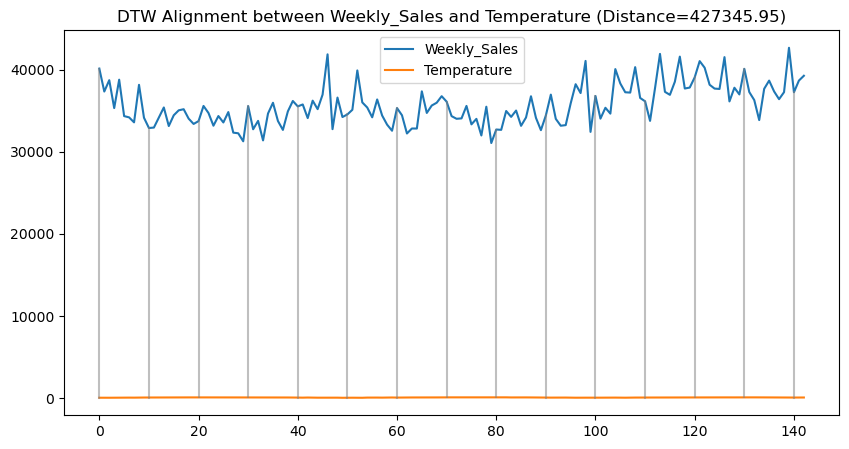

In [20]:
feature = 'Temperature'
feature_series = df_sorted[feature].values

path, dist = dtw_path(target_series, feature_series)

plt.figure(figsize=(10,5))
plt.plot(target_series, label='Weekly_Sales')
plt.plot(feature_series, label=feature)
for (map_x, map_y) in path[::10]:  # plot fewer lines for clarity
    plt.plot([map_x, map_y], [target_series[map_x], feature_series[map_y]], color='gray', alpha=0.5)
plt.legend()
plt.title(f'DTW Alignment between Weekly_Sales and {feature} (Distance={dist:.2f})')
plt.show()


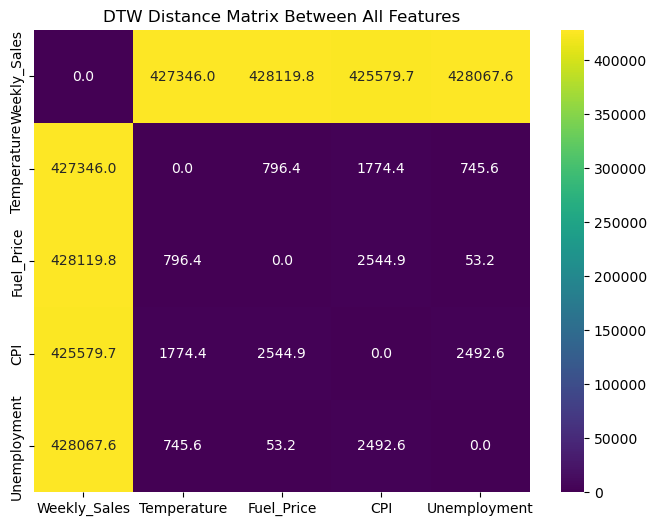

In [21]:
all_features = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
dtw_matrix = pd.DataFrame(index=all_features, columns=all_features)

for f1 in all_features:
    for f2 in all_features:
        series1 = df_sorted[f1].values
        series2 = df_sorted[f2].values
        dist = dtw(series1, series2)
        dtw_matrix.loc[f1, f2] = dist

# Convert to float for plotting
dtw_matrix = dtw_matrix.astype(float)

plt.figure(figsize=(8,6))
sns.heatmap(dtw_matrix, annot=True, fmt=".1f", cmap='viridis')
plt.title('DTW Distance Matrix Between All Features')
plt.show()

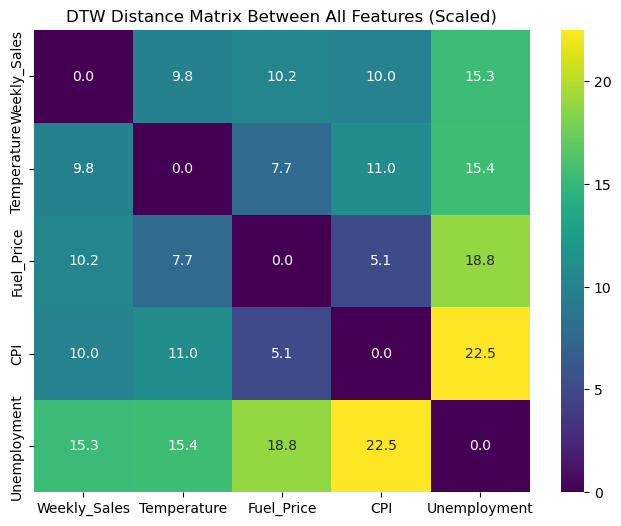

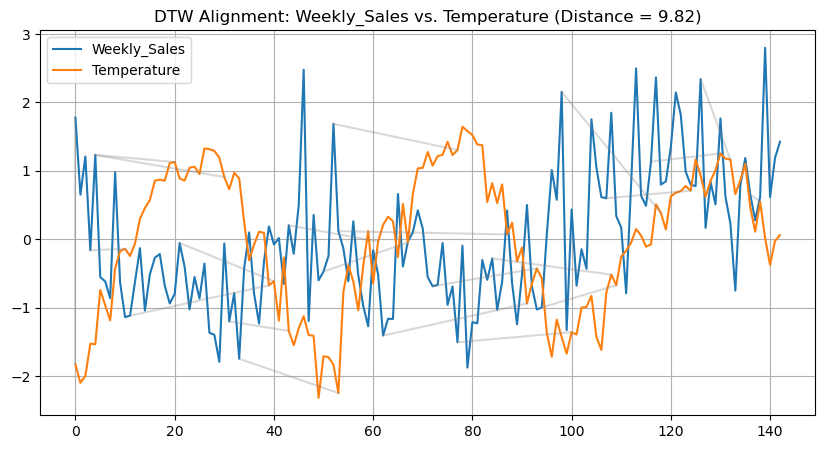

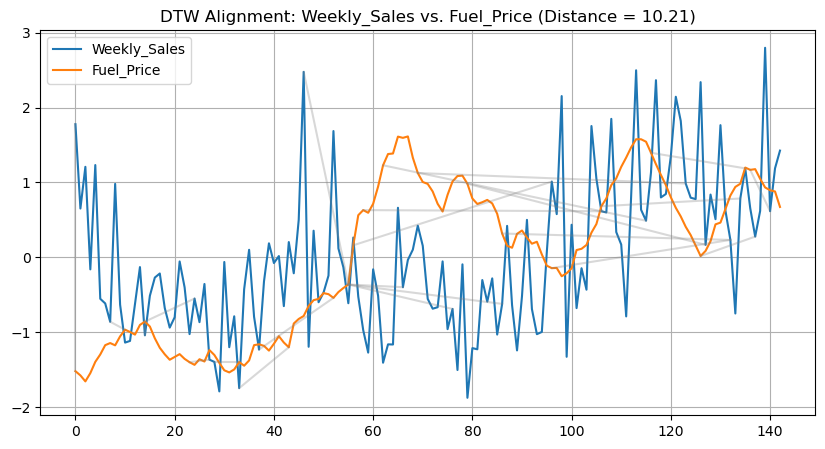

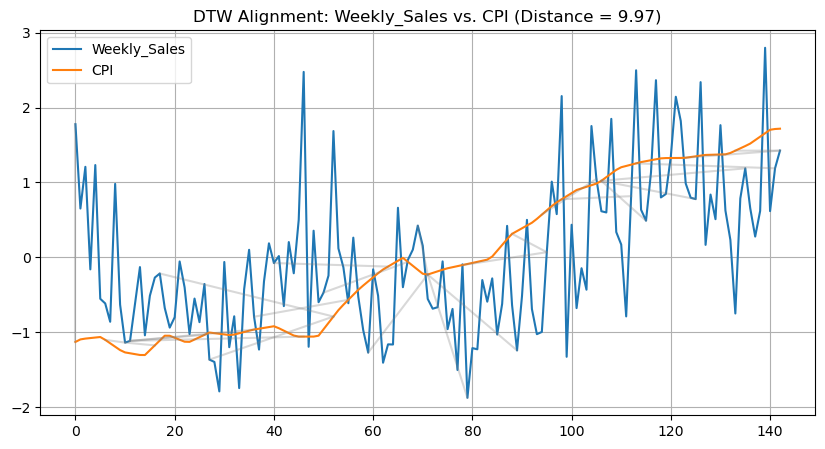

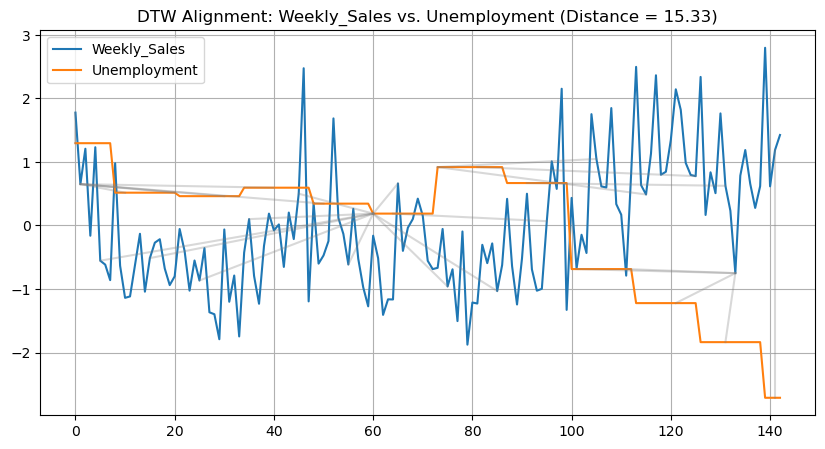

In [22]:
# ================================
# 1️⃣ Scale Numerical Features
# ================================
features = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_sorted[features])
scaled_df = pd.DataFrame(scaled_data, columns=features, index=df_sorted.index)

# ================================
# 2️⃣ DTW Distance Matrix Between All Features (Heatmap)
# ================================
dtw_matrix = pd.DataFrame(index=features, columns=features)

for f1 in features:
    for f2 in features:
        series1 = scaled_df[f1].values
        series2 = scaled_df[f2].values
        dist = dtw(series1, series2)
        dtw_matrix.loc[f1, f2] = dist

dtw_matrix = dtw_matrix.astype(float)

plt.figure(figsize=(8,6))
sns.heatmap(dtw_matrix, annot=True, fmt=".1f", cmap='viridis')
plt.title('DTW Distance Matrix Between All Features (Scaled)')
plt.show()

# ================================
# 3️⃣ DTW Alignment Visualizations: Weekly_Sales vs. Each Feature
# ================================
target_series = scaled_df['Weekly_Sales'].values
other_features = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']

for feature in other_features:
    feature_series = scaled_df[feature].values
    path, dist = dtw_path(target_series, feature_series)

    plt.figure(figsize=(10,5))
    plt.plot(target_series, label='Weekly_Sales')
    plt.plot(feature_series, label=feature)
    
    for (map_x, map_y) in path[::10]:  # skip some for clarity
        plt.plot([map_x, map_y], [target_series[map_x], feature_series[map_y]], color='gray', alpha=0.3)
        
    plt.legend()
    plt.title(f'DTW Alignment: Weekly_Sales vs. {feature} (Distance = {dist:.2f})')
    plt.grid(True)
    plt.show()


In [23]:
scaled_df.head()

Weekly_Sales  Temperature  Fuel_Price       CPI  Unemployment
Date                                                                     
2010-02-05      1.777064    -1.830686   -1.521079 -1.130288      1.295958
2010-02-12      0.651307    -2.098280   -1.577441 -1.096657      1.295958
2010-02-19      1.208416    -1.998285   -1.657288 -1.085823      1.295958
2010-02-26     -0.161181    -1.526473   -1.546911 -1.078788      1.295958
2010-03-05      1.231981    -1.535627   -1.396612 -1.071754      1.295958

In [24]:
features = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_sorted[features])
scaled_df = pd.DataFrame(scaled_data, columns=features, index=df_sorted.index)

scaled_df.head()


Weekly_Sales  Temperature  Fuel_Price       CPI  Unemployment
Date                                                                     
2010-02-05      1.777064    -1.830686   -1.521079 -1.130288      1.295958
2010-02-12      0.651307    -2.098280   -1.577441 -1.096657      1.295958
2010-02-19      1.208416    -1.998285   -1.657288 -1.085823      1.295958
2010-02-26     -0.161181    -1.526473   -1.546911 -1.078788      1.295958
2010-03-05      1.231981    -1.535627   -1.396612 -1.071754      1.295958

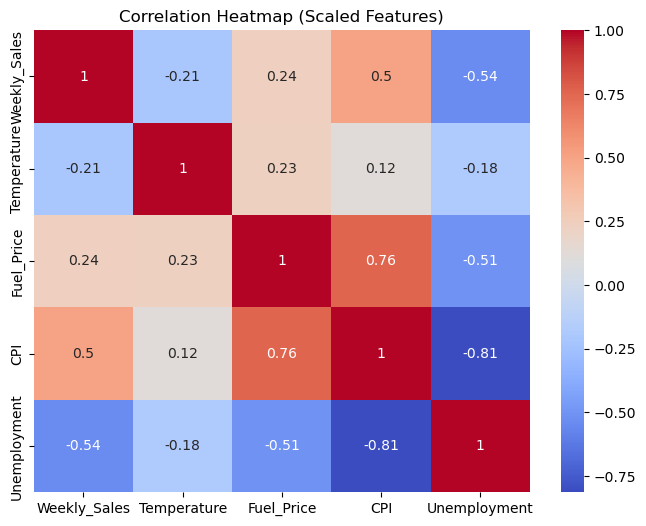

In [25]:
corr = scaled_df.corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap (Scaled Features)')
plt.show()


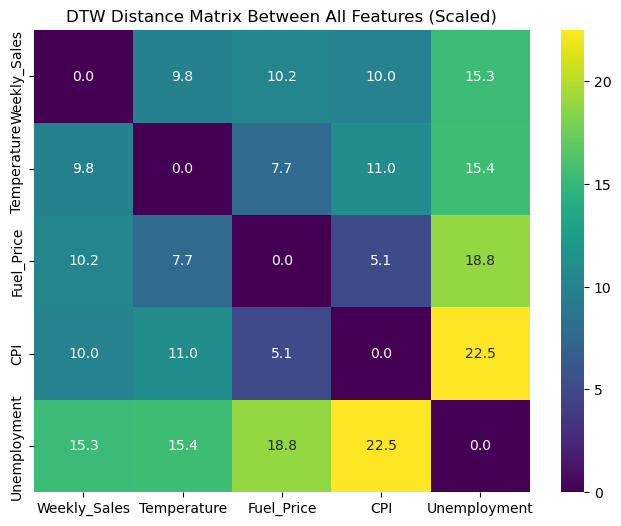

In [26]:

dtw_matrix = pd.DataFrame(index=features, columns=features)

for f1 in features:
    for f2 in features:
        series1 = scaled_df[f1].values
        series2 = scaled_df[f2].values
        dist = dtw(series1, series2)
        dtw_matrix.loc[f1, f2] = dist

dtw_matrix = dtw_matrix.astype(float)

plt.figure(figsize=(8,6))
sns.heatmap(dtw_matrix, annot=True, fmt=".1f", cmap='viridis')
plt.title('DTW Distance Matrix Between All Features (Scaled)')
plt.show()


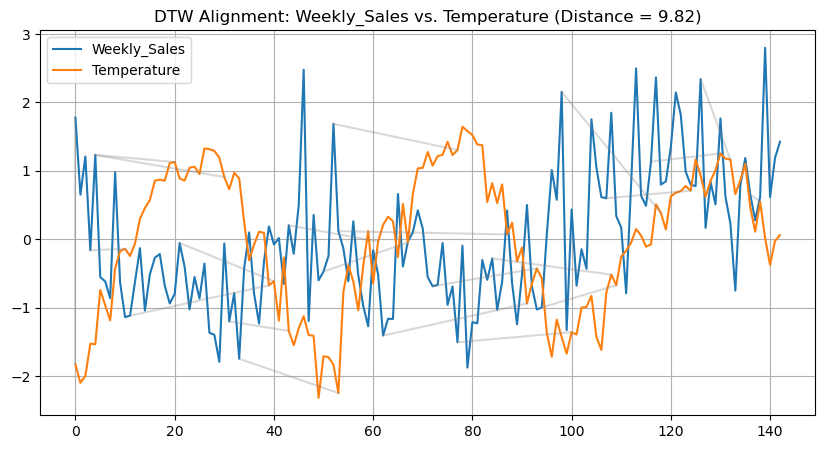

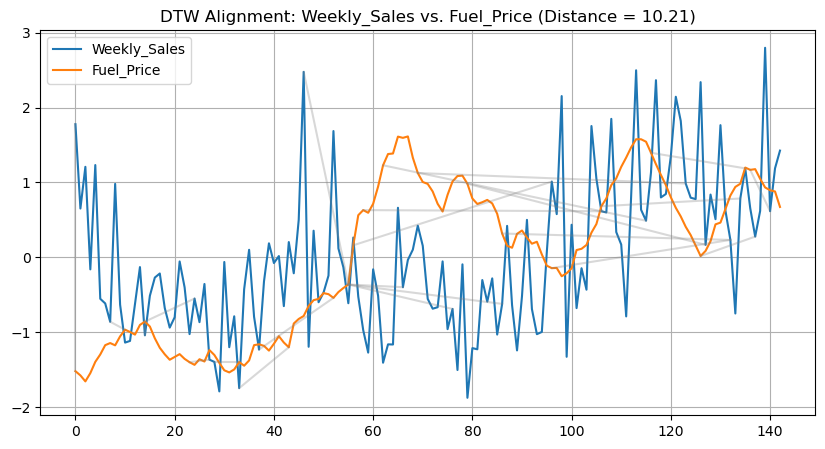

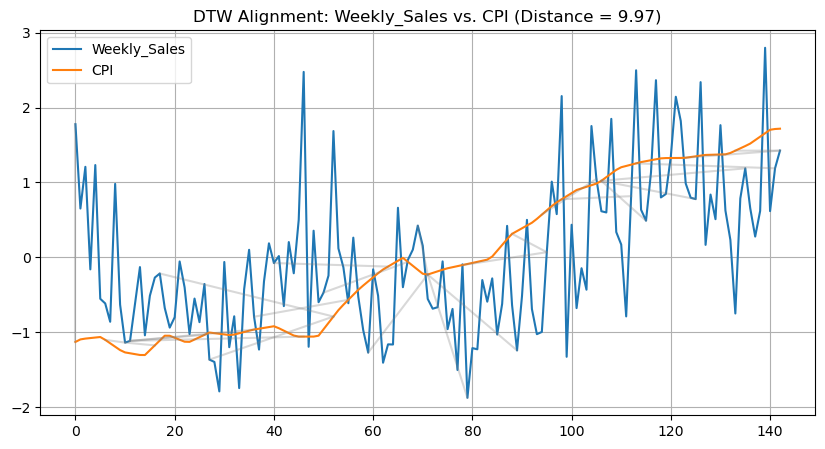

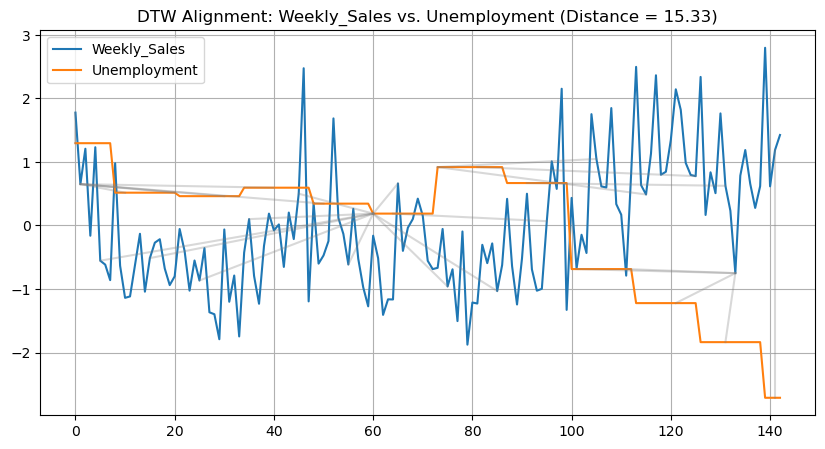

In [27]:

target_series = scaled_df['Weekly_Sales'].values
other_features = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']

for feature in other_features:
    feature_series = scaled_df[feature].values
    path, dist = dtw_path(target_series, feature_series)

    plt.figure(figsize=(10,5))
    plt.plot(target_series, label='Weekly_Sales')
    plt.plot(feature_series, label=feature)
    
    for (map_x, map_y) in path[::10]:  # skip some for clarity
        plt.plot([map_x, map_y], [target_series[map_x], feature_series[map_y]], color='gray', alpha=0.3)
        
    plt.legend()
    plt.title(f'DTW Alignment: Weekly_Sales vs. {feature} (Distance = {dist:.2f})')
    plt.grid(True)
    plt.show()


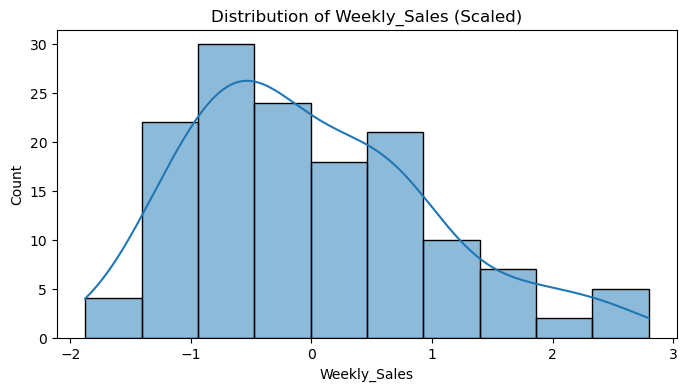

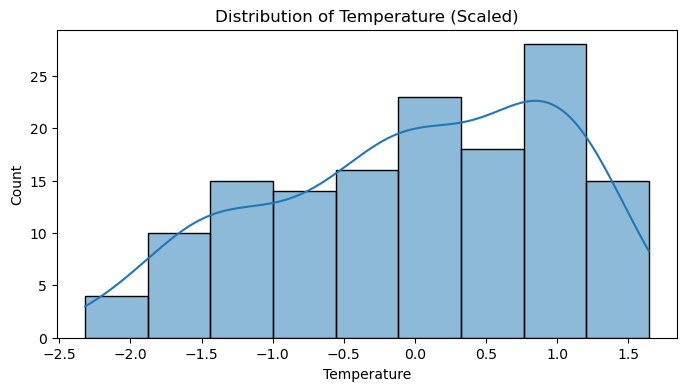

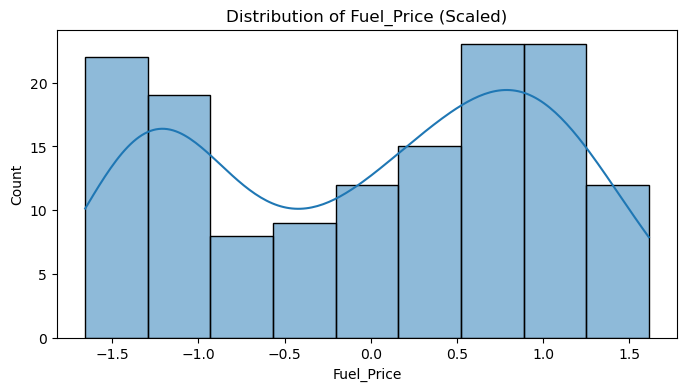

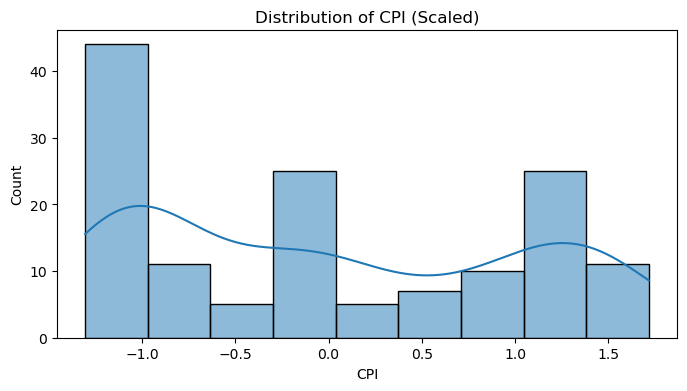

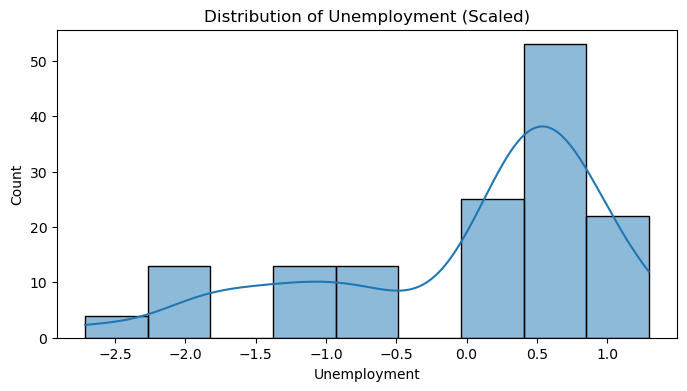

In [28]:
for feature in features:
    plt.figure(figsize=(8,4))
    sns.histplot(scaled_df[feature], kde=True)
    plt.title(f'Distribution of {feature} (Scaled)')
    plt.show()


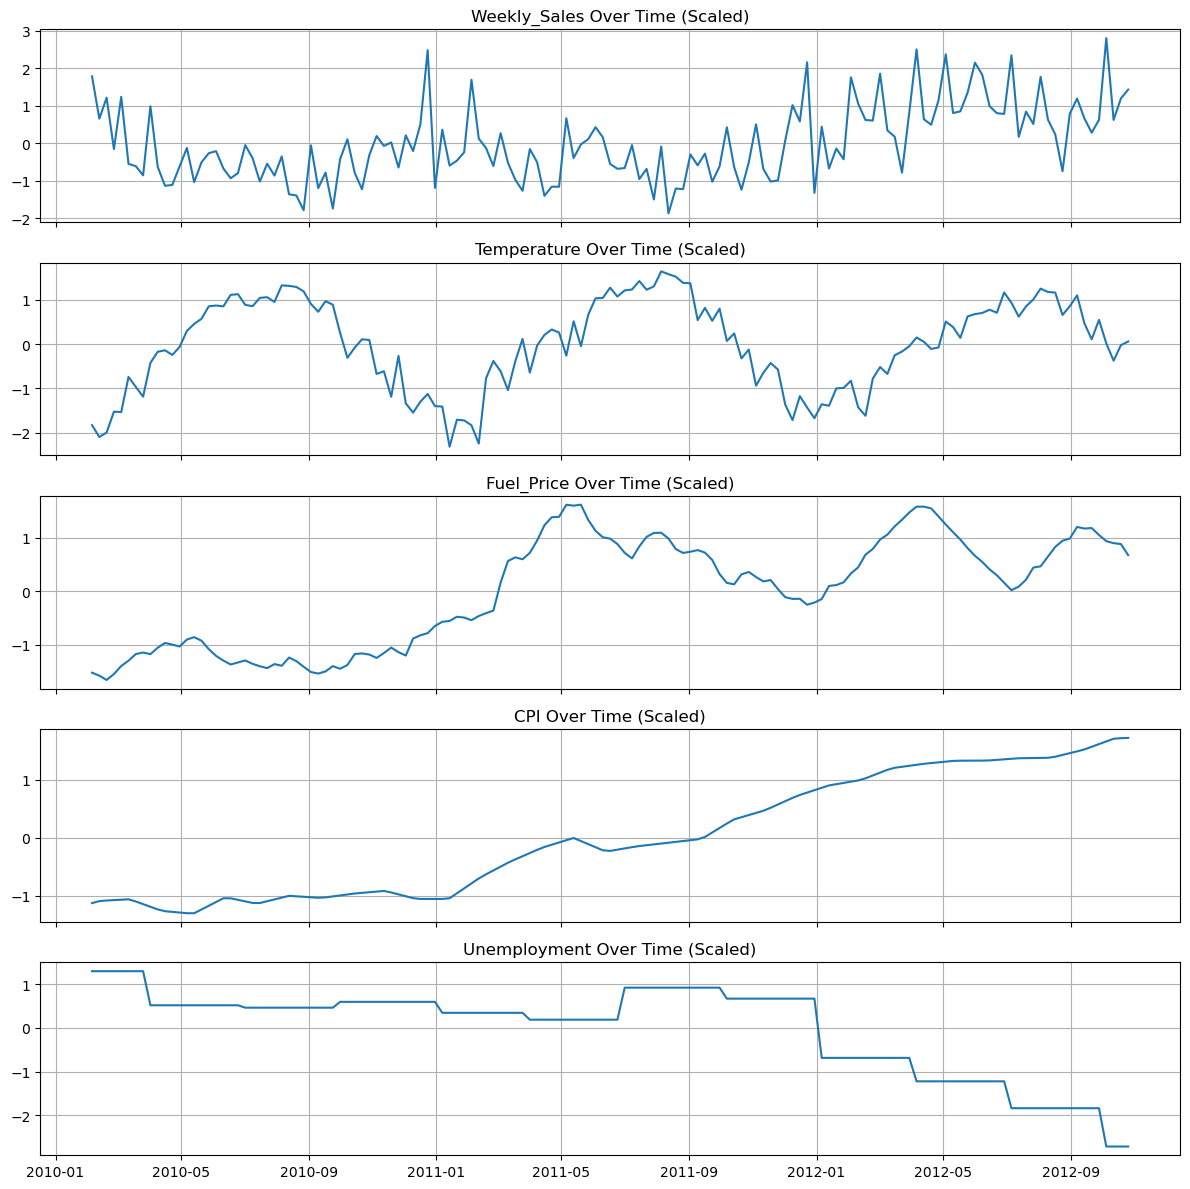

In [29]:
df_sorted = df.sort_values('Date')

fig, axs = plt.subplots(len(features), 1, figsize=(12, 12), sharex=True)

for i, feature in enumerate(features):
    axs[i].plot(df_sorted['Date'], scaled_df[feature])
    axs[i].set_title(f'{feature} Over Time (Scaled)')
    axs[i].grid(True)

plt.tight_layout()
plt.show()


# Training

In [30]:
class ANNModel:
    def __init__(self, input_shape, output_size=1):
        inputs = Input(shape=input_shape)
        x = layers.Flatten()(inputs)
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dense(64, activation='relu')(x)
        outputs = layers.Dense(output_size)(x)
        self.model = Model(inputs, outputs)

class CNNModel:
    def __init__(self, input_shape, output_size=1):
        inputs = Input(shape=input_shape)
        x = layers.Conv1D(64, kernel_size=3, activation='relu')(inputs)
        x = layers.MaxPooling1D(pool_size=2)(x)
        x = layers.Conv1D(32, kernel_size=3, activation='relu')(x)
        x = layers.GlobalAveragePooling1D()(x)
        outputs = layers.Dense(output_size)(x)
        self.model = Model(inputs, outputs)

class RNNModel:
    def __init__(self, input_shape, output_size=1):
        inputs = Input(shape=input_shape)
        x = layers.SimpleRNN(64, activation='tanh', return_sequences=False)(inputs)
        outputs = layers.Dense(output_size)(x)
        self.model = Model(inputs, outputs)

class LSTMModel:
    def __init__(self, input_shape, output_size=1):
        inputs = Input(shape=input_shape)
        x = layers.LSTM(64, return_sequences=False)(inputs)
        outputs = layers.Dense(output_size)(x)
        self.model = Model(inputs, outputs)

class GRUModel:
    def __init__(self, input_shape, output_size=1):
        inputs = Input(shape=input_shape)
        x = layers.GRU(64, return_sequences=False)(inputs)
        outputs = layers.Dense(output_size)(x)
        self.model = Model(inputs, outputs)

class FCNModel:
    def __init__(self, input_shape, output_size=1):
        inputs = Input(shape=input_shape)
        x = layers.Conv1D(128, kernel_size=8, padding='same', activation='relu')(inputs)
        x = layers.Conv1D(256, kernel_size=5, padding='same', activation='relu')(x)
        x = layers.Conv1D(128, kernel_size=3, padding='same', activation='relu')(x)
        x = layers.GlobalAveragePooling1D()(x)
        outputs = layers.Dense(output_size)(x)
        self.model = Model(inputs, outputs)

class CNNLSTMModel:
    def __init__(self, input_shape, output_size=1):
        inputs = Input(shape=input_shape)
        x = layers.Conv1D(64, kernel_size=3, activation='relu')(inputs)
        x = layers.MaxPooling1D(pool_size=2)(x)
        x = layers.LSTM(64, return_sequences=False)(x)
        outputs = layers.Dense(output_size)(x)
        self.model = Model(inputs, outputs)

class NBEATSLikeModel:
    def __init__(self, input_shape, output_size=1):
        inputs = Input(shape=input_shape)
        x = layers.Flatten()(inputs)
        for _ in range(4):
            x = layers.Dense(512, activation='relu')(x)
        outputs = layers.Dense(output_size)(x)
        self.model = Model(inputs, outputs)


In [74]:
def prepare_data(df, features, test_size=12, normalize=True):
    split_index = len(df) - test_size
    train_df = df.iloc[:split_index]
    test_df = df.iloc[split_index:]
    if normalize:
        scaler = StandardScaler()
        scaled_train = scaler.fit_transform(train_df[features])
        scaled_test = scaler.transform(test_df[features])
        return train_df, test_df, scaler, scaled_train, scaled_test
    else:
        return train_df, test_df, None, train_df[features].values, test_df[features].values	

def create_windows(data, window_size, horizon=1, flatten=False):
    X, y = [], []
    for i in range(len(data) - window_size - horizon + 1):
        window = data[i:(i+window_size)]
        X.append(window.flatten() if flatten else window)
        y.append(data[i+window_size:i+window_size+horizon, 0])  # Predict Weekly_Sales (col 0)
    return np.array(X), np.array(y)

def inverse_transform_target(y_scaled, scaler, features, target_only=True, feature_idx=0):
    y_scaled = np.array(y_scaled)

    print(y_scaled.shape)
    if target_only:
        #if y_scaled.ndim == 1:
        #    y_scaled = y_scaled.reshape(-1, 1)
       # elif y_scaled.ndim == 2 and y_scaled.shape[1] != 1:
         #   y_scaled = y_scaled.reshape(-1, 1)
        #y_scaled = y_scaled.flatten().reshape(-1, 1)
        if y_scaled.ndim == 1:
            y_scaled = y_scaled.reshape(-1, 1)
        elif y_scaled.ndim == 2 and y_scaled.shape[1] != 1:
            y_scaled = y_scaled[:, feature_idx].reshape(-1, 1)
        #temp = np.zeros((len(y_scaled), len(features)))
        temp = np.zeros((y_scaled.shape[0], len(features)))
        temp[:, feature_idx] = y_scaled.flatten()
        inv = scaler.inverse_transform(temp)
        return inv[:, feature_idx]
    
    else:
        # Forecasting all features at once
        #if y_scaled.shape[1] != len(features):
         #   temp = np.zeros((len(y_scaled), len(features)))
          #  temp[:, :y_scaled.shape[1]] = y_scaled
           # y_scaled = temp
        if y_scaled.ndim == 1:
            y_scaled = y_scaled.reshape(-1, len(features))
        elif y_scaled.shape[1] != len(features):
            temp = np.zeros((len(y_scaled), len(features)))
            temp[:, :y_scaled.shape[1]] = y_scaled
            y_scaled = temp    
        return scaler.inverse_transform(y_scaled)
        
def inverse_transform_target_no(y_scaled, scaler, features, target_only=True, feature_idx=0):
    y_scaled = np.array(y_scaled)

    if target_only:
        if y_scaled.ndim == 1:
            y_scaled = y_scaled.reshape(-1, 1)
        elif y_scaled.ndim == 2 and y_scaled.shape[1] != 1:
            y_scaled = y_scaled.reshape(-1, 1)

        temp = np.zeros((len(y_scaled), len(features)))
        temp[:, feature_idx] = y_scaled.flatten()
        inv = scaler.inverse_transform(temp)
        return inv[:, feature_idx]
    
    else:
        # Forecasting all features at once
        if y_scaled.shape[1] != len(features):
            temp = np.zeros((len(y_scaled), len(features)))
            temp[:, :y_scaled.shape[1]] = y_scaled
            y_scaled = temp
        return scaler.inverse_transform(y_scaled)



def inverse_transform_target_1(y_scaled, scaler, features, target_only=True, feature_idx=0):
    inv = scaler.inverse_transform(np.concatenate([y_scaled.reshape(-1,1), np.zeros((len(y_scaled), len(features)-1))], axis=1))[:,0]
    return inv

def recursive_multivariate_forecast(model, last_input, n_steps, features, window_size=None):
    """
    Recursive forecasting using last known sequence (with or without windowing).
    
    Args:
        model: Trained Keras model.
        last_input: Input sequence, shape (window, n_features) — can be full series or a window
        n_steps: Forecast steps
        scaler: Scaler for inverse transform
        features: Feature names
        window_size: Number of timesteps to use per input. If None, use full sequence length.
        
    Returns:
        np.array of shape (n_steps, n_features)
    """
    predictions = []
    current_sequence = last_input.copy()

    # Infer window size if not explicitly given
    if window_size is None:
        window_size = current_sequence.shape[0]

    for _ in range(n_steps):
        model_input = current_sequence[-window_size:].reshape(1, window_size, -1)

        pred_scaled = model.predict(model_input, verbose=0).flatten()

        if pred_scaled.shape[0] < len(features):
            pred_scaled = np.pad(pred_scaled, (0, len(features) - pred_scaled.shape[0]), 'constant')

        #inv_pred = scaler.inverse_transform(pred_scaled.reshape(1, -1)).flatten()
        #predictions.append(inv_pred if not target_only else inv_pred[feature_idx])
        predictions.append(pred_scaled)
        # Append prediction to sequence for next input
        current_sequence = np.vstack([current_sequence, pred_scaled])

    return np.array(predictions)


def recursive_multivariate_forecast_nooo(model, last_input, n_steps, scaler, features, 
                                    target_only=True, feature_idx=0, window_size=None):
    """
    Performs recursive multivariate forecasting using a trained model.
    
    Args:
        model: Trained Keras model.
        last_input: Last input data. Shape should be (window_size, n_features) if windowed,
                    or (T, n_features) if not windowed.
        n_steps: Number of steps to forecast into the future.
        scaler: Scaler used for inverse transformation.
        features: List of feature names.
        target_only: Whether to return only the target feature or full feature set.
        feature_idx: Index of the target feature in the features list.
        window_size: Size of the input window (None if no windowing is used).
    
    Returns:
        Numpy array of predictions. Shape: (n_steps,) if target_only else (n_steps, n_features)
    """
    predictions = []
    current_input = last_input.copy()

    for _ in range(n_steps):
        if window_size:  # Windowed mode
            model_input = current_input[-window_size:].reshape(1, window_size, -1)
        else:  # No window, use last timestep only (assumed model supports it)
            model_input = current_input[-1:].reshape(1, 1, -1)

        pred_scaled = model.predict(model_input).flatten()

        # Ensure predicted vector matches number of features
        if pred_scaled.shape[0] < len(features):
            pred_scaled = np.pad(pred_scaled, (0, len(features) - pred_scaled.shape[0]), 'constant')

        inv_pred = scaler.inverse_transform(pred_scaled.reshape(1, -1)).flatten()
        predictions.append(inv_pred if not target_only else inv_pred[feature_idx])

        # Update input with new prediction
        current_input = np.vstack([current_input, pred_scaled])

    return np.array(predictions)

def recursive_multivariate_forecast_3(model, last_point, n_steps, scaler, features, 
                                    target_only=True, feature_idx=0):
    predictions = []
    current_point = last_point.copy()  # shape: (window_size, n_features)

    for _ in range(n_steps):
        input_point = current_point.reshape(1, *current_point.shape)  # shape (1, window_size, n_features)
        pred_scaled = model.predict(input_point).flatten()

        if pred_scaled.shape[0] < len(features):
            pred_scaled = np.pad(pred_scaled, (0, len(features) - pred_scaled.shape[0]), 'constant')

        inv_pred = scaler.inverse_transform(pred_scaled.reshape(1, -1)).flatten()
        predictions.append(inv_pred if not target_only else inv_pred[feature_idx])

        # Update next step input
        current_point = np.vstack([current_point[1:], pred_scaled])

    return np.array(predictions)
    
def recursive_multivariate_forecast_1(model, last_window, n_steps, scaler, features, 
                                    target_only=True, feature_idx=0):
    predictions = []
    current_window = last_window.copy()

    for _ in range(n_steps):
        input_window = current_window.reshape(1, *current_window.shape)
        pred_scaled_vector = model.predict(input_window).flatten()
        inv_pred_vector = scaler.inverse_transform(
            np.pad(pred_scaled_vector.reshape(1, -1), ((0,0),(0,len(features)-pred_scaled_vector.shape[0])), 'constant')
        ).flatten()

        predictions.append(inv_pred_vector if not target_only else inv_pred_vector[feature_idx])

        # Prepare new window for next iteration (use predicted scaled values, not inverse)
        if pred_scaled_vector.shape[0] < current_window.shape[1]:
            pred_scaled_vector = np.pad(pred_scaled_vector, (0, current_window.shape[1]-pred_scaled_vector.shape[0]), 'constant')
        current_window = np.vstack([current_window[1:], pred_scaled_vector])

    return np.array(predictions)
    
def evaluate_predictions(y_true, y_pred):
    return {
        "rmse": float(mean_squared_error(y_true, y_pred)),
        "mae": float(mean_absolute_error(y_true, y_pred)),
        "mape": float(mean_absolute_percentage_error(y_true, y_pred)),
        "dtw": float(dtw(y_true, y_pred))
    }

def plot_forecast(y_true, y_pred, save_path=None):
    plt.figure(figsize=(10,5))
    plt.plot(y_true, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.legend()
    plt.title("Forecast vs Actual")
    if save_path:
        plt.savefig(save_path)
    plt.show()
    plt.close()

def plot_forecast_multivariate_1(y_true, y_pred, X_train, train_dates, test_dates,
                                scaler, features, target_only=True, feature_idx=0, save_dir=None, prefix=""):


    # Inverse transform X_train final timestep
    last_steps_scaled = X_train[:, -1, :]
    X_train_inv = scaler.inverse_transform(last_steps_scaled)
    full_dates = pd.concat([train_dates, test_dates.iloc[:len(y_true)]], ignore_index=True)
    if target_only:
        y_train = X_train_inv[:, feature_idx]
        plt.figure(figsize=(12, 5))
        plt.plot(train_dates, y_train, label="Train", color="blue")
        plt.plot(full_dates, y_true, label="True", color="green")
        plt.plot(full_dates, y_pred, "--", label="Predicted", color="red")
        plt.title(f"Forecast - Feature {features[feature_idx]}")
        plt.xlabel("Date")
        plt.ylabel(features[feature_idx])
        plt.legend()
        if save_dir:
            path = os.path.join(save_dir, f"{prefix}feature_{feature_idx}_forecast.png")
            plt.savefig(path)
        plt.show()

    else:
        n_features = y_pred.shape[1]
        for i in range(n_features):
            y_train = X_train_inv[:, i]
            y_t = y_true[:, i]
            y_p = y_pred[:, i]

            plt.figure(figsize=(12, 5))
            plt.plot(train_dates, y_train, label="Train", color="blue")
            plt.plot(full_dates, y_t, label="True", color="green")
            plt.plot(full_dates, y_p, "--", label="Predicted", color="red")
            plt.title(f"Forecast - Feature {features[i]}")
            plt.xlabel("Date")
            plt.ylabel(features[i])
            plt.legend()
            if save_dir:
                path = os.path.join(save_dir, f"{prefix}feature_{i}_forecast.png")
                plt.savefig(path)
            plt.show()


def plot_forecast_multivariate(y_true, y_pred, X_train, train_dates, test_dates,
                                scaler, features, target_only=True, feature_idx=0, save_dir=None, prefix=""):
    
    
        # Inverse transform X_train final timestep
        last_steps_scaled = X_train[:, -1, :]
        X_train_inv = scaler.inverse_transform(X_train[0])
        full_dates = pd.concat([train_dates, test_dates.iloc[:len(y_true)]], ignore_index=True)
        use_date_index = (len(full_dates) == len(y_pred) + len(X_train_inv))

        if target_only:
            y_train = X_train_inv[:, feature_idx]
            print(y_train)
            print(f"train_dates shape: {train_dates.shape}, y_train shape: {y_train.shape}")
            print(f"test_dates shape: {test_dates.shape}, y_true shape: {y_true.shape}, y_pred shape: {y_pred.shape}")
            plt.figure(figsize=(12, 5))
            #plt.plot(train_dates, y_train, label="Train", color="blue")
            #plt.plot(full_dates, y_true, label="True", color="green")
            #plt.plot(full_dates, y_pred, "--", label="Predicted", color="red")
            
            if use_date_index:
                plt.plot(full_dates[:len(y_train)], y_train, label="Train", color="blue")
                plt.plot(full_dates[len(y_train):len(y_train) + len(y_true)], y_true, label="True", color="green")
                plt.plot(full_dates[len(y_train):len(y_train) + len(y_pred)], y_pred, "--", label="Predicted", color="red")
            else:
                plt.plot(range(len(y_train)), y_train, label="Train", color="blue")
                plt.plot(range(len(y_train), len(y_train) + len(y_true)), y_true, label="True", color="green")
                plt.plot(range(len(y_train), len(y_train) + len(y_pred)), y_pred, "--", label="Predicted", color="red")
            
            #plt.plot(train_dates[:len(y_train)], y_train, label="Train", color="blue")
            
            # Plot true values (test period)
            #plt.plot(test_dates[:len(y_true)], y_true, label="True", color="green")
            
            # Plot predictions
            #plt.plot(test_dates[:len(y_pred)], y_pred, "--", label="Predicted", color="red")
            plt.title(f"Forecast - Feature {features[feature_idx]}")
            plt.xlabel("Date")
            plt.ylabel(features[feature_idx])
            plt.legend()
            if save_dir:
                path = os.path.join(save_dir, f"{prefix}feature_{feature_idx}_forecast.png")
                plt.savefig(path)
            plt.show()
    
        else:
            n_features = y_pred.shape[1]
            for i in range(n_features):
                y_train = X_train_inv[:, i]
                y_t = y_true[:, i]
                y_p = y_pred[:, i]
    
                plt.figure(figsize=(12, 5))
                #plt.plot(train_dates, y_train, label="Train", color="blue")
                #plt.plot(full_dates, y_t, label="True", color="green")
                #plt.plot(full_dates, y_p, "--", label="Predicted", color="red")

                if use_date_index:
                    plt.plot(full_dates[:len(y_train)], y_train, label="Train", color="blue")
                    plt.plot(full_dates[len(y_train):len(y_train) + len(y_true)], y_true, label="True", color="green")
                    plt.plot(full_dates[len(y_train):len(y_train) + len(y_pred)], y_pred, "--", label="Predicted", color="red")
                else:
                    plt.plot(range(len(y_train)), y_train, label="Train", color="blue")
                    plt.plot(range(len(y_train), len(y_train) + len(y_true)), y_true, label="True", color="green")
                    plt.plot(range(len(y_train), len(y_train) + len(y_pred)), y_pred, "--", label="Predicted", color="red")

                #plt.plot(train_dates[:len(y_train)], y_train, label="Train", color="blue")
            
                # Plot true values (test period)
                #plt.plot(test_dates[:len(y_t)], y_t, label="True", color="green")
                
                # Plot predictions
                #plt.plot(test_dates[:len(y_p)], y_p, "--", label="Predicted", color="red")
                #plt.plot(range(len(y_train)), y_train, label="Train", color="blue")
                #plt.plot(range(len(y_train), len(y_train) + len(y_true)), y_true, label="True", color="green")
                #plt.plot(range(len(y_train), len(y_train) + len(y_pred)), y_pred, "--", label="Predicted", color="red")
                plt.title(f"Forecast - Feature {features[i]}")
                plt.xlabel("Date")
                plt.ylabel(features[i])
                plt.legend()
                if save_dir:
                    path = os.path.join(save_dir, f"{prefix}feature_{i}_forecast.png")
                    plt.savefig(path)
                plt.show()
                
def plot_forecast_multivariate_2(y_true, y_pred, X_train, target_only=True, feature_idx=0, save_dir=None, prefix=""):

    if target_only:
        y_train = X_train[:, -1, feature_idx]
        plt.figure(figsize=(12, 5))
        plt.plot(range(len(y_train)), y_train, label="Train", color="blue")
        plt.plot(range(len(y_train), len(y_train) + len(y_true)), y_true, label="True", color="green")
        plt.plot(range(len(y_train), len(y_train) + len(y_pred)), y_pred, "--", label="Predicted", color="red")
        plt.title(f"Forecast - Feature {feature_idx}")
        plt.legend()
        if save_dir:
            path = os.path.join(save_dir, f"{prefix}feature_{feature_idx}_forecast.png")
            plt.savefig(path)
        plt.show()
    else:
        n_features = y_pred.shape[1]
        y_train_all = X_train[:, -1, :] 

        for i in range(n_features):
            y_train = y_train_all[:, i]
            y_t = y_true[:, i]
            y_p = y_pred[:, i]

            plt.figure(figsize=(12, 5))
            plt.plot(range(len(y_train)), y_train, label="Train", color="blue")
            plt.plot(range(len(y_train), len(y_train) + len(y_t)), y_t, label="True", color="green")
            plt.plot(range(len(y_train), len(y_train) + len(y_p)), y_p, "--", label="Predicted", color="red")
            plt.title(f"Forecast - Feature {i}")
            plt.legend()
            if save_dir:
                path = os.path.join(save_dir, f"{prefix}feature_{i}_forecast.png")
                plt.savefig(path)
            plt.show()


def plot_dtw_alignments(y_true, y_pred, X_train, train_dates, test_dates,
                         scaler, features, target_only=True, feature_idx=0,
                         save_dir=None, prefix="forecast_dtw"):


    X_train_inv = scaler.inverse_transform(X_train[0])
    full_dates = pd.concat([train_dates, test_dates.iloc[:len(y_true)]], ignore_index=True)
    
    if target_only:
        y_train = X_train_inv[:, feature_idx]
        y_t = np.array(y_true)
        y_p = np.array(y_pred)

        plt.figure(figsize=(12, 5))
        # Plot actual forecast parts
        plt.plot(full_dates[:len(y_train)], y_train, label="Train", color="blue")
        plt.plot(full_dates[len(y_train):len(y_train) + len(y_true)], y_true, label="True", color="green")
        plt.plot(full_dates[len(y_train):len(y_train) + len(y_pred)], y_pred, "--", label="Predicted", color="red")

        # Plot DTW alignments
        path, dist = dtw_path(y_t, y_p)
        for (ix, iy) in path:
            plt.plot([test_dates.iloc[ix], test_dates.iloc[iy]], [y_t[ix], y_p[iy]], color="gray", linewidth=0.5)

        plt.title(f"DTW Alignment - Feature {features[feature_idx]} (DTW: {dist:.4f})")
        plt.xlabel("Date")
        plt.ylabel(features[feature_idx])
        plt.legend()
        print(f"DTW distance (feature {features[feature_idx]}): {dist:.4f}")

        if save_dir:
            path = os.path.join(save_dir, f"{prefix}_feature_{feature_idx}.png")
            plt.savefig(path)
        plt.show()

    else:
        n_features = y_pred.shape[1]
        for i in range(n_features):
            y_train = X_train_inv[:, i]
            y_t = np.array(y_true[:, i])
            y_p = np.array(y_pred[:, i])

            plt.figure(figsize=(12, 5))
            plt.plot(full_dates[:len(y_train)], y_train, label="Train", color="blue")
            plt.plot(full_dates[len(y_train):len(y_train) + len(y_true)], y_true, label="True", color="green")
            plt.plot(full_dates[len(y_train):len(y_train) + len(y_pred)], y_pred, "--", label="Predicted", color="red")

            path, dist = dtw_path(y_t, y_p)
            for (ix, iy) in path:
                plt.plot([test_dates.iloc[ix], test_dates.iloc[iy]], [y_t[ix], y_p[iy]], color="gray", linewidth=0.5)

            plt.title(f"DTW Alignment - Feature {features[i]} (DTW: {dist:.4f})")
            plt.xlabel("Date")
            plt.ylabel(features[i])
            plt.legend()
            print(f"DTW distance (feature {features[i]}): {dist:.4f}")

            if save_dir:
                path = os.path.join(save_dir, f"{prefix}_feature_{i}.png")
                plt.savefig(path)
            plt.show()


def plot_dtw_alignments_2(y_true, y_pred, save_dir, prefix="forecast_dtw"):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    if y_true.ndim == 1:
        y_true = y_true.reshape(-1, 1)
    if y_pred.ndim == 1:
        y_pred = y_pred.reshape(-1, 1)

    scaler = TimeSeriesScalerMinMax()
    y_true_scaled = scaler.fit_transform(y_true)
    y_pred_scaled = scaler.fit_transform(y_pred)

    for i in range(y_true.shape[1]):
        plt.figure(figsize=(10, 5))
        path, _ = dtw_path(y_true_scaled[:, i], y_pred_scaled[:, i])
        for (map_x, map_y) in path:
            plt.plot([map_x, map_y], [y_true[map_x, i], y_pred[map_y, i]], color="gray", linewidth=0.5)
        plt.plot(y_true[:, i], label="True", color="green")
        plt.plot(y_pred[:, i], label="Pred", color="red")
        plt.title(f"DTW Alignment - Feature {i}")
        plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, f"{prefix}_feature_{i}.png"))
        plt.show()



def check_gpu(use_gpu):
    gpus = tf.config.list_physical_devices('GPU')
    if use_gpu and not gpus:
        print("⚠ No GPU detected. Switching to CPU.")
    return gpus if gpus else None

Epoch 1/200
1/1 [==============================] - 0s 340ms/step - loss: 3.0270
Epoch 2/200
1/1 [==============================] - 0s 9ms/step - loss: 2.8490
Epoch 3/200
1/1 [==============================] - 0s 16ms/step - loss: 2.6757
Epoch 4/200
1/1 [==============================] - 0s 42ms/step - loss: 2.5070
Epoch 5/200
1/1 [==============================] - 0s 10ms/step - loss: 2.3462
Epoch 6/200
1/1 [==============================] - 0s 53ms/step - loss: 2.1926
Epoch 7/200
1/1 [==============================] - 0s 20ms/step - loss: 2.0439
Epoch 8/200
1/1 [==============================] - 0s 9ms/step - loss: 1.8989
Epoch 9/200
1/1 [==============================] - 0s 14ms/step - loss: 1.7577
Epoch 10/200
1/1 [==============================] - 0s 10ms/step - loss: 1.6221
Epoch 11/200
1/1 [==============================] - 0s 29ms/step - loss: 1.4916
Epoch 12/200
1/1 [==============================] - 0s 19ms/step - loss: 1.3662
Epoch 13/200
1/1 [==============================] 

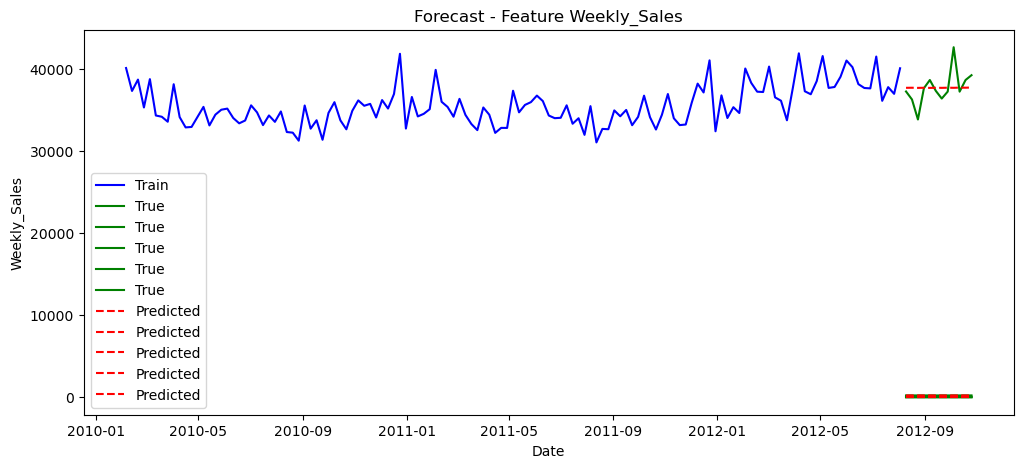

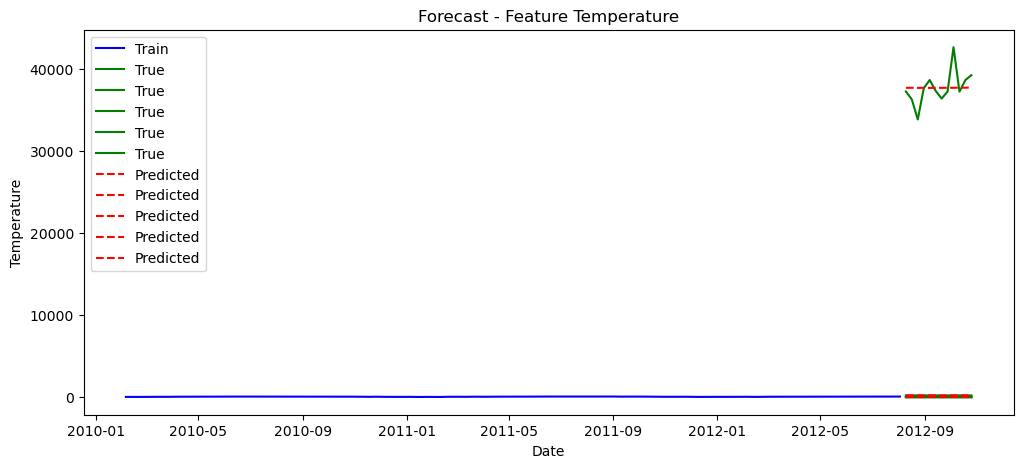

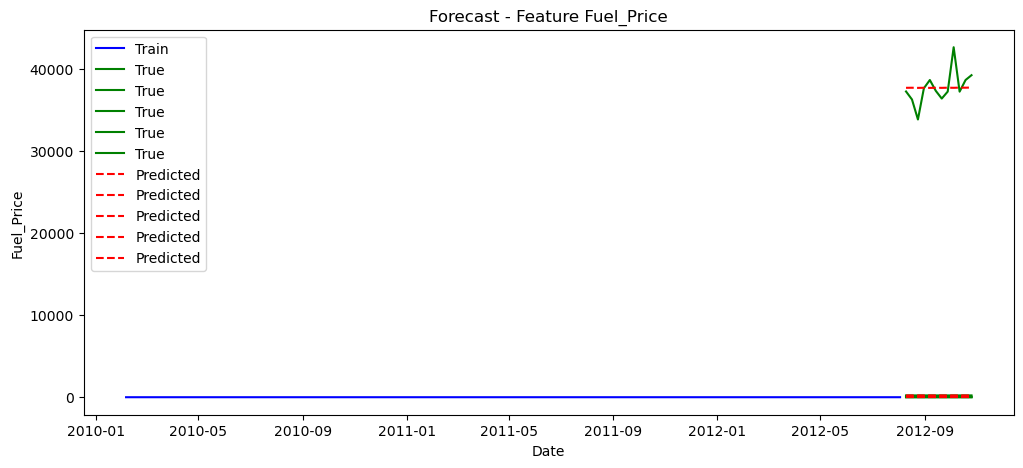

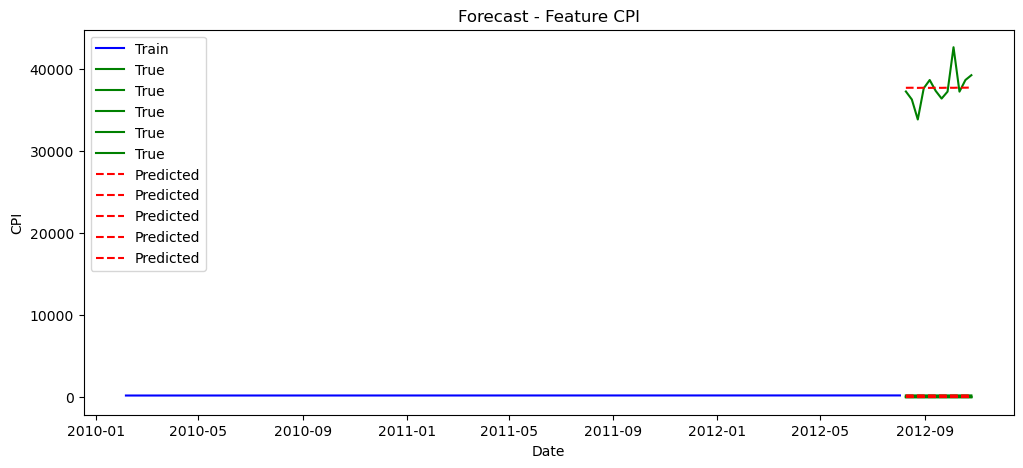

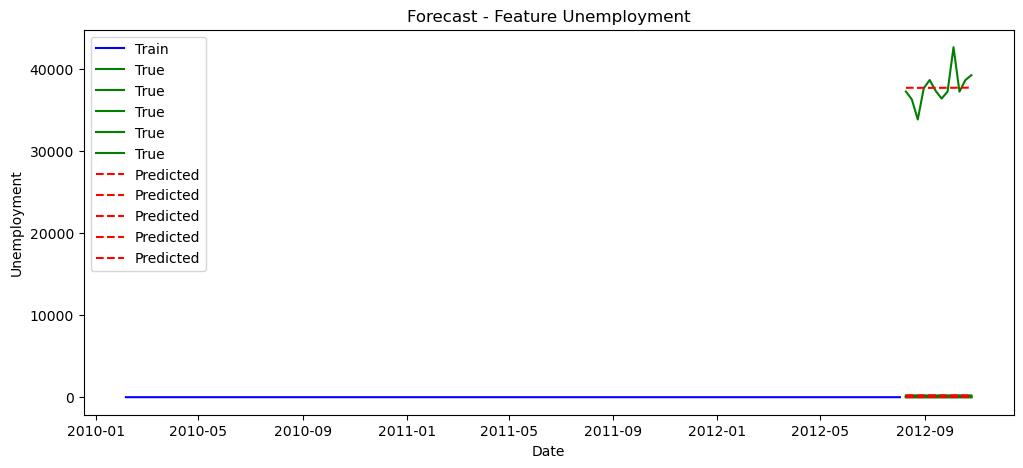

DTW distance (feature Weekly_Sales): 6896.7962


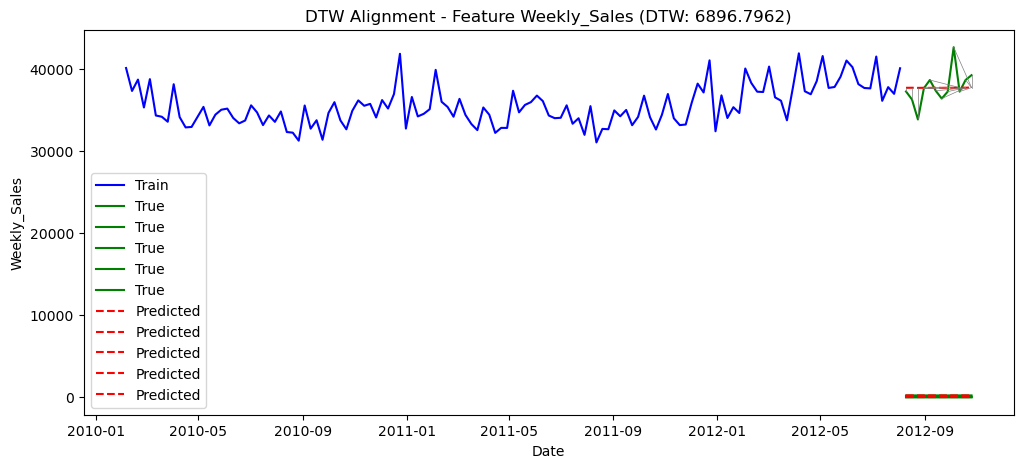

DTW distance (feature Temperature): 23.9492


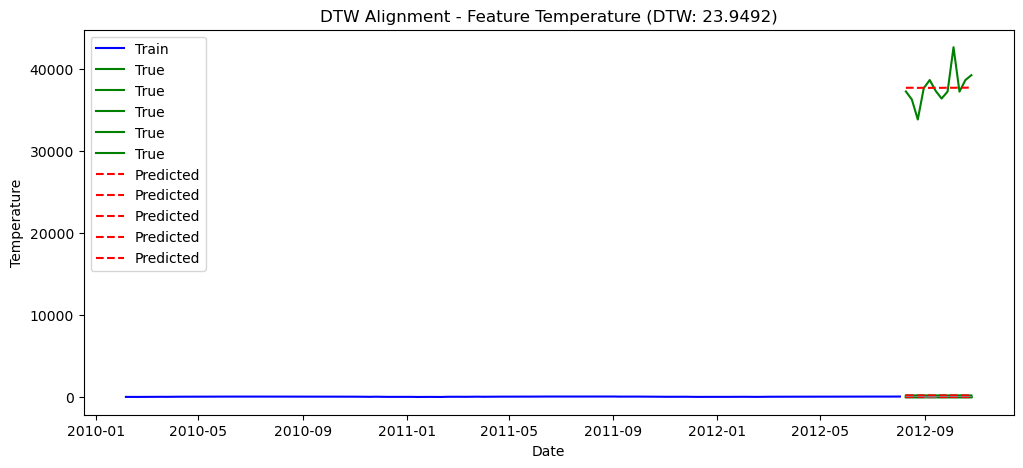

DTW distance (feature Fuel_Price): 0.2549


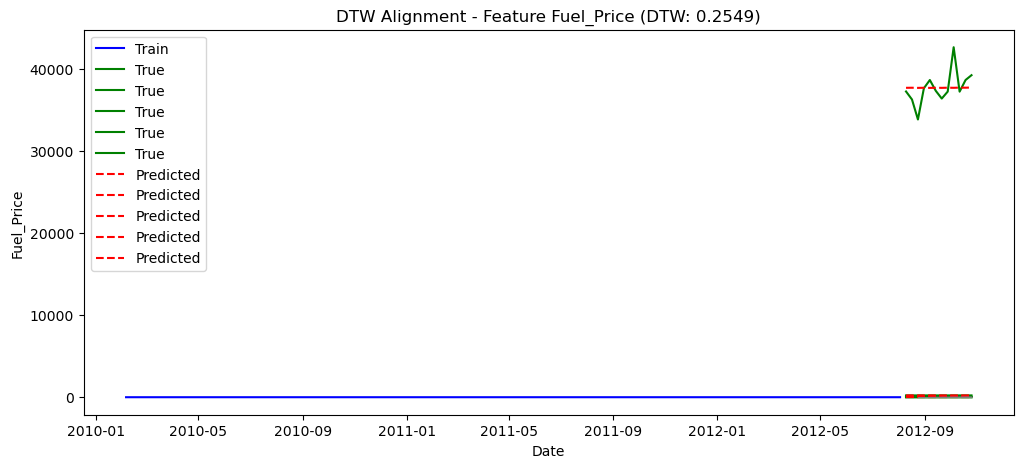

DTW distance (feature CPI): 1.7696


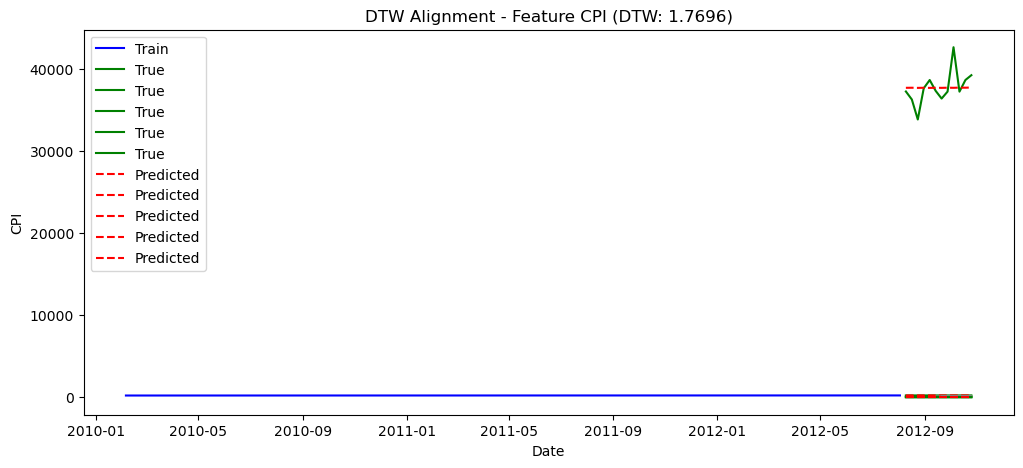

DTW distance (feature Unemployment): 0.4968


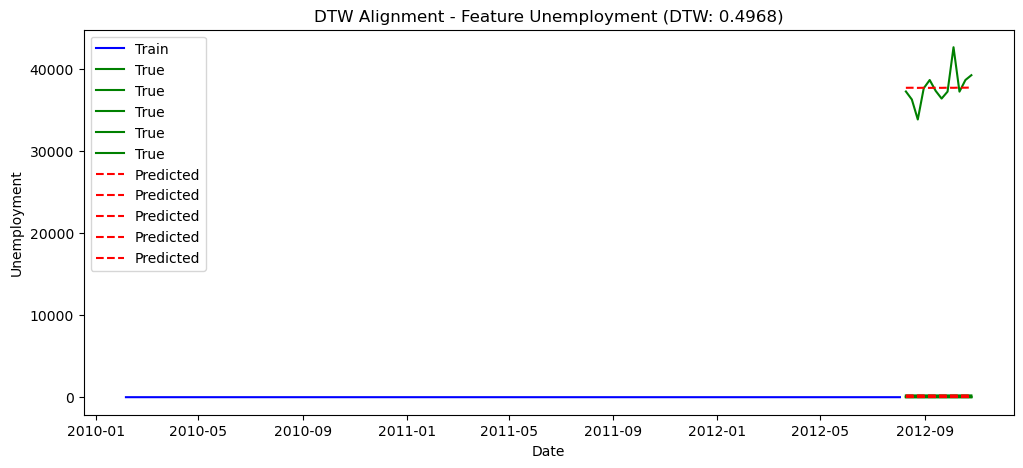

Recursive Results for CNN: {'rmse': 798646.3375978506, 'mae': 280.92608702734566, 'mape': 0.03170729065623157, 'dtw': 6896.85071123568}
✅ CNN completed. Results saved to outputs\CNN\no_window\recursive\data


In [65]:
train_forecast_model(
    model_type="CNN",
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    train_dates=train_dates,
    test_dates=test_dates,
    scaler=scaler,
    features=features,
    predict_all=False,
    horizon=horizon,
    output_dir='outputs',
    use_gpu=True,
    model_kwargs={},
    fit_kwargs={
        "epochs": 200,
        "batch_size": 1,
        "validation_split": 0
    },
    target_only=True,
    feature_idx=0
)


In [128]:

model_classes = {
    "CNN": CNNModel,
    "LSTM": LSTMModel,
    "RNN": RNNModel,
    "GRU": GRUModel,
    "FCN": FCNModel,
    "ANN": ANNModel,
    "CNN-LSTM":CNNLSTMModel,
    "NBEATS": NBEATSLikeModel,
}

ml_models = {
    "XGBoost": XGBRegressor,
    "RandomForest": RandomForestRegressor,
    "DecisionTree": DecisionTreeRegressor,
    "ExtraTrees": ExtraTreesRegressor,
    "GradientBoosting": GradientBoostingRegressor,
    "LGBM": LGBMRegressor,
    "LinearRegression": LinearRegression,
    "Ridge": Ridge,
    "Lasso": Lasso,
    "ElasticNet": ElasticNet,
    "SVR": SVR,
    "KNeighbors": KNeighborsRegressor
}


default_param_grids = {
    "RandomForest": {"n_estimators": [50, 100, 200], "max_depth": [3, 5, 10, None]},
    "DecisionTree": {"max_depth": [3, 5, 10, None]},
    "ExtraTrees": {"n_estimators": [50, 100, 200], "max_depth": [3, 5, 10, None]},
    "GradientBoosting": {"n_estimators": [50, 100, 200], "learning_rate": [0.01, 0.1, 0.2]},
    "LGBM": {"n_estimators": [50, 100, 200], "learning_rate": [0.01, 0.1, 0.2]}
}


def train_forecast_model(model_type, X_train, X_test, y_train, y_test, train_dates, test_dates, scaler, features,
                         predict_all=True, window_size=None, horizon=12,
                         output_dir='outputs', use_gpu=True,
                         cv=False, param_grid=None, target_only=True, feature_idx=0, 
                         model_kwargs=None, fit_kwargs=None, dtw_plot=True, **kwargs):
    
    check_gpu(use_gpu)
    
    pred_type = "direct" if predict_all else "recursive"
    window_mode = f"window_{window_size}" if window_size else "no_window"
    folder_name = os.path.join(output_dir, model_type, window_mode, pred_type, "data")
    os.makedirs(folder_name, exist_ok=True)

    results = {}
    model_kwargs = model_kwargs or {}
    fit_kwargs = fit_kwargs or {}

    output_dim = X_train.shape[-1]


    if model_type in model_classes:
        model = model_classes[model_type](input_shape=X_train.shape[1:], output_size=(horizon if predict_all else len(features)), **model_kwargs).model
        model.compile(optimizer='adam', loss='mse')
        callbacks = []
        if fit_kwargs.get("validation_split", 0.2) > 0:
            callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
        
        model.fit(X_train, y_train, validation_split=fit_kwargs.get("validation_split", 0.2), epochs=fit_kwargs.get("epochs", 100), batch_size=fit_kwargs.get("batch_size", 16), callbacks=callbacks, verbose=1)
        model.save(os.path.join(folder_name, "model.keras"))

        if predict_all:
            y_pred_scaled = model.predict(X_test).reshape(-1, horizon)
            y_pred = inverse_transform_target(y_pred_scaled, scaler, features, target_only=target_only, feature_idx=feature_idx, window=window_size)
            y_true = inverse_transform_target(y_test, scaler, features, target_only=target_only, feature_idx=feature_idx, window=window_size)
            results = evaluate_predictions(y_true, y_pred)
            #plot_forecast(y_true, y_pred, save_path=os.path.join(folder_name, "forecast.png"))
            plot_forecast_multivariate(y_true, y_pred, X_train, train_dates, test_dates, scaler, features, target_only=target_only, feature_idx=feature_idx, save_dir=folder_name, use_window=window_size)
            if dtw_plot:
                plot_dtw_alignments(y_true, y_pred, X_train, train_dates, test_dates, scaler, features, target_only=target_only, feature_idx=feature_idx, save_dir=folder_name)
        
        else:
            last_window = X_test[-1]
            pred_recursive = recursive_multivariate_forecast(model, last_window, n_steps=horizon, features=features)
            #y_pred_recursive = pred_recursive[:,0]
            #y_pred_recursive = pred_recursive
            y_pred_recursive = inverse_transform_target(pred_recursive[:horizon], scaler, features, target_only=target_only, feature_idx=feature_idx, window=window_size)
            y_true = inverse_transform_target(y_test[:horizon], scaler, features, target_only=target_only, feature_idx=feature_idx, window=window_size)
            recursive_results = evaluate_predictions(y_true, y_pred_recursive)
            #plot_forecast(y_true, y_pred_recursive, save_path=os.path.join(folder_name, "recursive_forecast.png"))
            plot_forecast_multivariate(y_true, y_pred_recursive, X_train, train_dates, test_dates, scaler, features, target_only=target_only,
                                       feature_idx=feature_idx, save_dir=folder_name, use_window=window_size, prefix='recursive')
            results["recursive"] = recursive_results
            if dtw_plot:
                plot_dtw_alignments(y_true, y_pred_recursive, X_train, train_dates, test_dates, scaler, features, target_only=target_only, feature_idx=feature_idx, save_dir=folder_name, prefix='recursive')


    elif model_type in ml_models:
        model = ml_models[model_type]()
        if cv:
            param_grid_to_use = param_grid if param_grid else default_param_grids.get(model_type, {})
            search = GridSearchCV(model, param_grid=param_grid_to_use, cv=5, n_jobs=-1, verbose=2)
            search.fit(X_train, y_train)
            model = search.best_estimator_
            with open(os.path.join(folder_name, "best_params.json"), "w") as f:
                json.dump(search.best_params_, f, indent=4)
        else:
            model.fit(X_train, y_train)

        preds_scaled = model.predict(X_test)
        preds = inverse_transform_target(preds_scaled, scaler, features, target_only=target_only, feature_idx=feature_idx, window=window_size)
        y_true = inverse_transform_target(y_test, scaler, features, target_only=target_only, feature_idx=feature_idx, window=window_size)
        results = evaluate_predictions(y_true, preds)
        #plot_forecast(y_true, preds, save_path=os.path.join(folder_name, "forecast.png"))
        plot_forecast_multivariate(y_true, preds, X_train, train_dates, test_dates, scaler, features, target_only=target_only,
                                   feature_idx=feature_idx, save_dir=folder_name, use_window=window_size)
        if dtw_plot:
            plot_dtw_alignments(y_true, preds, X_train, train_dates, test_dates, scaler, features, target_only=target_only, feature_idx=feature_idx, save_dir=folder_name)
    elif model_type == "ARIMA":
        #target_column = kwargs.get("target_column", "Weekly_Sales")
        #order = kwargs.get("order", (1,1,1))
    
        #y_train = X_train.flatten() if not isinstance(X_train, pd.DataFrame) else X_train[target_column].values
        #y_test = X_test.flatten() if not isinstance(X_test, pd.DataFrame) else X_test[target_column].values
    
        #model = ARIMA_Model(y_train, order=order)
        #fit = model.fit()
        
        #forecast = fit.forecast(steps=len(y_test))
        #results = evaluate_predictions(y_test, forecast)
        #plot_forecast(y_test, forecast, save_path=os.path.join(folder_name, "forecast_ARIMA.png"))

        order = kwargs.get("order", (1, 1, 1))
        model = ARIMA_Model(y_train.flatten(), order=order)
        fit = model.fit()

        forecast_scaled = fit.forecast(steps=len(y_test))
        forecast = inverse_transform_target(forecast_scaled, scaler, features, target_only=target_only, feature_idx=feature_idx, window=window_size)
        y_true = inverse_transform_target(y_test, scaler, features, target_only=target_only, feature_idx=feature_idx, window=window_size)
        results = evaluate_predictions(y_true, forecast)
        #plot_forecast(y_true, forecast, save_path=os.path.join(folder_name, "forecast_ARIMA.png"))
        plot_forecast_multivariate(y_true, forecast, X_train, train_dates, test_dates, scaler, features, target_only=target_only,
                                   feature_idx=feature_idx, save_dir=folder_name, use_window=window_size)
        if dtw_plot:
            plot_dtw_alignments(y_true, forecast, X_train, train_dates, test_dates, scaler, features, target_only=target_only, feature_idx=feature_idx, save_dir=folder_name)
    elif model_type == "SARIMA":
        #target_column = kwargs.get("target_column", "Weekly_Sales")
        #order = kwargs.get("order", (1,1,1))
        #seasonal_order = kwargs.get("seasonal_order", (1,1,1,12))
    
        #y_train = X_train.flatten() if not isinstance(X_train, pd.DataFrame) else X_train[target_column].values
        #y_test = X_test.flatten() if not isinstance(X_test, pd.DataFrame) else X_test[target_column].values
    
        #model = SARIMAX_Model(y_train, order=order, seasonal_order=seasonal_order)
        #fit = model.fit(disp=False)
    
        #forecast = fit.forecast(steps=len(y_test))
        #results = evaluate_predictions(y_test, forecast)
        #plot_forecast(y_test, forecast, save_path=os.path.join(folder_name, "forecast_SARIMA.png"))
        
        
        order = kwargs.get("order", (1, 1, 1))
        seasonal_order = kwargs.get("seasonal_order", (1, 1, 1, 12))

        model = SARIMAX_Model(y_train.flatten(), order=order, seasonal_order=seasonal_order)
        fit = model.fit(disp=False)

        forecast_scaled = fit.forecast(steps=len(y_test))
        forecast = inverse_transform_target(forecast_scaled, scaler, features, target_only=target_only, feature_idx=feature_idx, window=window_size)
        y_true = inverse_transform_target(y_test, scaler, features, target_only=target_only, feature_idx=feature_idx, window=window_size)
        results = evaluate_predictions(y_true, forecast)
        #plot_forecast(y_true, forecast, save_path=os.path.join(folder_name, "forecast_SARIMA.png"))
        plot_forecast_multivariate(y_true, forecast, X_train, train_dates, test_dates, scaler, features, target_only=target_only,
                                   feature_idx=feature_idx, save_dir=folder_name, use_window=window_size)
        if dtw_plot:
            plot_dtw_alignments(y_true, forecast, X_train, train_dates, test_dates, scaler, features, target_only=target_only, feature_idx=feature_idx, save_dir=folder_name)

    elif model_type == "SARIMAX":
        #target_column = kwargs.get("target_column", "Weekly_Sales")
        #order = kwargs.get("order", (1,1,1))
        #seasonal_order = kwargs.get("seasonal_order", (1,1,1,12))
        #exog_train = kwargs.get("exog_train", None)
        #exog_test = kwargs.get("exog_test", None)
    
        #y_train = X_train.flatten() if not isinstance(X_train, pd.DataFrame) else X_train[target_column].values
        #y_test = X_test.flatten() if not isinstance(X_test, pd.DataFrame) else X_test[target_column].values
        
        order = kwargs.get("order", (1, 1, 1))
        seasonal_order = kwargs.get("seasonal_order", (1, 1, 1, 12))
        exog_train = kwargs.get("exog_train", None)
        exog_test = kwargs.get("exog_test", None)

        model = SARIMAX(y_train.flatten(), order=order, seasonal_order=seasonal_order, exog=exog_train)
        fit = model.fit(disp=False)

        forecast_scaled = fit.forecast(steps=len(y_test), exog=exog_test)
        forecast = inverse_transform_target(forecast_scaled, scaler, features, target_only=target_only, feature_idx=feature_idx, window=window_size)
        y_true = inverse_transform_target(y_test, scaler, features, target_only=target_only, feature_idx=feature_idx, window=window_size)
        results = evaluate_predictions(y_true, forecast)
        #plot_forecast(y_true, forecast, save_path=os.path.join(folder_name, "forecast_SARIMAX.png"))
        plot_forecast_multivariate(y_true, forecast, X_train, train_dates, test_dates, scaler, features, target_only=target_only,
                                   feature_idx=feature_idx, save_dir=folder_name, use_window=window_size)
        if dtw_plot:
            plot_dtw_alignments(y_true, forecast, X_train, train_dates, test_dates, scaler, features, target_only=target_only, feature_idx=feature_idx, save_dir=folder_name)

    else:
        raise ValueError(f"Unsupported model type: {model_type}")

    with open(os.path.join(folder_name, "metrics.json"), "w") as f:
        json.dump(results, f, indent=4)

    
    if "recursive" in results:
        print(f"Recursive Results for {model_type}: {results['recursive']}")
    else:
        print(f"Results for {model_type}: {results}")

    print(f"✅ {model_type} completed. Results saved to {folder_name}")


## Deep Learning models

### Train with a sliding window

In [129]:
features = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
window_size = 12
horizon = 12
test_size = 12

train_df, test_df, scaler, scaled_train, scaled_test = prepare_data(df, features, test_size=test_size, normalize=True)

X_train, y_train = create_windows(scaled_train, window_size, horizon=horizon, flatten=False)
X_test, y_test = create_windows(np.concatenate([scaled_train[-window_size:], scaled_test]), window_size, horizon=horizon, flatten=False)

train_dates = df['Date'].iloc[window_size : window_size + len(X_train)]
test_dates = df['Date'].iloc[window_size + len(X_train) : window_size + len(X_train) + len(y_test)]


In [112]:
X_train.shape

(108, 12, 5)

In [113]:
y_train.shape

(108, 12)

In [114]:
X_test.shape

(1, 12, 5)

In [115]:
y_test.shape

(1, 12)

In [159]:
def plot_forecast_multivariate(y_true, y_pred, X_train, train_dates, test_dates,
                                scaler, features, target_only=True, feature_idx=0, save_dir=None, use_window=None, prefix=""):
    
    
        # Inverse transform X_train final timestep
        if use_window:
            last_steps_scaled = X_train[:, -1, :]
            X_train_inv = scaler.inverse_transform(last_steps_scaled)
        else:
            X_train_inv = scaler.inverse_transform(X_train[0])
        full_dates = pd.concat([train_dates, test_dates.iloc[:len(y_true)]], ignore_index=True)
        use_date_index = (len(full_dates) == len(y_pred) + len(X_train_inv))
        print(f" x_train shape: {X_train.shape}")
        if target_only:
            y_train = X_train_inv[:, feature_idx]
            print(y_train)
            print(f"train_dates shape: {train_dates.shape}, y_train shape: {y_train.shape}")
            print(f"test_dates shape: {test_dates.shape}, y_true shape: {y_true.shape}, y_pred shape: {y_pred.shape}")
            print(f"y_true: {y_true}, y_pred: {y_pred}")
            plt.figure(figsize=(12, 5))
            #plt.plot(train_dates, y_train, label="Train", color="blue")
            #plt.plot(full_dates, y_true, label="True", color="green")
            #plt.plot(full_dates, y_pred, "--", label="Predicted", color="red")
            
            if use_date_index:
                plt.plot(range(len(y_train)), y_train, label="Train", color="blue")
                plt.plot(range(len(y_train), len(y_train) + len(y_true)), y_true, label="True", color="green")
                plt.plot(range(len(y_train), len(y_train) + len(y_pred)), y_pred, "--", label="Predicted", color="red")
            else:
                plt.plot(full_dates[:len(y_train)], y_train, label="Train", color="blue")
                plt.plot(full_dates[len(y_train):len(y_train) + len(y_true)], y_true, label="True", color="green")
                plt.plot(full_dates[len(y_train):len(y_train) + len(y_pred)], y_pred, "--", label="Predicted", color="red")
            
            #plt.plot(train_dates[:len(y_train)], y_train, label="Train", color="blue")
            
            # Plot true values (test period)
            #plt.plot(test_dates[:len(y_true)], y_true, label="True", color="green")
            
            # Plot predictions
            #plt.plot(test_dates[:len(y_pred)], y_pred, "--", label="Predicted", color="red")
            plt.title(f"Forecast - Feature {features[feature_idx]}")
            plt.xlabel("Date")
            plt.ylabel(features[feature_idx])
            plt.legend()
            if save_dir:
                path = os.path.join(save_dir, f"{prefix}feature_{feature_idx}_forecast.png")
                plt.savefig(path)
            plt.show()
    
        else:
            n_features = y_pred.shape[1]
            for i in range(n_features):
                y_train = X_train_inv[:, i]
                y_t = y_true[:, i]
                y_p = y_pred[:, i]
    
                plt.figure(figsize=(12, 5))
                #plt.plot(train_dates, y_train, label="Train", color="blue")
                #plt.plot(full_dates, y_t, label="True", color="green")
                #plt.plot(full_dates, y_p, "--", label="Predicted", color="red")

                if use_date_index:
                    plt.plot(full_dates[:len(y_train)], y_train, label="Train", color="blue")
                    plt.plot(full_dates[len(y_train):len(y_train) + len(y_true)], y_true, label="True", color="green")
                    plt.plot(full_dates[len(y_train):len(y_train) + len(y_pred)], y_pred, "--", label="Predicted", color="red")
                else:
                    plt.plot(range(len(y_train)), y_train, label="Train", color="blue")
                    plt.plot(range(len(y_train), len(y_train) + len(y_true)), y_true, label="True", color="green")
                    plt.plot(range(len(y_train), len(y_train) + len(y_pred)), y_pred, "--", label="Predicted", color="red")

                #plt.plot(train_dates[:len(y_train)], y_train, label="Train", color="blue")
            
                # Plot true values (test period)
                #plt.plot(test_dates[:len(y_t)], y_t, label="True", color="green")
                
                # Plot predictions
                #plt.plot(test_dates[:len(y_p)], y_p, "--", label="Predicted", color="red")
                #plt.plot(range(len(y_train)), y_train, label="Train", color="blue")
                #plt.plot(range(len(y_train), len(y_train) + len(y_true)), y_true, label="True", color="green")
                #plt.plot(range(len(y_train), len(y_train) + len(y_pred)), y_pred, "--", label="Predicted", color="red")
                plt.title(f"Forecast - Feature {features[i]}")
                plt.xlabel("Date")
                plt.ylabel(features[i])
                plt.legend()
                if save_dir:
                    path = os.path.join(save_dir, f"{prefix}feature_{i}_forecast.png")
                    plt.savefig(path)
                plt.show()

def plot_forecast_multivariatdsadsade(y_true, y_pred, X_train, train_dates, test_dates,
                                scaler, features, target_only=True, feature_idx=0, save_dir=None, use_window=None, prefix=""):


    # Inverse transform X_train final timestep
    last_steps_scaled = X_train[:, -1, :]
    X_train_inv = scaler.inverse_transform(last_steps_scaled)
    full_dates = pd.concat([train_dates, test_dates.iloc[:len(y_true)]], ignore_index=True)

    if target_only:
        y_train = X_train_inv[:, feature_idx]
        print(f"train_dates shape: {train_dates.shape}, y_train shape: {y_train.shape}")
        print(f"test_dates shape: {test_dates.shape}, y_true shape: {y_true.shape}, y_pred shape: {y_pred.shape}")
        print(f"y_true: {y_true}, y_pred: {y_pred}")
        
        plt.figure(figsize=(12, 5))
        #plt.plot(train_dates, y_train, label="Train", color="blue")
        #plt.plot(full_dates, y_true, label="True", color="green")
        #plt.plot(full_dates, y_pred, "--", label="Predicted", color="red")
        #plt.plot(full_dates[:len(y_train)], y_train, label="Train", color="blue")
        #plt.plot(full_dates[len(y_train):len(y_train) + len(y_true)], y_true, label="True", color="green")
        #plt.plot(full_dates[len(y_train):len(y_train) + len(y_pred)], y_pred, "--", label="Predicted", color="red")
        
        #plt.plot(train_dates[:len(y_train)], y_train, label="Train", color="blue")
        
        # Plot true values (test period)
        #plt.plot(test_dates[:len(y_true)], y_true, label="True", color="green")
        
        # Plot predictions
        #plt.plot(test_dates[:len(y_pred)], y_pred, "--", label="Predicted", color="red")
        plt.plot(range(len(y_train)), y_train, label="Train", color="blue")
        plt.plot(range(len(y_train), len(y_train) + len(y_true)), y_true, label="True", color="green")
        plt.plot(range(len(y_train), len(y_train) + len(y_pred)), y_pred, "--", label="Predicted", color="red")
        plt.title(f"Forecast - Feature {features[feature_idx]}")
        plt.xlabel("Date")
        plt.ylabel(features[feature_idx])
        plt.legend()
        if save_dir:
            path = os.path.join(save_dir, f"{prefix}feature_{feature_idx}_forecast.png")
            plt.savefig(path)
        plt.show()

    else:
        n_features = y_pred.shape[1]
        for i in range(n_features):
            y_train = X_train_inv[:, i]
            y_t = y_true[:, i]
            y_p = y_pred[:, i]

            plt.figure(figsize=(12, 5))
            #plt.plot(train_dates, y_train, label="Train", color="blue")
            #plt.plot(full_dates, y_t, label="True", color="green")
            #plt.plot(full_dates, y_p, "--", label="Predicted", color="red")
            #plt.plot(full_dates[:len(y_train)], y_train, label="Train", color="blue")
            #plt.plot(full_dates[len(y_train):len(y_train) + len(y_true)], y_true, label="True", color="green")
            #plt.plot(full_dates[len(y_train):len(y_train) + len(y_pred)], y_pred, "--", label="Predicted", color="red")
            #plt.plot(train_dates[:len(y_train)], y_train, label="Train", color="blue")
        
            # Plot true values (test period)
            #plt.plot(test_dates[:len(y_t)], y_t, label="True", color="green")
            
            # Plot predictions
            #plt.plot(test_dates[:len(y_p)], y_p, "--", label="Predicted", color="red")
            plt.plot(range(len(y_train)), y_train, label="Train", color="blue")
            plt.plot(range(len(y_train), len(y_train) + len(y_true)), y_true, label="True", color="green")
            plt.plot(range(len(y_train), len(y_train) + len(y_pred)), y_pred, "--", label="Predicted", color="red")
            plt.title(f"Forecast - Feature {features[i]}")
            plt.xlabel("Date")
            plt.ylabel(features[i])
            plt.legend()
            if save_dir:
                path = os.path.join(save_dir, f"{prefix}feature_{i}_forecast.png")
                plt.savefig(path)
            plt.show()


def inverse_transform_target(y_scaled, scaler, features, target_only=True, feature_idx=0, window=None):
    y_scaled = np.array(y_scaled)

    print("sASa", y_scaled.shape)
    if target_only:
        #if y_scaled.ndim == 1:
        #    y_scaled = y_scaled.reshape(-1, 1)
       # elif y_scaled.ndim == 2 and y_scaled.shape[1] != 1:
         #   y_scaled = y_scaled.reshape(-1, 1)
        #y_scaled = y_scaled.flatten().reshape(-1, 1)
        if window is not None:
            #temp = np.zeros((y_scaled.shape[0], len(features)))
            #temp[:, feature_idx] = y_scaled[:, 0]  # ONLY take the first step
            #inv = scaler.inverse_transform(temp)
            #print("dsadsadsadsa", inv[:, feature_idx])
            #print("dsadsadsadsasssssssssssssssssssss", inv)
            #return inv[:, feature_idx]
            results = []
            for step in range(y_scaled.shape[1]):
                temp = np.zeros((y_scaled.shape[0], len(features)))
                temp[:, feature_idx] = y_scaled[:, step]
                inv = scaler.inverse_transform(temp)
                results.append(inv[:, feature_idx])
            #return np.array(results)
            return np.stack(results, axis=1)
        else :
            if y_scaled.ndim == 1:
                y_scaled = y_scaled.reshape(-1, 1)
            elif y_scaled.ndim == 2 and y_scaled.shape[1] != 1:
                y_scaled = y_scaled[:, feature_idx].reshape(-1, 1)
            
        #temp = np.zeros((len(y_scaled), len(features)))
        temp = np.zeros((y_scaled.shape[0], len(features)))
        temp[:, feature_idx] = y_scaled.flatten()
        inv = scaler.inverse_transform(temp)
        print("dsadsadsadsa", inv[:, feature_idx])
        print("dsadsadsadsasssssssssssssssssssss", inv)
        print("dsadsadsadsa", inv[:, feature_idx])
        print("dsadsadsadsa", inv[:, feature_idx])
        print("dsadsadsadsa", inv[:, feature_idx])

        
        return inv[:, feature_idx]
    
    else:
        # Forecasting all features at once
        #if y_scaled.shape[1] != len(features):
         #   temp = np.zeros((len(y_scaled), len(features)))
          #  temp[:, :y_scaled.shape[1]] = y_scaled
           # y_scaled = temp
        if y_scaled.ndim == 1:
            y_scaled = y_scaled.reshape(-1, len(features))
        elif y_scaled.shape[1] != len(features):
            temp = np.zeros((len(y_scaled), len(features)))
            temp[:, :y_scaled.shape[1]] = y_scaled
            y_scaled = temp    
        return scaler.inverse_transform(y_scaled)



Epoch 1/200
86/86 [==============================] - 1s 8ms/step - loss: 0.7061 - val_loss: 2.6562
Epoch 2/200
86/86 [==============================] - 1s 7ms/step - loss: 0.6090 - val_loss: 3.2230
Epoch 3/200
86/86 [==============================] - 1s 6ms/step - loss: 0.5687 - val_loss: 3.4055
Epoch 4/200
86/86 [==============================] - 1s 8ms/step - loss: 0.5431 - val_loss: 3.3711
Epoch 5/200
86/86 [==============================] - 1s 6ms/step - loss: 0.5237 - val_loss: 3.5155
Epoch 6/200
86/86 [==============================] - 1s 7ms/step - loss: 0.5106 - val_loss: 3.1456
Epoch 7/200
86/86 [==============================] - 0s 5ms/step - loss: 0.4998 - val_loss: 3.1334
Epoch 8/200
86/86 [==============================] - 0s 5ms/step - loss: 0.4894 - val_loss: 3.2519
Epoch 9/200
86/86 [==============================] - 1s 6ms/step - loss: 0.4806 - val_loss: 3.0931
Epoch 10/200
86/86 [==============================] - 1s 6ms/step - loss: 0.4757 - val_loss: 3.3091
Epoch 11/

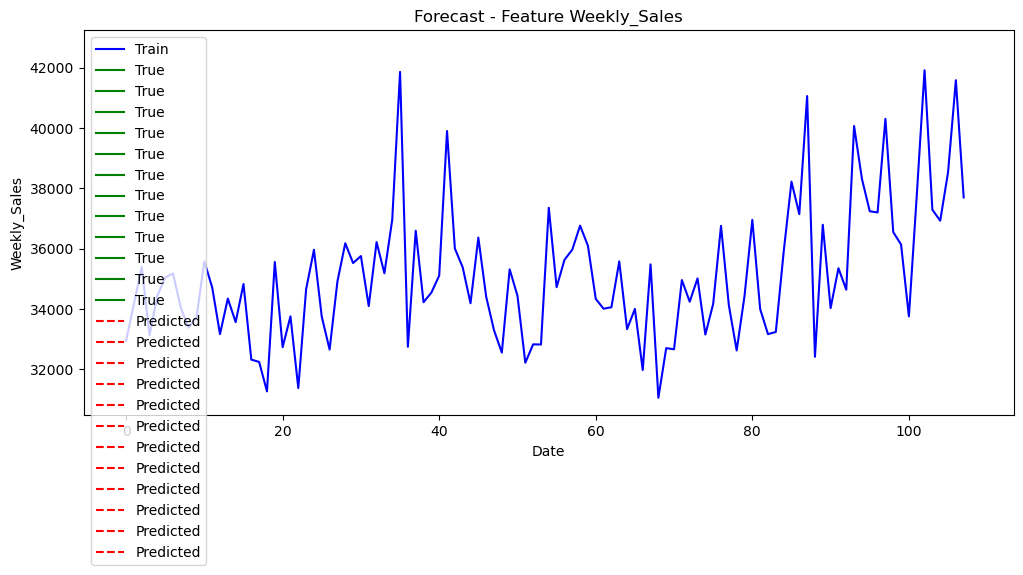

DTW distance (feature Weekly_Sales): 14029.6342


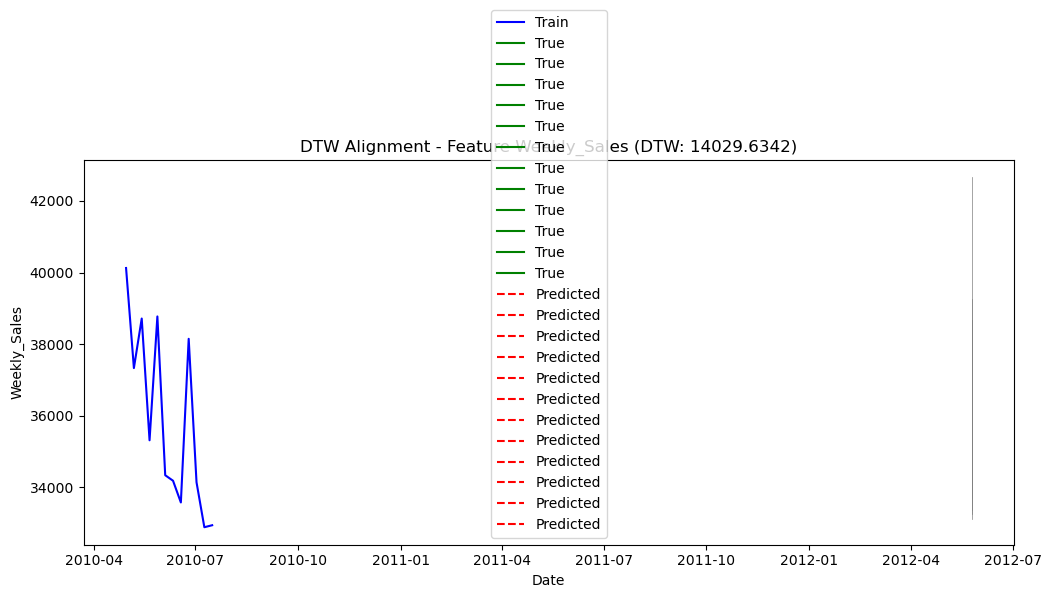

Results for CNN: {'rmse': 16402552.959888259, 'mae': 3426.777653860024, 'mape': 0.08847032021659505, 'dtw': 14029.634190479062}
✅ CNN completed. Results saved to outputs\CNN\window_12\direct\data


In [160]:
train_forecast_model(
    model_type="CNN",
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    train_dates=train_dates,
    test_dates=test_dates,
    scaler=scaler,
    features=features,
    predict_all=True,
    window_size=window_size,
    horizon=horizon,
    output_dir='outputs',
    use_gpu=True,
    model_kwargs={},
    fit_kwargs={
        "epochs": 200,
        "batch_size": 1,
        "validation_split": 0.2
    },
    target_only=True,
    feature_idx=0
)


Epoch 1/200
1/1 [==============================] - 0s 338ms/step - loss: 3.3468
Epoch 2/200
1/1 [==============================] - 0s 9ms/step - loss: 3.0868
Epoch 3/200
1/1 [==============================] - 0s 11ms/step - loss: 2.8412
Epoch 4/200
1/1 [==============================] - 0s 35ms/step - loss: 2.6111
Epoch 5/200
1/1 [==============================] - 0s 8ms/step - loss: 2.3967
Epoch 6/200
1/1 [==============================] - 0s 34ms/step - loss: 2.1975
Epoch 7/200
1/1 [==============================] - 0s 8ms/step - loss: 2.0133
Epoch 8/200
1/1 [==============================] - 0s 24ms/step - loss: 1.8407
Epoch 9/200
1/1 [==============================] - 0s 9ms/step - loss: 1.6784
Epoch 10/200
1/1 [==============================] - 0s 9ms/step - loss: 1.5271
Epoch 11/200
1/1 [==============================] - 0s 32ms/step - loss: 1.3860
Epoch 12/200
1/1 [==============================] - 0s 8ms/step - loss: 1.2546
Epoch 13/200
1/1 [==============================] - 0s

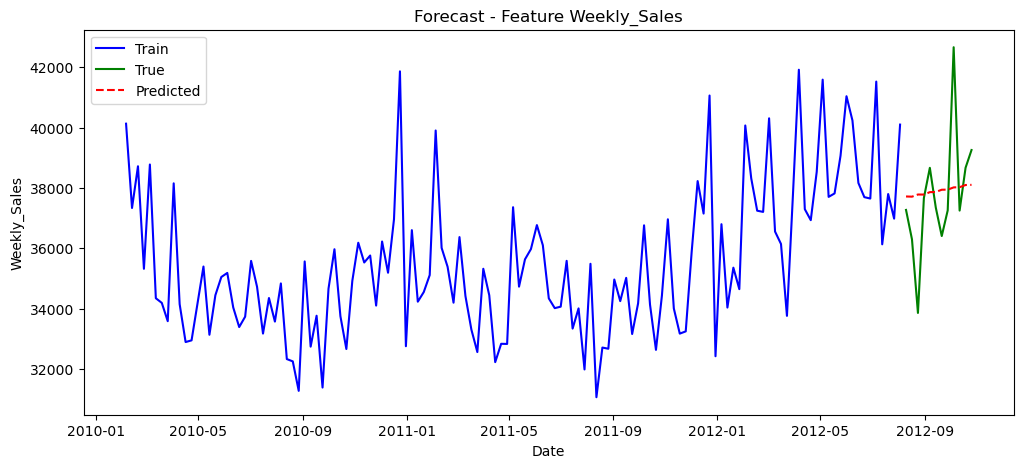

DTW distance (feature Weekly_Sales): 6668.7759


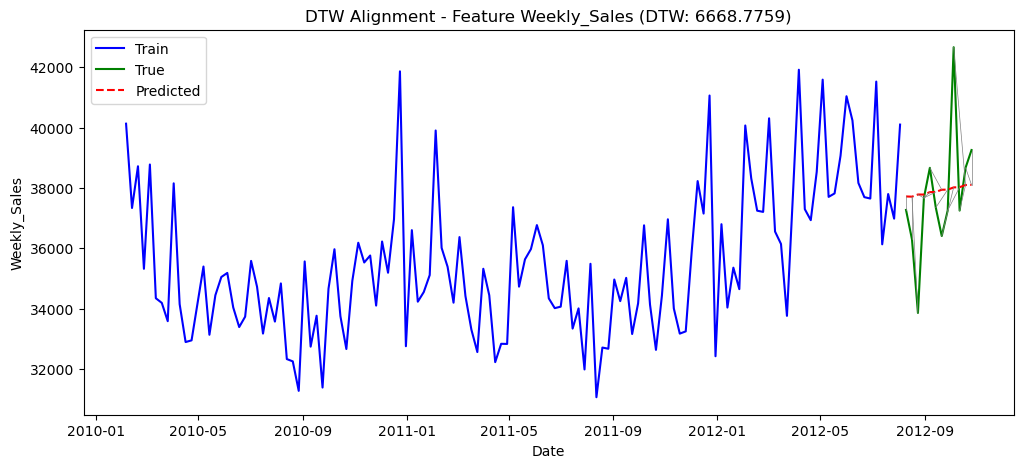

Recursive Results for CNN: {'rmse': 3769230.795650289, 'mae': 1383.1159760959883, 'mape': 0.03660380571156134, 'dtw': 6668.7759198061285}
✅ CNN completed. Results saved to outputs\CNN\no_window\recursive\data


In [126]:
train_forecast_model(
    model_type="CNN",
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    train_dates=train_dates,
    test_dates=test_dates,
    scaler=scaler,
    features=features,
    predict_all=False,
    horizon=horizon,
    output_dir='outputs',
    use_gpu=True,
    model_kwargs={},
    fit_kwargs={
        "epochs": 200,
        "batch_size": 1,
        "validation_split": 0
    },
    target_only=True,
    feature_idx=0
)


### Train with normalized data only

In [123]:
features = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
test_size = 12
horizon = 12
normalize = True

train_df, test_df, scaler, scaled_train, scaled_test = prepare_data(df, features, test_size=test_size, normalize=normalize)

X_train = scaled_train[np.newaxis, :, :]
y_train = scaled_test[np.newaxis, :, 0] 

X_test = X_train.copy() 
y_test = y_train.copy()

train_dates = df['Date'].iloc[:len(scaled_train)]
test_dates = df['Date'].iloc[-len(scaled_test):]


In [105]:
y_test.shape

(1, 12)

#### Prediction with all test at once

Epoch 1/200
1/1 [==============================] - 0s 294ms/step - loss: 1.3914
Epoch 2/200
1/1 [==============================] - 0s 8ms/step - loss: 1.3203
Epoch 3/200
1/1 [==============================] - 0s 23ms/step - loss: 1.2562
Epoch 4/200
1/1 [==============================] - 0s 14ms/step - loss: 1.1974
Epoch 5/200
1/1 [==============================] - 0s 38ms/step - loss: 1.1415
Epoch 6/200
1/1 [==============================] - 0s 8ms/step - loss: 1.0882
Epoch 7/200
1/1 [==============================] - 0s 27ms/step - loss: 1.0368
Epoch 8/200
1/1 [==============================] - 0s 14ms/step - loss: 0.9871
Epoch 9/200
1/1 [==============================] - 0s 35ms/step - loss: 0.9385
Epoch 10/200
1/1 [==============================] - 0s 8ms/step - loss: 0.8902
Epoch 11/200
1/1 [==============================] - 0s 31ms/step - loss: 0.8428
Epoch 12/200
1/1 [==============================] - 0s 9ms/step - loss: 0.7958
Epoch 13/200
1/1 [==============================] - 

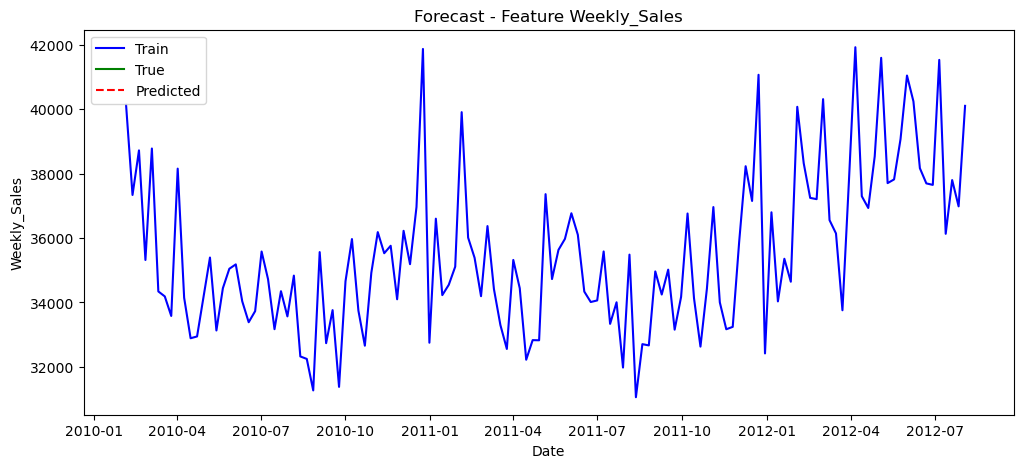

DTW distance (feature Weekly_Sales): 0.0288


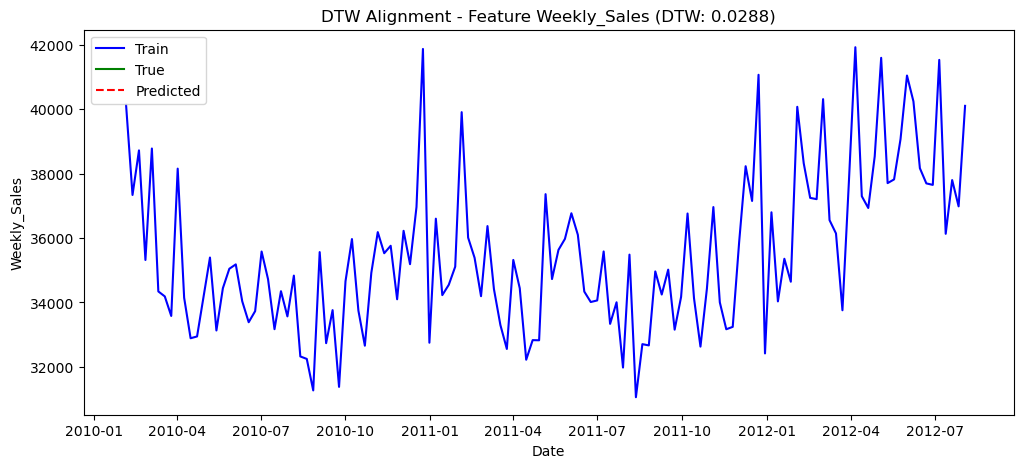

Results for CNN: {'rmse': 0.000831822155450045, 'mae': 0.028841327213740442, 'mape': 7.738499898508085e-07, 'dtw': 0.028841327213740442}
✅ CNN completed. Results saved to outputs\CNN\no_window\direct\data


In [96]:
train_forecast_model(
    model_type="CNN",
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    train_dates=train_dates,
    test_dates=test_dates,
    scaler=scaler,
    features=features,
    predict_all=True,
    horizon=horizon,
    output_dir='outputs',
    normalize=True,
    use_gpu=True,
    model_kwargs={},
    fit_kwargs={
        "epochs": 200,
        "batch_size": 1,
        "validation_split": 0
    },
    target_only=True,
    feature_idx=0
)


Epoch 1/200
1/1 [==============================] - 1s 692ms/step - loss: 1.8298
Epoch 2/200
1/1 [==============================] - 0s 121ms/step - loss: 1.5300
Epoch 3/200
1/1 [==============================] - 0s 109ms/step - loss: 1.2671
Epoch 4/200
1/1 [==============================] - 0s 98ms/step - loss: 1.0420
Epoch 5/200
1/1 [==============================] - 0s 106ms/step - loss: 0.8530
Epoch 6/200
1/1 [==============================] - 0s 104ms/step - loss: 0.6988
Epoch 7/200
1/1 [==============================] - 0s 106ms/step - loss: 0.5760
Epoch 8/200
1/1 [==============================] - 0s 109ms/step - loss: 0.4789
Epoch 9/200
1/1 [==============================] - 0s 89ms/step - loss: 0.4013
Epoch 10/200
1/1 [==============================] - 0s 89ms/step - loss: 0.3379
Epoch 11/200
1/1 [==============================] - 0s 127ms/step - loss: 0.2846
Epoch 12/200
1/1 [==============================] - 0s 125ms/step - loss: 0.2386
Epoch 13/200
1/1 [======================

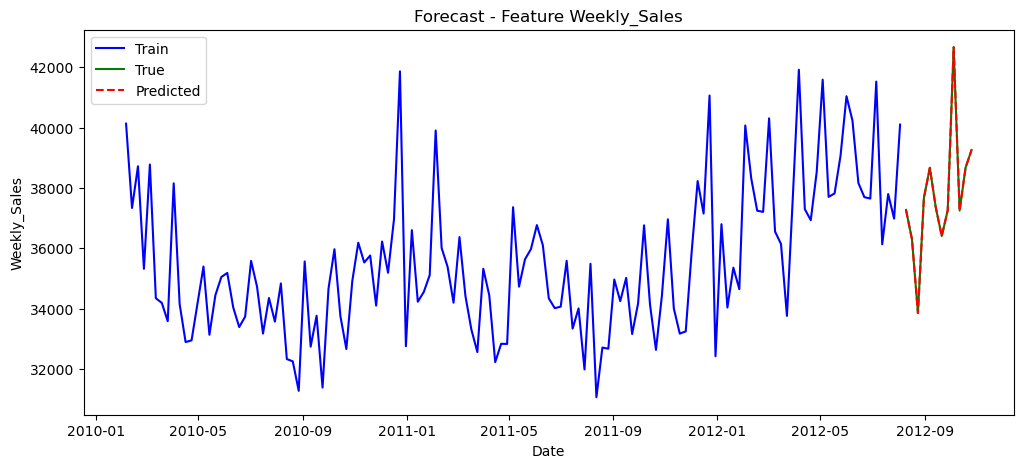

DTW distance (feature Weekly_Sales): 0.0759


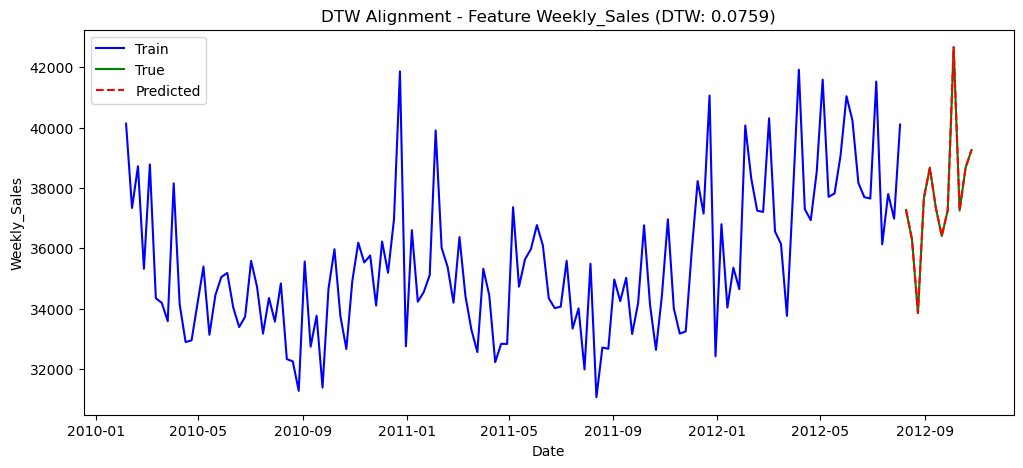

Results for RNN: {'rmse': 0.0004806611909246539, 'mae': 0.016667050611431478, 'mape': 4.497118328973668e-07}
✅ RNN completed. Results saved to outputs/RNN/direct_12


In [101]:
train_forecast_model(
    model_type="RNN",
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    train_dates=train_dates,
    test_dates=test_dates,
    scaler=scaler,
    features=features,
    predict_all=True,
    window_size=window_size,
    horizon=horizon,
    output_dir='outputs',
    normalize=True,
    use_gpu=True,
    model_kwargs={},
    fit_kwargs={
        "epochs": 200,
        "batch_size": 1,
        "validation_split": 0
    },
    target_only=True,
    feature_idx=0
)


Epoch 1/200
1/1 [==============================] - 2s 2s/step - loss: 1.3287
Epoch 2/200
1/1 [==============================] - 0s 56ms/step - loss: 1.2053
Epoch 3/200
1/1 [==============================] - 0s 45ms/step - loss: 1.0924
Epoch 4/200
1/1 [==============================] - 0s 56ms/step - loss: 0.9882
Epoch 5/200
1/1 [==============================] - 0s 24ms/step - loss: 0.8908
Epoch 6/200
1/1 [==============================] - 0s 13ms/step - loss: 0.7989
Epoch 7/200
1/1 [==============================] - 0s 12ms/step - loss: 0.7114
Epoch 8/200
1/1 [==============================] - 0s 12ms/step - loss: 0.6283
Epoch 9/200
1/1 [==============================] - 0s 11ms/step - loss: 0.5495
Epoch 10/200
1/1 [==============================] - 0s 11ms/step - loss: 0.4753
Epoch 11/200
1/1 [==============================] - 0s 12ms/step - loss: 0.4063
Epoch 12/200
1/1 [==============================] - 0s 13ms/step - loss: 0.3428
Epoch 13/200
1/1 [==============================] -

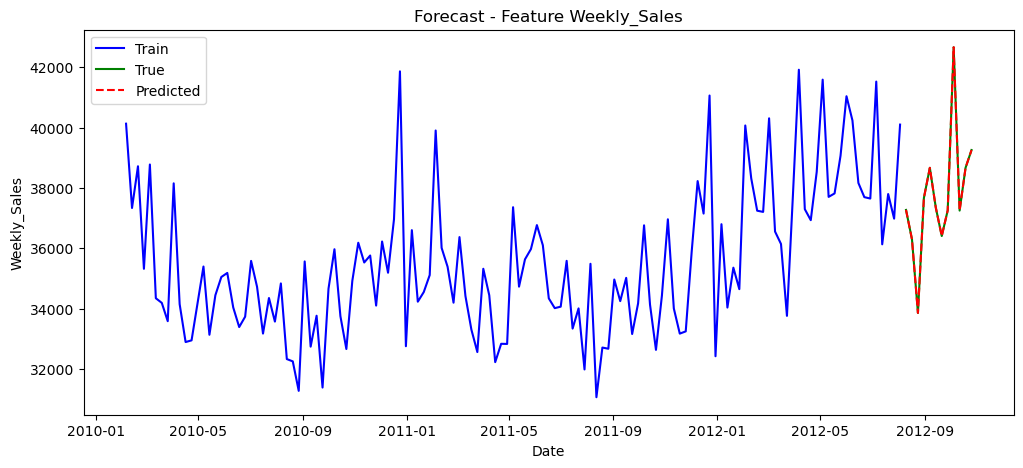

DTW distance (feature Weekly_Sales): 0.1330


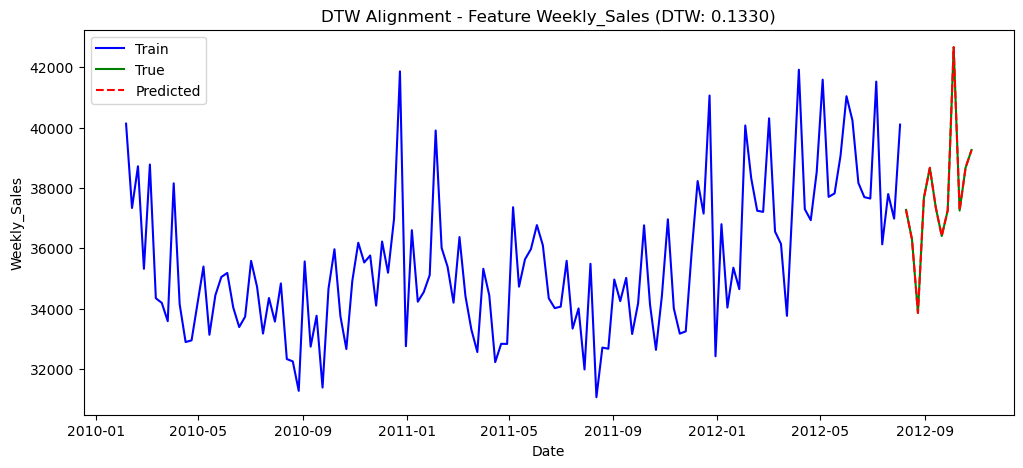

Results for LSTM: {'rmse': 0.0014743036046006, 'mae': 0.02541042268300468, 'mape': 6.518771903531748e-07}
✅ LSTM completed. Results saved to outputs/LSTM/direct_12


In [102]:
train_forecast_model(
    model_type="LSTM",
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    train_dates=train_dates,
    test_dates=test_dates,
    scaler=scaler,
    features=features,
    predict_all=True,
    window_size=window_size,
    horizon=horizon,
    output_dir='outputs',
    normalize=True,
    use_gpu=True,
    model_kwargs={},
    fit_kwargs={
        "epochs": 200,
        "batch_size": 1,
        "validation_split": 0
    },
    target_only=True,
    feature_idx=0
)


Epoch 1/200
1/1 [==============================] - 1s 1s/step - loss: 1.5511
Epoch 2/200
1/1 [==============================] - 0s 16ms/step - loss: 1.4226
Epoch 3/200
1/1 [==============================] - 0s 14ms/step - loss: 1.3002
Epoch 4/200
1/1 [==============================] - 0s 14ms/step - loss: 1.1838
Epoch 5/200
1/1 [==============================] - 0s 14ms/step - loss: 1.0730
Epoch 6/200
1/1 [==============================] - 0s 15ms/step - loss: 0.9677
Epoch 7/200
1/1 [==============================] - 0s 16ms/step - loss: 0.8677
Epoch 8/200
1/1 [==============================] - 0s 17ms/step - loss: 0.7731
Epoch 9/200
1/1 [==============================] - 0s 18ms/step - loss: 0.6838
Epoch 10/200
1/1 [==============================] - 0s 17ms/step - loss: 0.5999
Epoch 11/200
1/1 [==============================] - 0s 22ms/step - loss: 0.5213
Epoch 12/200
1/1 [==============================] - 0s 24ms/step - loss: 0.4483
Epoch 13/200
1/1 [==============================] -

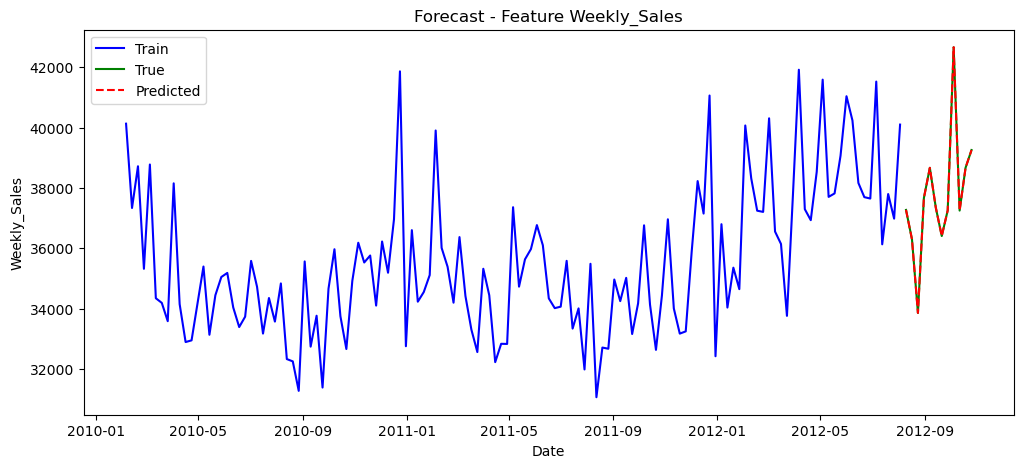

DTW distance (feature Weekly_Sales): 0.2060


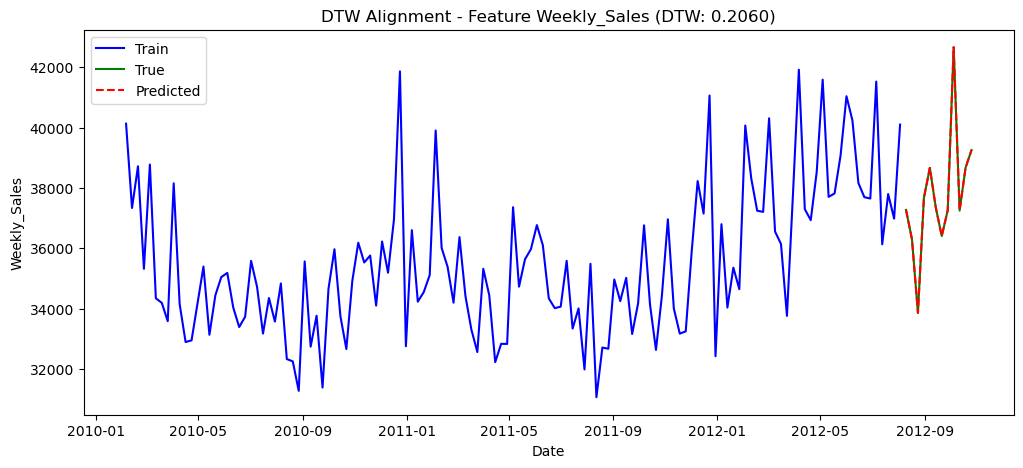

Results for GRU: {'rmse': 0.0035368183512213373, 'mae': 0.04625450379717222, 'mape': 1.1972431770783823e-06}
✅ GRU completed. Results saved to outputs/GRU/direct_12


In [103]:
train_forecast_model(
    model_type="GRU",
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    train_dates=train_dates,
    test_dates=test_dates,
    scaler=scaler,
    features=features,
    predict_all=True,
    window_size=window_size,
    horizon=horizon,
    output_dir='outputs',
    normalize=True,
    use_gpu=True,
    model_kwargs={},
    fit_kwargs={
        "epochs": 200,
        "batch_size": 1,
        "validation_split": 0
    },
    target_only=True,
    feature_idx=0
)


Epoch 1/200
1/1 [==============================] - 1s 630ms/step - loss: 1.5110
Epoch 2/200
1/1 [==============================] - 0s 13ms/step - loss: 1.0635
Epoch 3/200
1/1 [==============================] - 0s 10ms/step - loss: 0.6767
Epoch 4/200
1/1 [==============================] - 0s 11ms/step - loss: 0.3423
Epoch 5/200
1/1 [==============================] - 0s 9ms/step - loss: 0.2040
Epoch 6/200
1/1 [==============================] - 0s 9ms/step - loss: 0.2448
Epoch 7/200
1/1 [==============================] - 0s 9ms/step - loss: 0.1895
Epoch 8/200
1/1 [==============================] - 0s 9ms/step - loss: 0.0876
Epoch 9/200
1/1 [==============================] - 0s 9ms/step - loss: 0.0322
Epoch 10/200
1/1 [==============================] - 0s 9ms/step - loss: 0.0291
Epoch 11/200
1/1 [==============================] - 0s 10ms/step - loss: 0.0484
Epoch 12/200
1/1 [==============================] - 0s 10ms/step - loss: 0.0659
Epoch 13/200
1/1 [==============================] - 0s

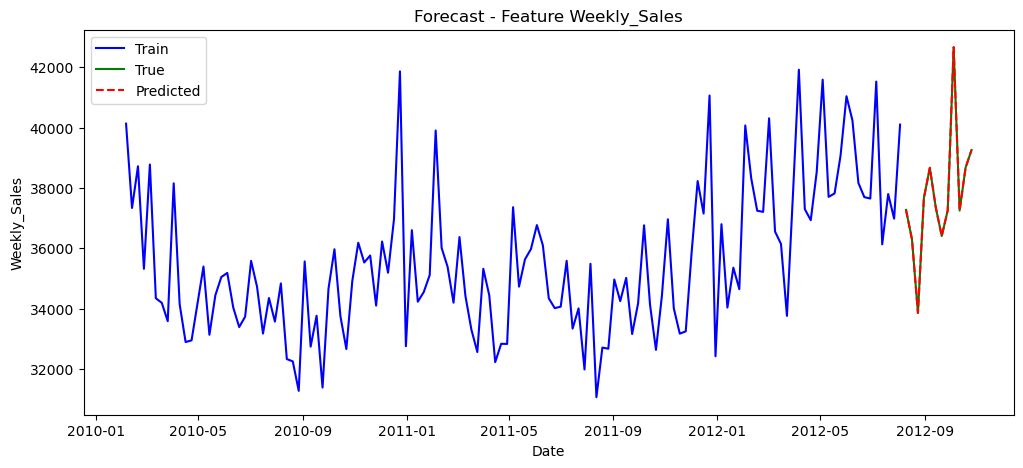

DTW distance (feature Weekly_Sales): 0.1228


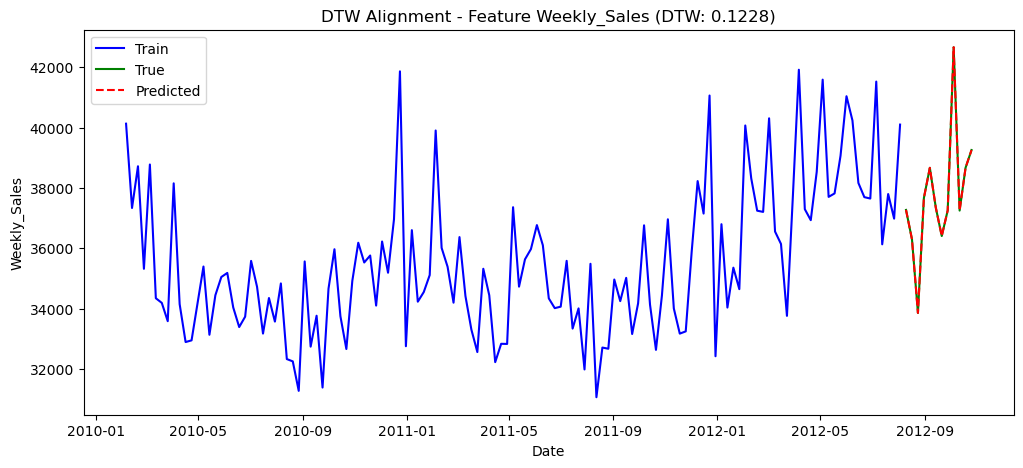

Results for FCN: {'rmse': 0.0012564672907310877, 'mae': 0.030921904179801157, 'mape': 8.005509919136527e-07}
✅ FCN completed. Results saved to outputs/FCN/direct_12


In [105]:
train_forecast_model(
    model_type="FCN",
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    train_dates=train_dates,
    test_dates=test_dates,
    scaler=scaler,
    features=features,
    predict_all=True,
    window_size=window_size,
    horizon=horizon,
    output_dir='outputs',
    normalize=True,
    use_gpu=True,
    model_kwargs={},
    fit_kwargs={
        "epochs": 200,
        "batch_size": 1,
        "validation_split": 0
    },
    target_only=True,
    feature_idx=0
)


Epoch 1/200
1/1 [==============================] - 0s 350ms/step - loss: 2.1082
Epoch 2/200
1/1 [==============================] - 0s 10ms/step - loss: 0.8538
Epoch 3/200
1/1 [==============================] - 0s 15ms/step - loss: 0.5886
Epoch 4/200
1/1 [==============================] - 0s 26ms/step - loss: 0.3917
Epoch 5/200
1/1 [==============================] - 0s 15ms/step - loss: 0.2252
Epoch 6/200
1/1 [==============================] - 0s 24ms/step - loss: 0.1181
Epoch 7/200
1/1 [==============================] - 0s 26ms/step - loss: 0.0772
Epoch 8/200
1/1 [==============================] - 0s 17ms/step - loss: 0.0565
Epoch 9/200
1/1 [==============================] - 0s 11ms/step - loss: 0.0674
Epoch 10/200
1/1 [==============================] - 0s 18ms/step - loss: 0.0949
Epoch 11/200
1/1 [==============================] - 0s 15ms/step - loss: 0.1040
Epoch 12/200
1/1 [==============================] - 0s 10ms/step - loss: 0.0905
Epoch 13/200
1/1 [==============================

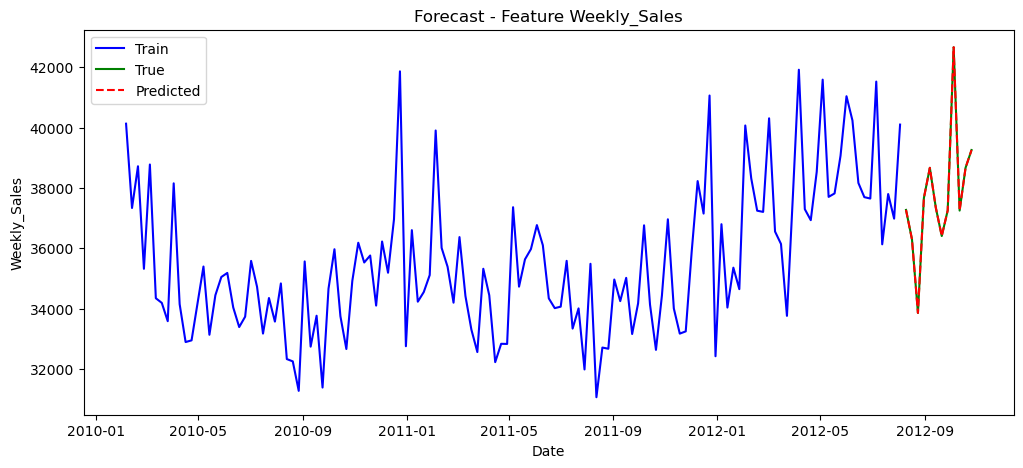

DTW distance (feature Weekly_Sales): 0.1150


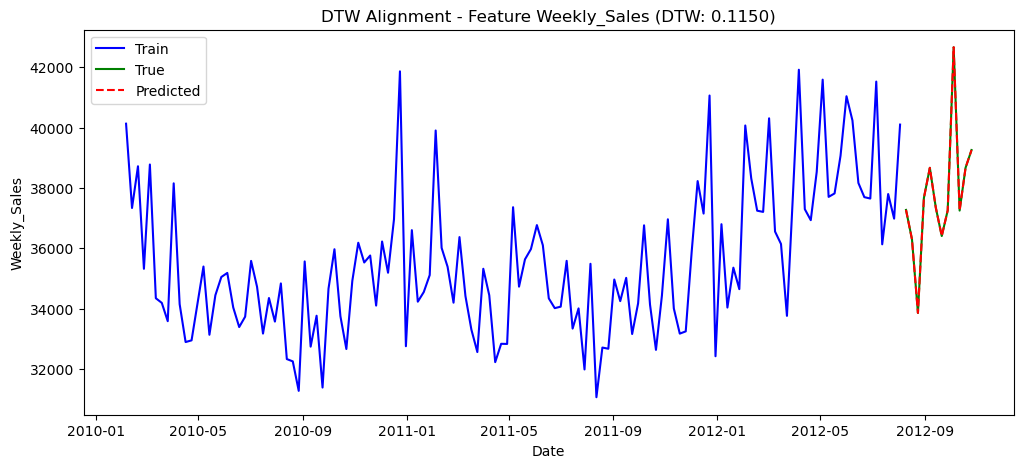

Results for ANN: {'rmse': 0.001103040750681564, 'mae': 0.027395554915225755, 'mape': 7.283777462847124e-07}
✅ ANN completed. Results saved to outputs/ANN/direct_12


In [106]:
train_forecast_model(
    model_type="ANN",
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    train_dates=train_dates,
    test_dates=test_dates,
    scaler=scaler,
    features=features,
    predict_all=True,
    window_size=window_size,
    horizon=horizon,
    output_dir='outputs',
    normalize=True,
    use_gpu=True,
    model_kwargs={},
    fit_kwargs={
        "epochs": 200,
        "batch_size": 1,
        "validation_split": 0
    },
    target_only=True,
    feature_idx=0
)


Epoch 1/200
1/1 [==============================] - 2s 2s/step - loss: 1.6345
Epoch 2/200
1/1 [==============================] - 0s 21ms/step - loss: 1.4335
Epoch 3/200
1/1 [==============================] - 0s 18ms/step - loss: 1.2535
Epoch 4/200
1/1 [==============================] - 0s 21ms/step - loss: 1.0903
Epoch 5/200
1/1 [==============================] - 0s 16ms/step - loss: 0.9408
Epoch 6/200
1/1 [==============================] - 0s 19ms/step - loss: 0.8027
Epoch 7/200
1/1 [==============================] - 0s 16ms/step - loss: 0.6753
Epoch 8/200
1/1 [==============================] - 0s 19ms/step - loss: 0.5583
Epoch 9/200
1/1 [==============================] - 0s 18ms/step - loss: 0.4518
Epoch 10/200
1/1 [==============================] - 0s 17ms/step - loss: 0.3563
Epoch 11/200
1/1 [==============================] - 0s 12ms/step - loss: 0.2728
Epoch 12/200
1/1 [==============================] - 0s 13ms/step - loss: 0.2018
Epoch 13/200
1/1 [==============================] -

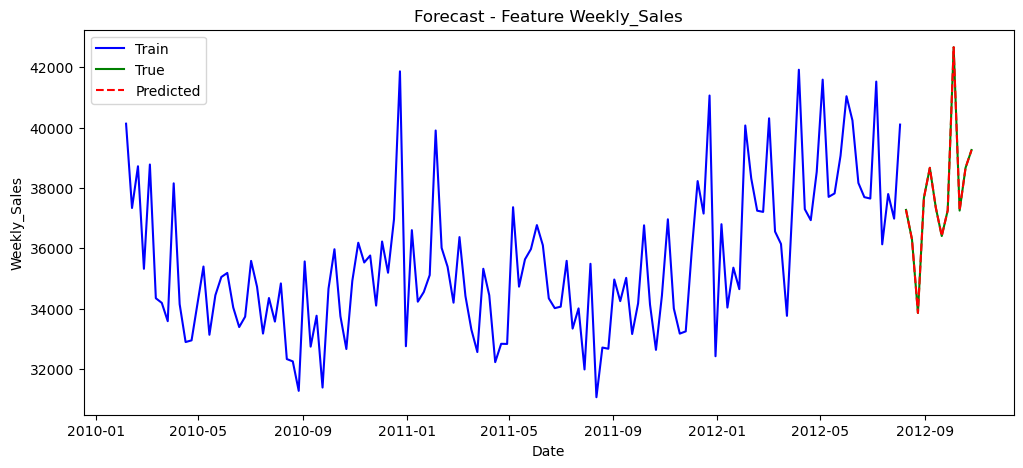

DTW distance (feature Weekly_Sales): 0.1274


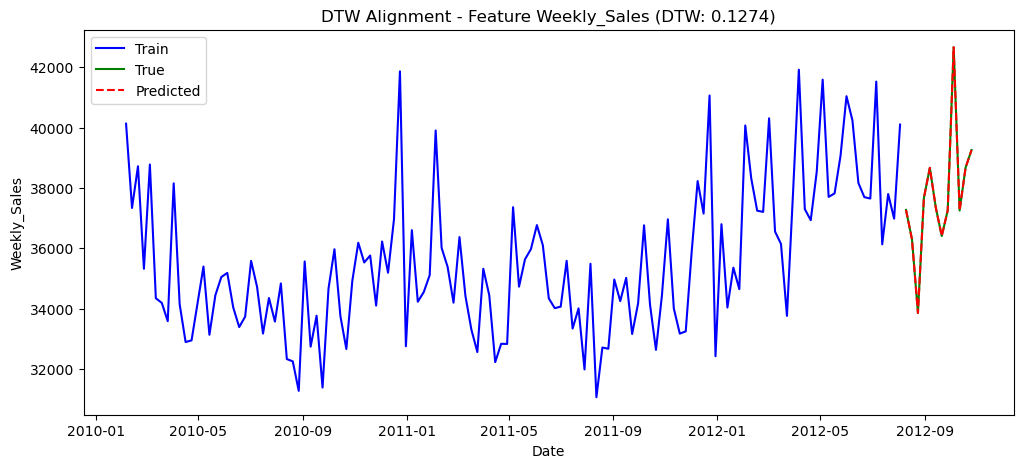

Results for CNN-LSTM: {'rmse': 0.0013519489273859256, 'mae': 0.029619909394265658, 'mape': 7.867647875800774e-07}
✅ CNN-LSTM completed. Results saved to outputs/CNN-LSTM/direct_12


In [107]:
train_forecast_model(
    model_type="CNN-LSTM",
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    train_dates=train_dates,
    test_dates=test_dates,
    scaler=scaler,
    features=features,
    predict_all=True,
    window_size=window_size,
    horizon=horizon,
    output_dir='outputs',
    normalize=True,
    use_gpu=True,
    model_kwargs={},
    fit_kwargs={
        "epochs": 200,
        "batch_size": 1,
        "validation_split": 0
    },
    target_only=True,
    feature_idx=0
)


Epoch 1/200
1/1 [==============================] - 0s 416ms/step - loss: 1.0932
Epoch 2/200
1/1 [==============================] - 0s 15ms/step - loss: 0.4976
Epoch 3/200
1/1 [==============================] - 0s 60ms/step - loss: 0.1368
Epoch 4/200
1/1 [==============================] - 0s 14ms/step - loss: 0.1295
Epoch 5/200
1/1 [==============================] - 0s 75ms/step - loss: 0.0621
Epoch 6/200
1/1 [==============================] - 0s 14ms/step - loss: 0.0433
Epoch 7/200
1/1 [==============================] - 0s 68ms/step - loss: 0.0537
Epoch 8/200
1/1 [==============================] - 0s 10ms/step - loss: 0.0288
Epoch 9/200
1/1 [==============================] - 0s 10ms/step - loss: 0.0154
Epoch 10/200
1/1 [==============================] - 0s 8ms/step - loss: 0.0342
Epoch 11/200
1/1 [==============================] - 0s 9ms/step - loss: 0.0196
Epoch 12/200
1/1 [==============================] - 0s 9ms/step - loss: 0.0044
Epoch 13/200
1/1 [==============================] -

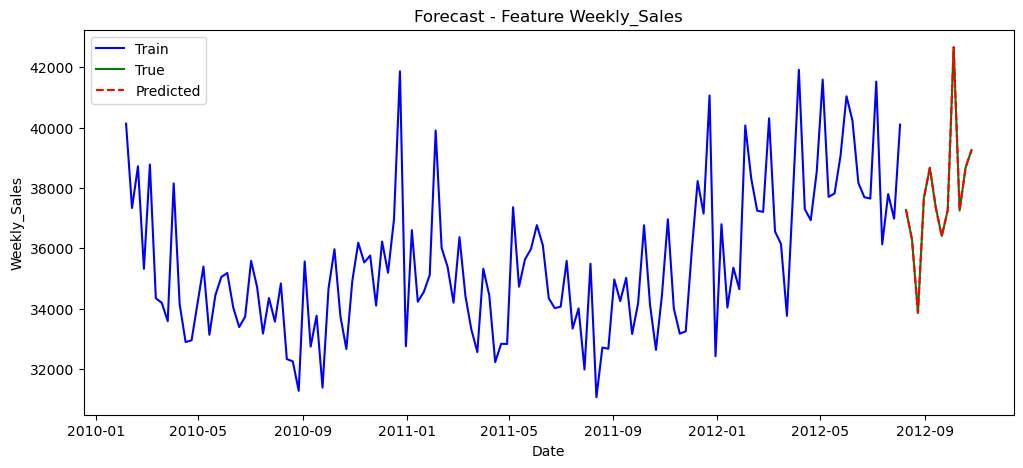

DTW distance (feature Weekly_Sales): 13.0568


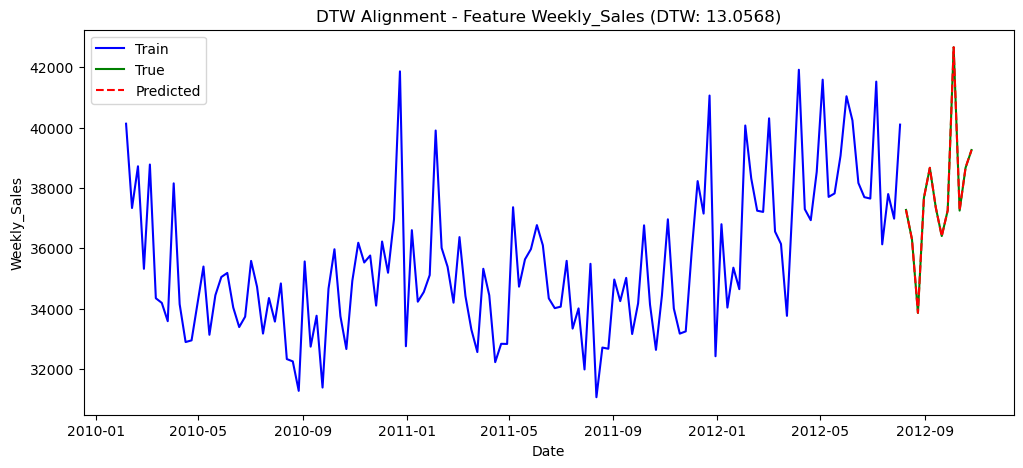

Results for NBEATS: {'rmse': 14.206624932270584, 'mae': 2.932899990983666, 'mape': 7.902125526258922e-05}
✅ NBEATS completed. Results saved to outputs/NBEATS/direct_12


In [108]:
train_forecast_model(
    model_type="NBEATS",
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    train_dates=train_dates,
    test_dates=test_dates,
    scaler=scaler,
    features=features,
    predict_all=True,
    window_size=window_size,
    horizon=horizon,
    output_dir='outputs',
    normalize=True,
    use_gpu=True,
    model_kwargs={},
    fit_kwargs={
        "epochs": 200,
        "batch_size": 1,
        "validation_split": 0
    },
    target_only=True,
    feature_idx=0
)


In [125]:
features = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
test_size = 12
horizon = 12
normalize = True

train_df, test_df, scaler, scaled_train, scaled_test = prepare_data(df, features, test_size=test_size, normalize=normalize)

X_train = scaled_train[np.newaxis, :, :]
y_train = scaled_test[np.newaxis, :, :] 

X_test = X_train.copy() 
y_test = scaled_test

train_dates = df['Date'].iloc[:len(scaled_train)]
test_dates = df['Date'].iloc[-len(scaled_test):]


#### Prediction with recursive type 

Epoch 1/200
1/1 [==============================] - 0s 329ms/step - loss: 3.6505
Epoch 2/200
1/1 [==============================] - 0s 10ms/step - loss: 3.3973
Epoch 3/200
1/1 [==============================] - 0s 16ms/step - loss: 3.1580
Epoch 4/200
1/1 [==============================] - 0s 46ms/step - loss: 2.9280
Epoch 5/200
1/1 [==============================] - 0s 9ms/step - loss: 2.7058
Epoch 6/200
1/1 [==============================] - 0s 10ms/step - loss: 2.4884
Epoch 7/200
1/1 [==============================] - 0s 11ms/step - loss: 2.2807
Epoch 8/200
1/1 [==============================] - 0s 11ms/step - loss: 2.0861
Epoch 9/200
1/1 [==============================] - 0s 16ms/step - loss: 1.9058
Epoch 10/200
1/1 [==============================] - 0s 9ms/step - loss: 1.7386
Epoch 11/200
1/1 [==============================] - 0s 7ms/step - loss: 1.5832
Epoch 12/200
1/1 [==============================] - 0s 7ms/step - loss: 1.4399
Epoch 13/200
1/1 [==============================] - 

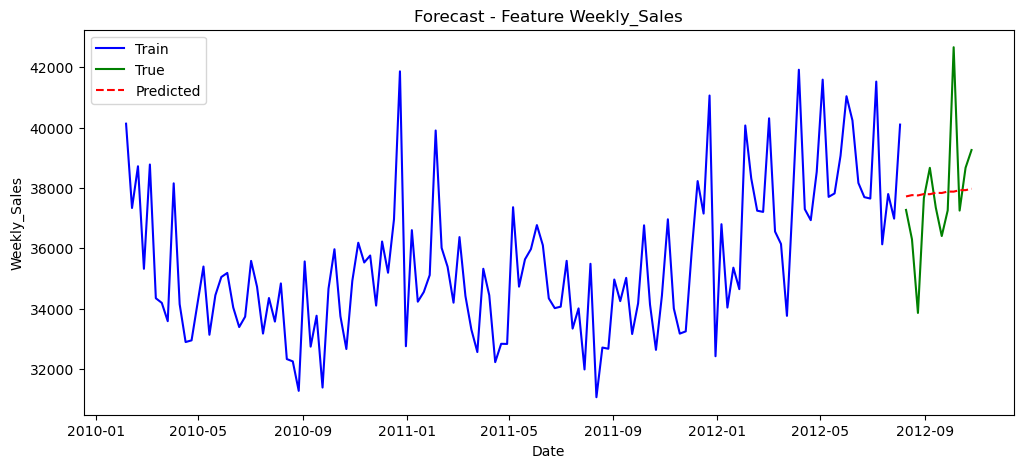

DTW distance (feature Weekly_Sales): 6750.1474


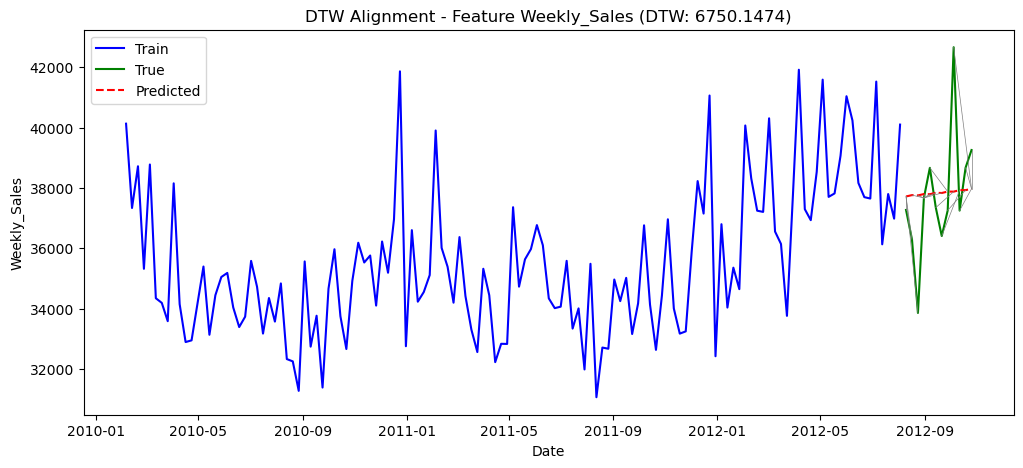

Recursive Results for CNN: {'rmse': 3879478.699270085, 'mae': 1403.8134401329341, 'mape': 0.03707562526897113, 'dtw': 6750.147378069678}
✅ CNN completed. Results saved to outputs\CNN\no_window\recursive\data


In [98]:
train_forecast_model(
    model_type="CNN",
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    train_dates=train_dates,
    test_dates=test_dates,
    scaler=scaler,
    features=features,
    predict_all=False,
    horizon=horizon,
    output_dir='outputs',
    use_gpu=True,
    model_kwargs={},
    fit_kwargs={
        "epochs": 200,
        "batch_size": 1,
        "validation_split": 0
    },
    target_only=True,
    feature_idx=0
)


Epoch 1/200
1/1 [==============================] - 1s 674ms/step - loss: 2.7882
Epoch 2/200
1/1 [==============================] - 0s 103ms/step - loss: 2.2103
Epoch 3/200
1/1 [==============================] - 0s 91ms/step - loss: 1.7372
Epoch 4/200
1/1 [==============================] - 0s 70ms/step - loss: 1.3495
Epoch 5/200
1/1 [==============================] - 0s 71ms/step - loss: 1.0389
Epoch 6/200
1/1 [==============================] - 0s 64ms/step - loss: 0.7971
Epoch 7/200
1/1 [==============================] - 0s 62ms/step - loss: 0.6142
Epoch 8/200
1/1 [==============================] - 0s 66ms/step - loss: 0.4810
Epoch 9/200
1/1 [==============================] - 0s 62ms/step - loss: 0.3893
Epoch 10/200
1/1 [==============================] - 0s 68ms/step - loss: 0.3313
Epoch 11/200
1/1 [==============================] - 0s 79ms/step - loss: 0.2992
Epoch 12/200
1/1 [==============================] - 0s 71ms/step - loss: 0.2857
Epoch 13/200
1/1 [=============================

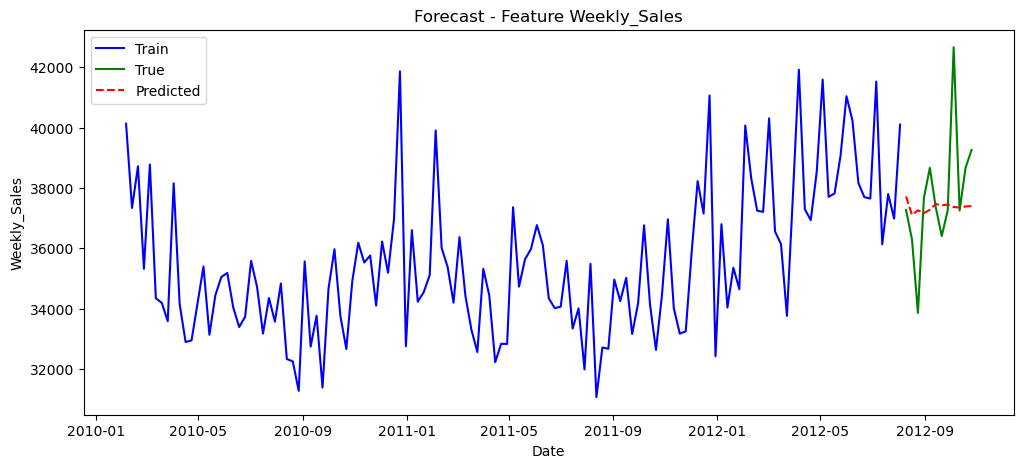

DTW distance (feature Weekly_Sales): 6807.3220


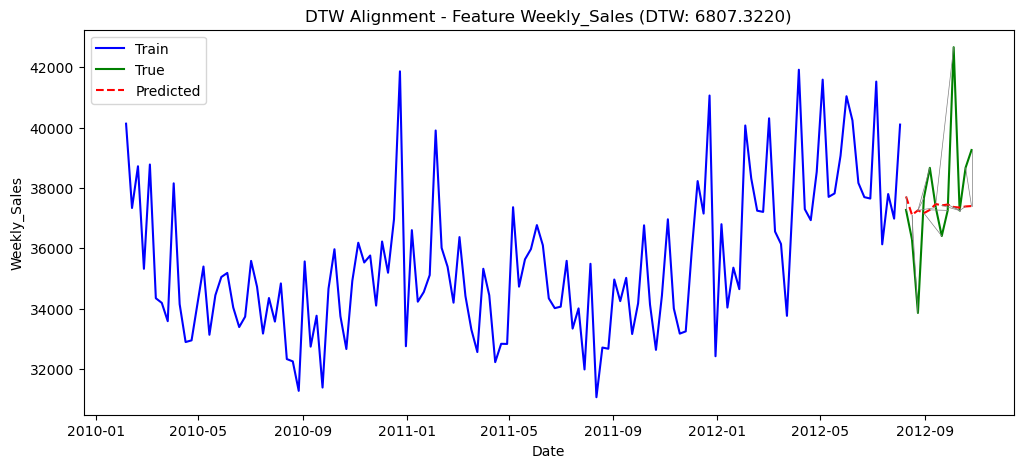

Recursive Results for RNN: {'rmse': 4072312.5394433215, 'mae': 1368.7080918819884, 'mape': 0.035658116241100025, 'dtw': 6807.322028372819}
✅ RNN completed. Results saved to outputs\RNN\no_window\recursive\data


In [58]:
train_forecast_model(
    model_type="RNN",
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    train_dates=train_dates,
    test_dates=test_dates,
    scaler=scaler,
    features=features,
    predict_all=False,
    horizon=horizon,
    output_dir='outputs',
    use_gpu=True,
    model_kwargs={},
    fit_kwargs={
        "epochs": 200,
        "batch_size": 1,
        "validation_split": 0
    },
    target_only=True,
    feature_idx=0
)


Epoch 1/200
1/1 [==============================] - 2s 2s/step - loss: 2.4744
Epoch 2/200
1/1 [==============================] - 0s 50ms/step - loss: 2.2141
Epoch 3/200
1/1 [==============================] - 0s 20ms/step - loss: 1.9730
Epoch 4/200
1/1 [==============================] - 0s 43ms/step - loss: 1.7475
Epoch 5/200
1/1 [==============================] - 0s 21ms/step - loss: 1.5350
Epoch 6/200
1/1 [==============================] - 0s 65ms/step - loss: 1.3342
Epoch 7/200
1/1 [==============================] - 0s 14ms/step - loss: 1.1451
Epoch 8/200
1/1 [==============================] - 0s 10ms/step - loss: 0.9682
Epoch 9/200
1/1 [==============================] - 0s 12ms/step - loss: 0.8053
Epoch 10/200
1/1 [==============================] - 0s 14ms/step - loss: 0.6585
Epoch 11/200
1/1 [==============================] - 0s 14ms/step - loss: 0.5310
Epoch 12/200
1/1 [==============================] - 0s 17ms/step - loss: 0.4259
Epoch 13/200
1/1 [==============================] -

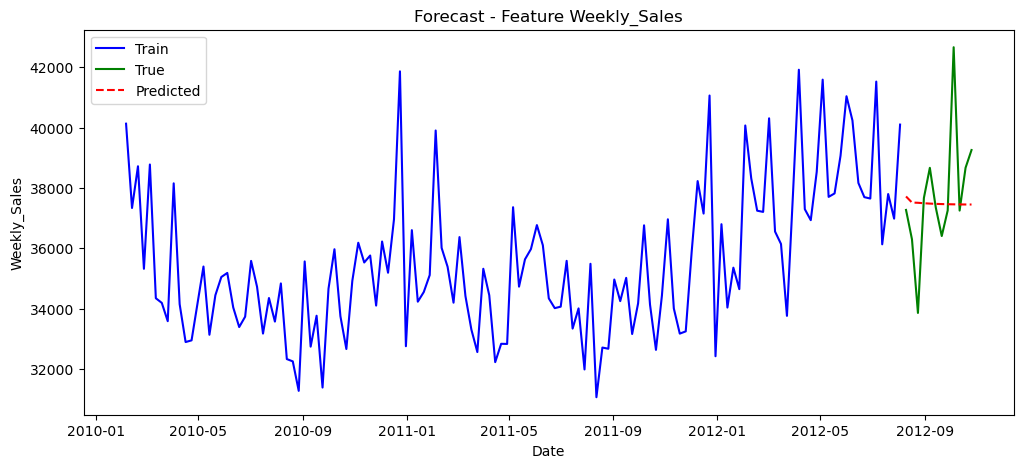

DTW distance (feature Weekly_Sales): 7026.7528


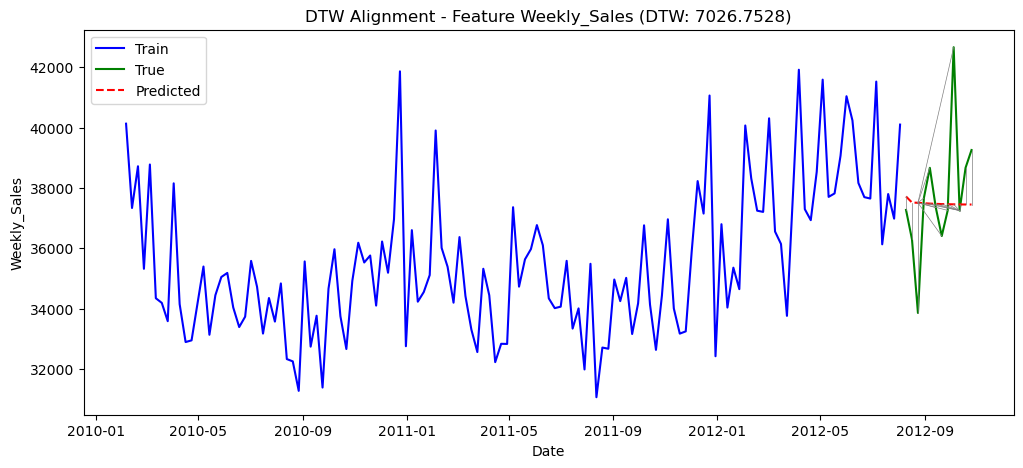

Recursive Results for LSTM: {'rmse': 4129746.2398640565, 'mae': 1375.3847362077256, 'mape': 0.035981354842274736, 'dtw': 7026.752805157235}
✅ LSTM completed. Results saved to outputs\LSTM\no_window\recursive\data


In [59]:
train_forecast_model(
    model_type="LSTM",
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    train_dates=train_dates,
    test_dates=test_dates,
    scaler=scaler,
    features=features,
    predict_all=False,
    horizon=horizon,
    output_dir='outputs',
    use_gpu=True,
    model_kwargs={},
    fit_kwargs={
        "epochs": 200,
        "batch_size": 1,
        "validation_split": 0
    },
    target_only=True,
    feature_idx=0
)


Epoch 1/200
1/1 [==============================] - 1s 1s/step - loss: 1.9053
Epoch 2/200
1/1 [==============================] - 0s 18ms/step - loss: 1.6936
Epoch 3/200
1/1 [==============================] - 0s 43ms/step - loss: 1.4942
Epoch 4/200
1/1 [==============================] - 0s 18ms/step - loss: 1.3074
Epoch 5/200
1/1 [==============================] - 0s 30ms/step - loss: 1.1337
Epoch 6/200
1/1 [==============================] - 0s 31ms/step - loss: 0.9735
Epoch 7/200
1/1 [==============================] - 0s 49ms/step - loss: 0.8272
Epoch 8/200
1/1 [==============================] - 0s 9ms/step - loss: 0.6957
Epoch 9/200
1/1 [==============================] - 0s 8ms/step - loss: 0.5796
Epoch 10/200
1/1 [==============================] - 0s 10ms/step - loss: 0.4798
Epoch 11/200
1/1 [==============================] - 0s 11ms/step - loss: 0.3971
Epoch 12/200
1/1 [==============================] - 0s 10ms/step - loss: 0.3324
Epoch 13/200
1/1 [==============================] - 0

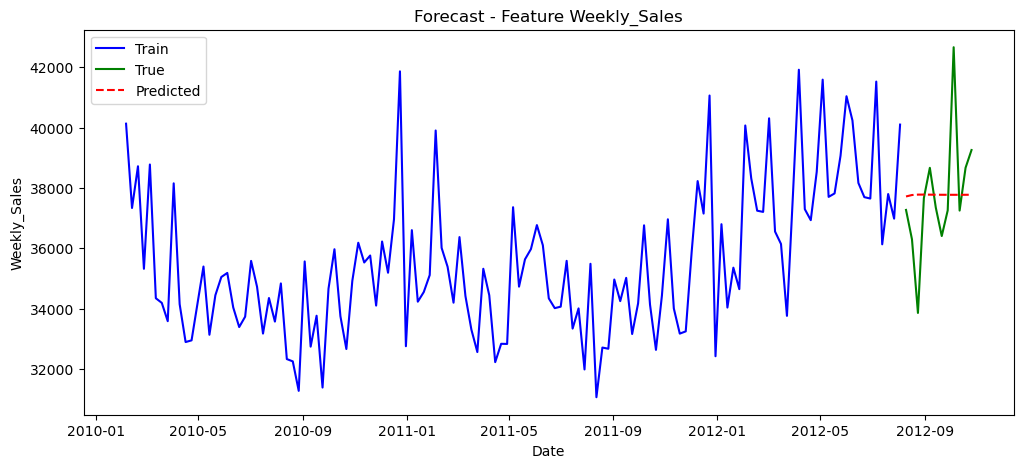

DTW distance (feature Weekly_Sales): 6891.0048


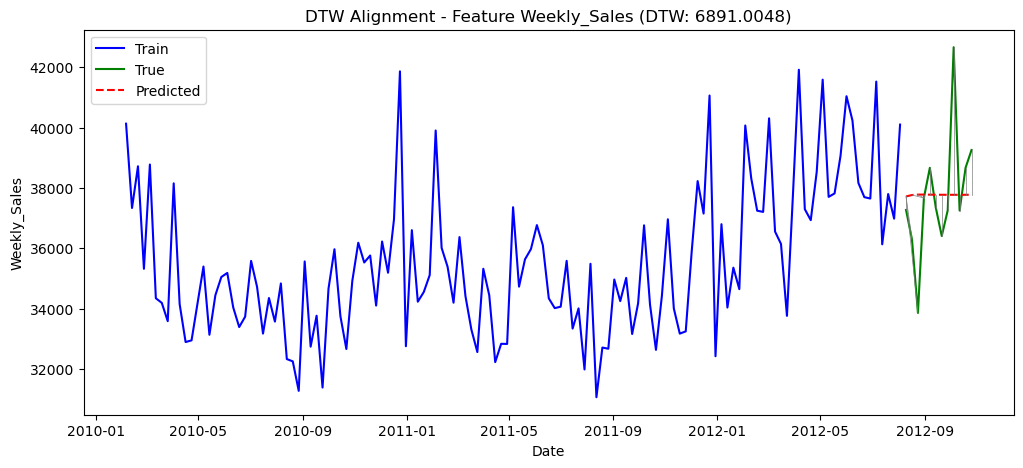

Recursive Results for GRU: {'rmse': 4006652.111578424, 'mae': 1412.201209485209, 'mape': 0.037238257594765026, 'dtw': 6891.00478180524}
✅ GRU completed. Results saved to outputs\GRU\no_window\recursive\data


In [60]:
train_forecast_model(
    model_type="GRU",
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    train_dates=train_dates,
    test_dates=test_dates,
    scaler=scaler,
    features=features,
    predict_all=False,
    horizon=horizon,
    output_dir='outputs',
    use_gpu=True,
    model_kwargs={},
    fit_kwargs={
        "epochs": 200,
        "batch_size": 1,
        "validation_split": 0
    },
    target_only=True,
    feature_idx=0
)


Epoch 1/200
1/1 [==============================] - 1s 1s/step - loss: 2.9495
Epoch 2/200
1/1 [==============================] - 0s 6ms/step - loss: 1.9334
Epoch 3/200
1/1 [==============================] - 0s 6ms/step - loss: 1.0096
Epoch 4/200
1/1 [==============================] - 0s 9ms/step - loss: 0.3345
Epoch 5/200
1/1 [==============================] - 0s 6ms/step - loss: 0.5840
Epoch 6/200
1/1 [==============================] - 0s 7ms/step - loss: 0.8025
Epoch 7/200
1/1 [==============================] - 0s 8ms/step - loss: 0.5118
Epoch 8/200
1/1 [==============================] - 0s 8ms/step - loss: 0.2857
Epoch 9/200
1/1 [==============================] - 0s 8ms/step - loss: 0.2725
Epoch 10/200
1/1 [==============================] - 0s 7ms/step - loss: 0.3579
Epoch 11/200
1/1 [==============================] - 0s 6ms/step - loss: 0.4315
Epoch 12/200
1/1 [==============================] - 0s 7ms/step - loss: 0.4518
Epoch 13/200
1/1 [==============================] - 0s 7ms/ste

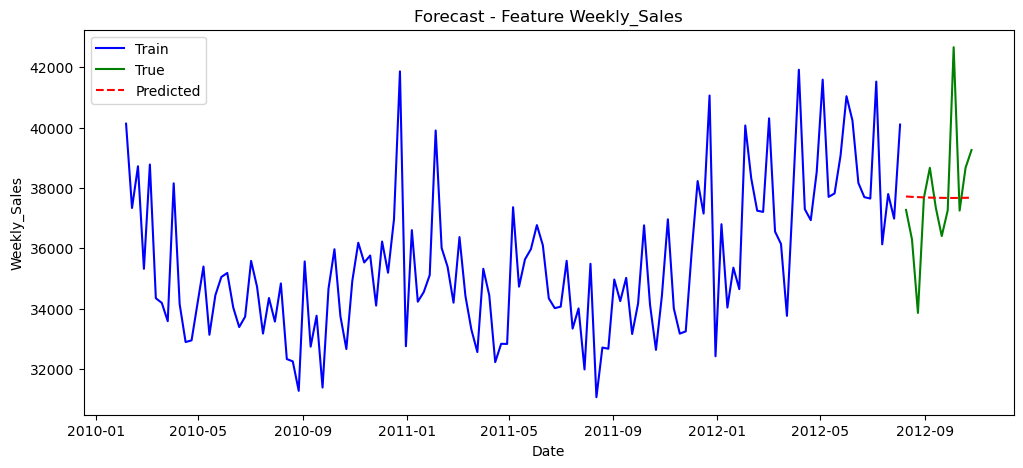

DTW distance (feature Weekly_Sales): 6953.3314


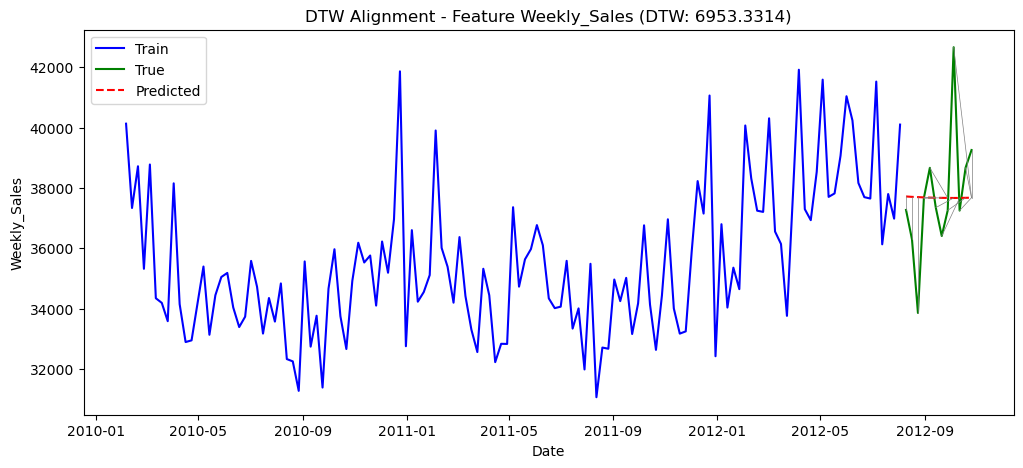

Recursive Results for FCN: {'rmse': 4035292.160099929, 'mae': 1391.6466968821799, 'mape': 0.03660500658318853, 'dtw': 6953.331364463752}
✅ FCN completed. Results saved to outputs\FCN\no_window\recursive\data


In [61]:
train_forecast_model(
    model_type="FCN",
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    train_dates=train_dates,
    test_dates=test_dates,
    scaler=scaler,
    features=features,
    predict_all=False,
    horizon=horizon,
    output_dir='outputs',
    use_gpu=True,
    model_kwargs={},
    fit_kwargs={
        "epochs": 200,
        "batch_size": 1,
        "validation_split": 0
    },
    target_only=True,
    feature_idx=0
)


Epoch 1/200
1/1 [==============================] - 0s 248ms/step - loss: 5.0373
Epoch 2/200
1/1 [==============================] - 0s 8ms/step - loss: 2.2675
Epoch 3/200
1/1 [==============================] - 0s 12ms/step - loss: 1.0971
Epoch 4/200
1/1 [==============================] - 0s 15ms/step - loss: 0.5295
Epoch 5/200
1/1 [==============================] - 0s 13ms/step - loss: 0.3127
Epoch 6/200
1/1 [==============================] - 0s 12ms/step - loss: 0.3435
Epoch 7/200
1/1 [==============================] - 0s 13ms/step - loss: 0.4487
Epoch 8/200
1/1 [==============================] - 0s 13ms/step - loss: 0.5026
Epoch 9/200
1/1 [==============================] - 0s 13ms/step - loss: 0.5086
Epoch 10/200
1/1 [==============================] - 0s 13ms/step - loss: 0.4789
Epoch 11/200
1/1 [==============================] - 0s 13ms/step - loss: 0.4223
Epoch 12/200
1/1 [==============================] - 0s 15ms/step - loss: 0.3533
Epoch 13/200
1/1 [==============================]

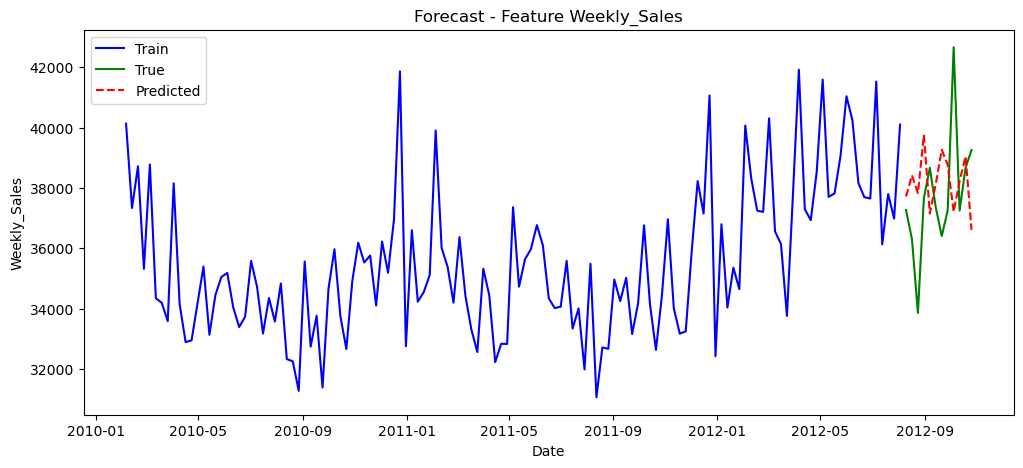

DTW distance (feature Weekly_Sales): 6183.4695


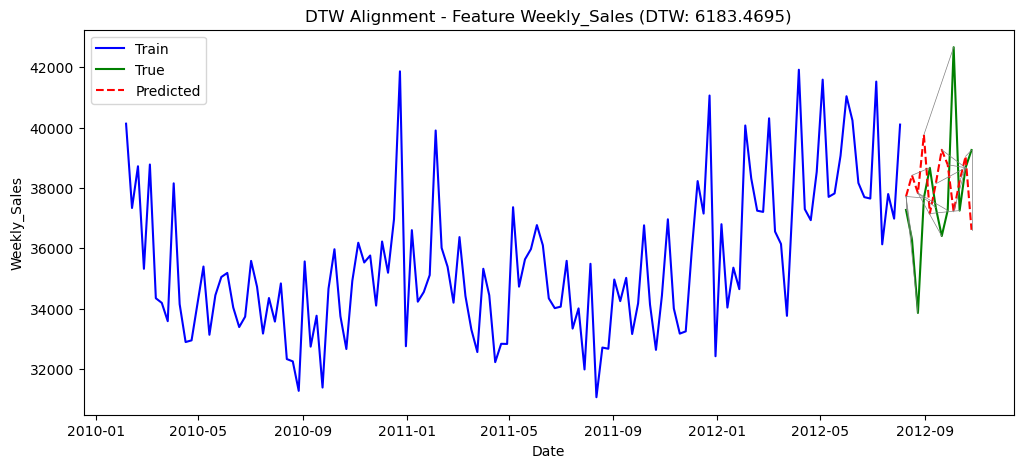

Recursive Results for ANN: {'rmse': 6343641.383526237, 'mae': 2064.416073596705, 'mape': 0.054521834441593635, 'dtw': 6183.469495121949}
✅ ANN completed. Results saved to outputs\ANN\no_window\recursive\data


In [62]:
train_forecast_model(
    model_type="ANN",
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    train_dates=train_dates,
    test_dates=test_dates,
    scaler=scaler,
    features=features,
    predict_all=False,
    horizon=horizon,
    output_dir='outputs',
    use_gpu=True,
    model_kwargs={},
    fit_kwargs={
        "epochs": 200,
        "batch_size": 1,
        "validation_split": 0
    },
    target_only=True,
    feature_idx=0
)


Epoch 1/200
1/1 [==============================] - 1s 1s/step - loss: 2.6336
Epoch 2/200
1/1 [==============================] - 0s 28ms/step - loss: 2.2050
Epoch 3/200
1/1 [==============================] - 0s 44ms/step - loss: 1.8171
Epoch 4/200
1/1 [==============================] - 0s 18ms/step - loss: 1.4709
Epoch 5/200
1/1 [==============================] - 0s 33ms/step - loss: 1.1693
Epoch 6/200
1/1 [==============================] - 0s 19ms/step - loss: 0.9156
Epoch 7/200
1/1 [==============================] - 0s 20ms/step - loss: 0.7121
Epoch 8/200
1/1 [==============================] - 0s 23ms/step - loss: 0.5576
Epoch 9/200
1/1 [==============================] - 0s 31ms/step - loss: 0.4467
Epoch 10/200
1/1 [==============================] - 0s 19ms/step - loss: 0.3713
Epoch 11/200
1/1 [==============================] - 0s 17ms/step - loss: 0.3233
Epoch 12/200
1/1 [==============================] - 0s 26ms/step - loss: 0.2950
Epoch 13/200
1/1 [==============================] -

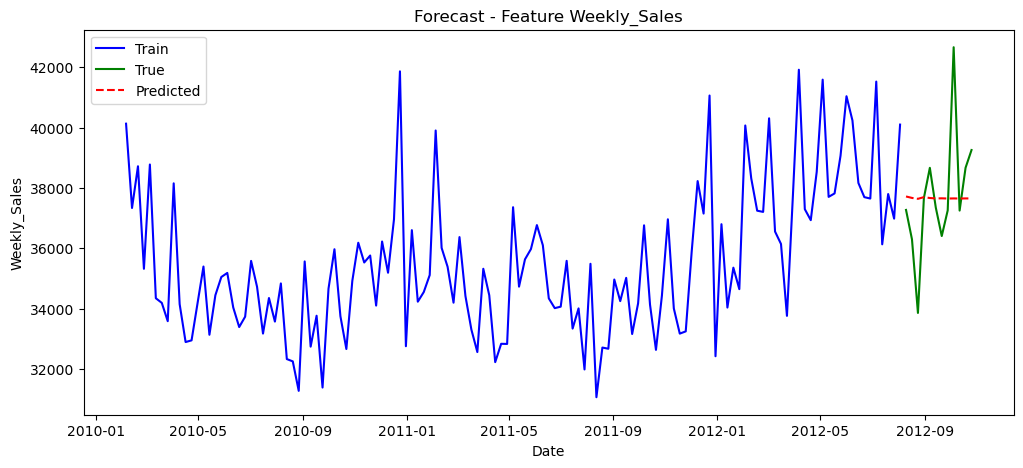

DTW distance (feature Weekly_Sales): 6935.8058


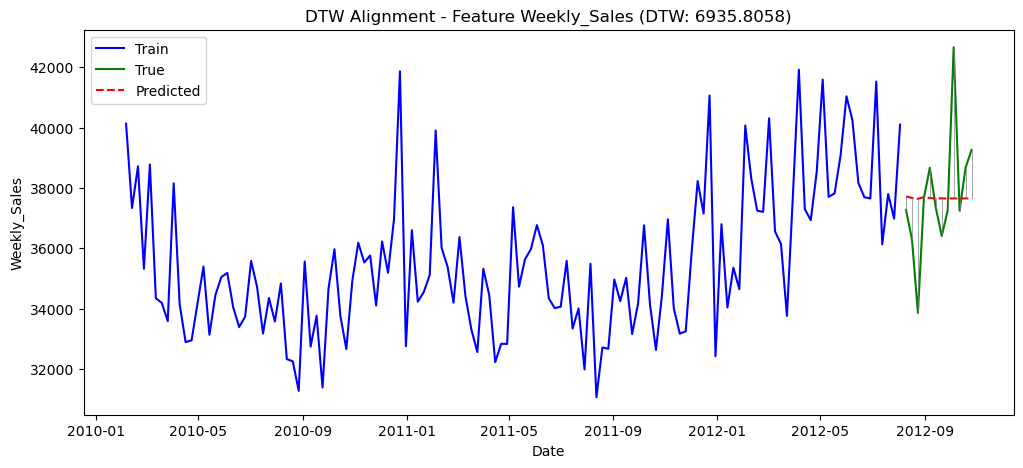

Recursive Results for CNN-LSTM: {'rmse': 4008783.5198161732, 'mae': 1384.4160217827891, 'mape': 0.03638525730390042, 'dtw': 6935.8058102713685}
✅ CNN-LSTM completed. Results saved to outputs\CNN-LSTM\no_window\recursive\data


In [63]:
train_forecast_model(
    model_type="CNN-LSTM",
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    train_dates=train_dates,
    test_dates=test_dates,
    scaler=scaler,
    features=features,
    predict_all=False,
    horizon=horizon,
    output_dir='outputs',
    use_gpu=True,
    model_kwargs={},
    fit_kwargs={
        "epochs": 200,
        "batch_size": 1,
        "validation_split": 0
    },
    target_only=True,
    feature_idx=0
)


Epoch 1/200
1/1 [==============================] - 0s 298ms/step - loss: 2.7930
Epoch 2/200
1/1 [==============================] - 0s 16ms/step - loss: 0.8281
Epoch 3/200
1/1 [==============================] - 0s 16ms/step - loss: 0.8146
Epoch 4/200
1/1 [==============================] - 0s 12ms/step - loss: 0.5216
Epoch 5/200
1/1 [==============================] - 0s 11ms/step - loss: 0.4327
Epoch 6/200
1/1 [==============================] - 0s 32ms/step - loss: 0.3707
Epoch 7/200
1/1 [==============================] - 0s 24ms/step - loss: 0.4023
Epoch 8/200
1/1 [==============================] - 0s 29ms/step - loss: 0.2985
Epoch 9/200
1/1 [==============================] - 0s 12ms/step - loss: 0.3239
Epoch 10/200
1/1 [==============================] - 0s 52ms/step - loss: 0.3384
Epoch 11/200
1/1 [==============================] - 0s 10ms/step - loss: 0.2787
Epoch 12/200
1/1 [==============================] - 0s 23ms/step - loss: 0.2715
Epoch 13/200
1/1 [==============================

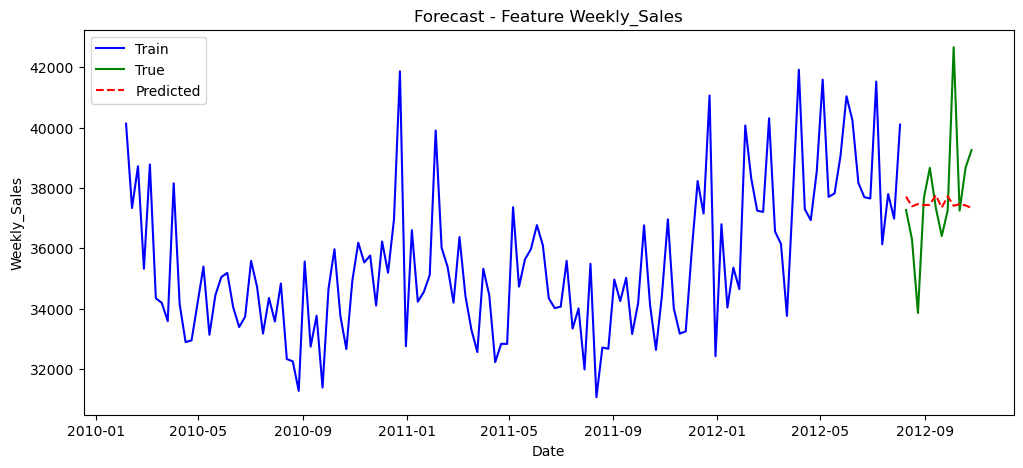

DTW distance (feature Weekly_Sales): 6746.0189


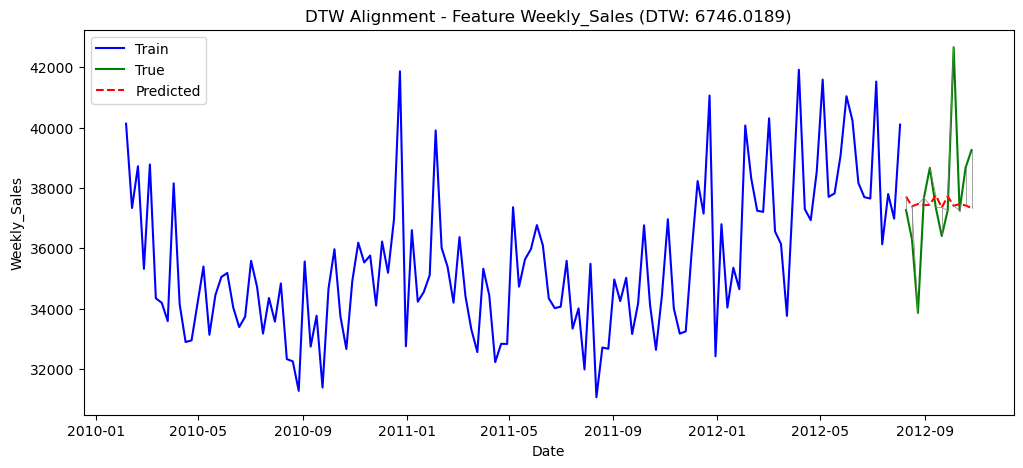

Recursive Results for NBEATS: {'rmse': 4181845.0915429364, 'mae': 1422.5675483819498, 'mape': 0.037189426497260966, 'dtw': 6746.01885220873}
✅ NBEATS completed. Results saved to outputs\NBEATS\no_window\recursive\data


In [64]:
train_forecast_model(
    model_type="NBEATS",
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    train_dates=train_dates,
    test_dates=test_dates,
    scaler=scaler,
    features=features,
    predict_all=False,
    horizon=horizon,
    output_dir='outputs',
    use_gpu=True,
    model_kwargs={},
    fit_kwargs={
        "epochs": 200,
        "batch_size": 1,
        "validation_split": 0
    },
    target_only=True,
    feature_idx=0
)


# Machine learning models

In [67]:

train_forecast_model(
    model_type="CNN",
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    scaler=scaler,
    features=features,
    predict_all=True,
    window_size=window_size,
    horizon=horizon,
    output_dir='outputs',
    normalize=True,
    use_gpu=True,
    model_kwargs={},        # <- CNN takes no extra args now
    fit_kwargs={            # <- This goes to model.fit()
        "epochs": 200,
        "batch_size": 8
    }
)


Epoch 1/100
6/6 [==============================] - 1s 31ms/step - loss: 0.7935 - val_loss: 2.0943
Epoch 2/100
6/6 [==============================] - 0s 12ms/step - loss: 0.7324 - val_loss: 2.1943
Epoch 3/100
6/6 [==============================] - 0s 12ms/step - loss: 0.6997 - val_loss: 2.3177
Epoch 4/100
6/6 [==============================] - 0s 10ms/step - loss: 0.6716 - val_loss: 2.4241
Epoch 5/100
6/6 [==============================] - 0s 10ms/step - loss: 0.6496 - val_loss: 2.5453
Epoch 6/100
6/6 [==============================] - 0s 11ms/step - loss: 0.6283 - val_loss: 2.6474
Epoch 7/100
6/6 [==============================] - 0s 10ms/step - loss: 0.6075 - val_loss: 2.7328
Epoch 8/100
6/6 [==============================] - 0s 10ms/step - loss: 0.5941 - val_loss: 2.7392
Epoch 9/100
6/6 [==============================] - 0s 10ms/step - loss: 0.5825 - val_loss: 2.7176
Epoch 10/100
6/6 [==============================] - 0s 10ms/step - loss: 0.5722 - val_loss: 2.7102
Epoch 11/100
1/1 [=

Epoch 1/100
6/6 [==============================] - 6s 69ms/step - loss: 0.7899 - val_loss: 2.1828
Epoch 2/100
6/6 [==============================] - 0s 12ms/step - loss: 0.7037 - val_loss: 2.3023
Epoch 3/100
6/6 [==============================] - 0s 11ms/step - loss: 0.6717 - val_loss: 2.3965
Epoch 4/100
6/6 [==============================] - 0s 11ms/step - loss: 0.6490 - val_loss: 2.4359
Epoch 5/100
6/6 [==============================] - 0s 11ms/step - loss: 0.6342 - val_loss: 2.4496
Epoch 6/100
6/6 [==============================] - 0s 11ms/step - loss: 0.6193 - val_loss: 2.4708
Epoch 7/100
6/6 [==============================] - 0s 11ms/step - loss: 0.6079 - val_loss: 2.4592
Epoch 8/100
6/6 [==============================] - 0s 10ms/step - loss: 0.5976 - val_loss: 2.4596
Epoch 9/100
6/6 [==============================] - 0s 11ms/step - loss: 0.5878 - val_loss: 2.4897
Epoch 10/100
6/6 [==============================] - 0s 11ms/step - loss: 0.5787 - val_loss: 2.5178
Epoch 11/100
1/1 [=

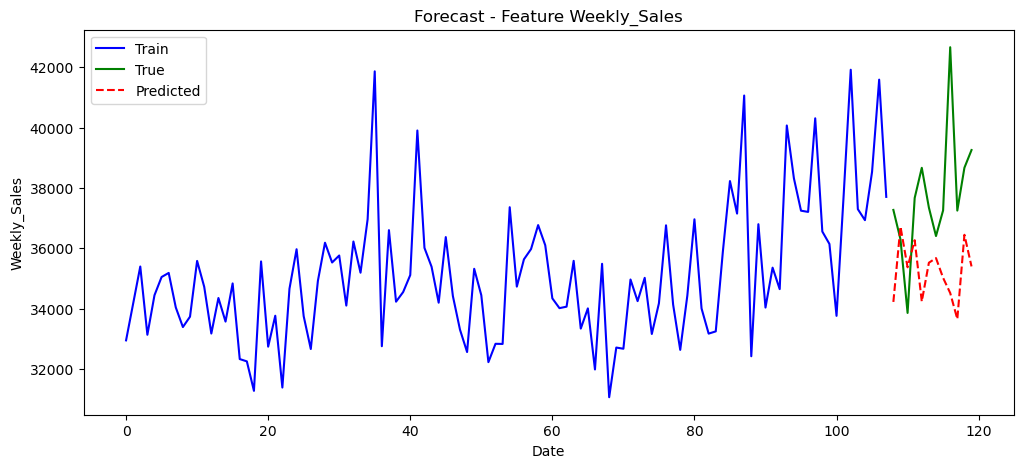

NameError: name 'TimeSeriesScalerMinMax' is not defined

In [36]:
# Train CNN
train_forecast_model(
    model_type="CNN",
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    train_dates=train_dates,
    test_dates=test_dates,
    scaler=scaler,
    features=features,
    predict_all=True,
    window_size=window_size,
    horizon=horizon,
    output_dir='outputs',
    normalize=True,
    use_gpu=True,
    model_kwargs={},  # CNN takes no extra args in __init__
    fit_kwargs={
        "epochs": 200,
        "batch_size": 8
    },
    target_only=True,     # Use True for only inverse-transforming the first feature (Weekly_Sales)
    feature_idx=0         # Index of the target column in features
)


In [68]:

train_forecast_model(
    model_type="RNN",
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    scaler=scaler,
    features=features,
    predict_all=True,
    window_size=window_size,
    horizon=horizon,
    output_dir='outputs',
    normalize=True,
    use_gpu=True,
    model_kwargs={},        # <- CNN takes no extra args now
    fit_kwargs={            # <- This goes to model.fit()
        "epochs": 200,
        "batch_size": 8
    }
)


Epoch 1/100
6/6 [==============================] - 1s 59ms/step - loss: 0.9973 - val_loss: 1.8153
Epoch 2/100
6/6 [==============================] - 0s 27ms/step - loss: 0.7797 - val_loss: 1.5364
Epoch 3/100
6/6 [==============================] - 0s 28ms/step - loss: 0.6726 - val_loss: 1.3995
Epoch 4/100
6/6 [==============================] - 0s 25ms/step - loss: 0.6138 - val_loss: 1.3147
Epoch 5/100
6/6 [==============================] - 0s 26ms/step - loss: 0.5723 - val_loss: 1.3015
Epoch 6/100
6/6 [==============================] - 0s 25ms/step - loss: 0.5443 - val_loss: 1.3598
Epoch 7/100
6/6 [==============================] - 0s 24ms/step - loss: 0.5232 - val_loss: 1.4454
Epoch 8/100
6/6 [==============================] - 0s 24ms/step - loss: 0.5045 - val_loss: 1.3994
Epoch 9/100
6/6 [==============================] - 0s 28ms/step - loss: 0.4869 - val_loss: 1.3825
Epoch 10/100
6/6 [==============================] - 0s 24ms/step - loss: 0.4721 - val_loss: 1.3909
Epoch 11/100
6/6 [=

In [69]:

train_forecast_model(
    model_type="GRU",
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    scaler=scaler,
    features=features,
    predict_all=True,
    window_size=window_size,
    horizon=horizon,
    output_dir='outputs',
    normalize=True,
    use_gpu=True,
    model_kwargs={},        # <- CNN takes no extra args now
    fit_kwargs={            # <- This goes to model.fit()
        "epochs": 200,
        "batch_size": 8
    }
)


Epoch 1/100
6/6 [==============================] - 3s 76ms/step - loss: 0.7905 - val_loss: 1.8955
Epoch 2/100
6/6 [==============================] - 0s 19ms/step - loss: 0.7150 - val_loss: 1.7056
Epoch 3/100
6/6 [==============================] - 0s 15ms/step - loss: 0.6638 - val_loss: 1.5455
Epoch 4/100
6/6 [==============================] - 0s 16ms/step - loss: 0.6311 - val_loss: 1.4268
Epoch 5/100
6/6 [==============================] - 0s 15ms/step - loss: 0.6076 - val_loss: 1.3563
Epoch 6/100
6/6 [==============================] - 0s 16ms/step - loss: 0.5955 - val_loss: 1.3364
Epoch 7/100
6/6 [==============================] - 0s 14ms/step - loss: 0.5847 - val_loss: 1.3424
Epoch 8/100
6/6 [==============================] - 0s 14ms/step - loss: 0.5730 - val_loss: 1.3488
Epoch 9/100
6/6 [==============================] - 0s 13ms/step - loss: 0.5642 - val_loss: 1.3701
Epoch 10/100
6/6 [==============================] - 0s 14ms/step - loss: 0.5552 - val_loss: 1.3781
Epoch 11/100
6/6 [=

In [70]:

train_forecast_model(
    model_type="LSTM",
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    scaler=scaler,
    features=features,
    predict_all=True,
    window_size=window_size,
    horizon=horizon,
    output_dir='outputs',
    normalize=True,
    use_gpu=True,
    model_kwargs={},        # <- CNN takes no extra args now
    fit_kwargs={            # <- This goes to model.fit()
        "epochs": 200,
        "batch_size": 8
    }
)


Epoch 1/100
6/6 [==============================] - 2s 82ms/step - loss: 0.7952 - val_loss: 1.7826
Epoch 2/100
6/6 [==============================] - 0s 16ms/step - loss: 0.7292 - val_loss: 1.7065
Epoch 3/100
6/6 [==============================] - 0s 14ms/step - loss: 0.6907 - val_loss: 1.6410
Epoch 4/100
6/6 [==============================] - 0s 15ms/step - loss: 0.6624 - val_loss: 1.5936
Epoch 5/100
6/6 [==============================] - 0s 15ms/step - loss: 0.6440 - val_loss: 1.5665
Epoch 6/100
6/6 [==============================] - 0s 15ms/step - loss: 0.6270 - val_loss: 1.5636
Epoch 7/100
6/6 [==============================] - 0s 14ms/step - loss: 0.6139 - val_loss: 1.5850
Epoch 8/100
6/6 [==============================] - 0s 15ms/step - loss: 0.5983 - val_loss: 1.6062
Epoch 9/100
6/6 [==============================] - 0s 14ms/step - loss: 0.5858 - val_loss: 1.6307
Epoch 10/100
6/6 [==============================] - 0s 16ms/step - loss: 0.5729 - val_loss: 1.6400
Epoch 11/100
6/6 [=

In [71]:

train_forecast_model(
    model_type="FCN",
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    scaler=scaler,
    features=features,
    predict_all=True,
    window_size=window_size,
    horizon=horizon,
    output_dir='outputs',
    normalize=True,
    use_gpu=True,
    model_kwargs={},        # <- CNN takes no extra args now
    fit_kwargs={            # <- This goes to model.fit()
        "epochs": 200,
        "batch_size": 8
    }
)


Epoch 1/100
6/6 [==============================] - 1s 52ms/step - loss: 0.6873 - val_loss: 3.8307
Epoch 2/100
6/6 [==============================] - 0s 12ms/step - loss: 0.6078 - val_loss: 3.2794
Epoch 3/100
6/6 [==============================] - 0s 10ms/step - loss: 0.5715 - val_loss: 3.7121
Epoch 4/100
6/6 [==============================] - 0s 11ms/step - loss: 0.5511 - val_loss: 3.4807
Epoch 5/100
6/6 [==============================] - 0s 12ms/step - loss: 0.5372 - val_loss: 3.1252
Epoch 6/100
6/6 [==============================] - 0s 11ms/step - loss: 0.5157 - val_loss: 3.4642
Epoch 7/100
6/6 [==============================] - 0s 10ms/step - loss: 0.5010 - val_loss: 3.1437
Epoch 8/100
6/6 [==============================] - 0s 11ms/step - loss: 0.4912 - val_loss: 3.0811
Epoch 9/100
6/6 [==============================] - 0s 11ms/step - loss: 0.4866 - val_loss: 3.1468
Epoch 10/100
6/6 [==============================] - 0s 11ms/step - loss: 0.4730 - val_loss: 3.1027
Epoch 11/100
6/6 [=

In [72]:

train_forecast_model(
    model_type="ANN",
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    scaler=scaler,
    features=features,
    predict_all=True,
    window_size=window_size,
    horizon=horizon,
    output_dir='outputs',
    normalize=True,
    use_gpu=True,
    model_kwargs={},        # <- CNN takes no extra args now
    fit_kwargs={            # <- This goes to model.fit()
        "epochs": 200,
        "batch_size": 8
    }
)


Epoch 1/100
6/6 [==============================] - 0s 26ms/step - loss: 0.7296 - val_loss: 2.5137
Epoch 2/100
6/6 [==============================] - 0s 9ms/step - loss: 0.5992 - val_loss: 2.6692
Epoch 3/100
6/6 [==============================] - 0s 8ms/step - loss: 0.5481 - val_loss: 2.8229
Epoch 4/100
6/6 [==============================] - 0s 9ms/step - loss: 0.5065 - val_loss: 2.9240
Epoch 5/100
6/6 [==============================] - 0s 9ms/step - loss: 0.4780 - val_loss: 2.9913
Epoch 6/100
6/6 [==============================] - 0s 9ms/step - loss: 0.4548 - val_loss: 2.9871
Epoch 7/100
6/6 [==============================] - 0s 9ms/step - loss: 0.4331 - val_loss: 2.9906
Epoch 8/100
6/6 [==============================] - 0s 9ms/step - loss: 0.4157 - val_loss: 2.9985
Epoch 9/100
6/6 [==============================] - 0s 8ms/step - loss: 0.4002 - val_loss: 3.0194
Epoch 10/100
6/6 [==============================] - 0s 9ms/step - loss: 0.3853 - val_loss: 3.0228
Epoch 11/100
1/1 [==========

In [74]:

train_forecast_model(
    model_type="CNN-LSTN",
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    scaler=scaler,
    features=features,
    predict_all=True,
    window_size=window_size,
    horizon=horizon,
    output_dir='outputs',
    normalize=True,
    use_gpu=True,
    model_kwargs={},        # <- CNN takes no extra args now
    fit_kwargs={            # <- This goes to model.fit()
        "epochs": 200,
        "batch_size": 8
    }
)


Epoch 1/100
6/6 [==============================] - 2s 89ms/step - loss: 0.7297 - val_loss: 2.1972
Epoch 2/100
6/6 [==============================] - 0s 16ms/step - loss: 0.6654 - val_loss: 2.4282
Epoch 3/100
6/6 [==============================] - 0s 15ms/step - loss: 0.6308 - val_loss: 2.5687
Epoch 4/100
6/6 [==============================] - 0s 15ms/step - loss: 0.6157 - val_loss: 2.6237
Epoch 5/100
6/6 [==============================] - 0s 15ms/step - loss: 0.6055 - val_loss: 2.5990
Epoch 6/100
6/6 [==============================] - 0s 15ms/step - loss: 0.5907 - val_loss: 2.5527
Epoch 7/100
6/6 [==============================] - 0s 15ms/step - loss: 0.5781 - val_loss: 2.5472
Epoch 8/100
6/6 [==============================] - 0s 15ms/step - loss: 0.5638 - val_loss: 2.5460
Epoch 9/100
6/6 [==============================] - 0s 16ms/step - loss: 0.5518 - val_loss: 2.5462
Epoch 10/100
6/6 [==============================] - 0s 15ms/step - loss: 0.5402 - val_loss: 2.5053
Epoch 11/100
1/1 [=

In [75]:

train_forecast_model(
    model_type="NBEATS",
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    scaler=scaler,
    features=features,
    predict_all=True,
    window_size=window_size,
    horizon=horizon,
    output_dir='outputs',
    normalize=True,
    use_gpu=True,
    model_kwargs={},        # <- CNN takes no extra args now
    fit_kwargs={            # <- This goes to model.fit()
        "epochs": 200,
        "batch_size": 8
    }
)


Epoch 1/100
6/6 [==============================] - 1s 38ms/step - loss: 0.6949 - val_loss: 2.9776
Epoch 2/100
6/6 [==============================] - 0s 17ms/step - loss: 0.5366 - val_loss: 2.8427
Epoch 3/100
6/6 [==============================] - 0s 17ms/step - loss: 0.4768 - val_loss: 2.8313
Epoch 4/100
6/6 [==============================] - 0s 17ms/step - loss: 0.4312 - val_loss: 2.4150
Epoch 5/100
6/6 [==============================] - 0s 14ms/step - loss: 0.3842 - val_loss: 2.5856
Epoch 6/100
6/6 [==============================] - 0s 16ms/step - loss: 0.3462 - val_loss: 2.2216
Epoch 7/100
6/6 [==============================] - 0s 14ms/step - loss: 0.2963 - val_loss: 2.3819
Epoch 8/100
6/6 [==============================] - 0s 15ms/step - loss: 0.2522 - val_loss: 2.3262
Epoch 9/100
6/6 [==============================] - 0s 15ms/step - loss: 0.2140 - val_loss: 2.3542
Epoch 10/100
6/6 [==============================] - 0s 15ms/step - loss: 0.1834 - val_loss: 2.3556
Epoch 11/100
6/6 [=

In [ ]:
# Example: ARIMA
train_forecast_model("ARIMA",
    X_train=weekly_sales_series[:train_size], X_test=weekly_sales_series[train_size:], 
    y_train=None, y_test=None, scaler=None, features=None,
    predict_all=True, recursive=False,
    order=(2,1,2), target_column='Weekly_Sales')

# Example: SARIMA
train_forecast_model("SARIMA",
    X_train=weekly_sales_series[:train_size], X_test=weekly_sales_series[train_size:], 
    y_train=None, y_test=None, scaler=None, features=None,
    predict_all=True, recursive=False,
    order=(1,1,1), seasonal_order=(1,1,1,12), target_column='Weekly_Sales')

# Example: SARIMAX with Exogenous Variables
exog_train = train_df[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']].values
exog_test = test_df[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']].values

train_forecast_model("SARIMAX",
    X_train=train_df[['Weekly_Sales']], X_test=test_df[['Weekly_Sales']],
    y_train=None, y_test=None, scaler=None, features=None,
    predict_all=True, recursive=False,
    order=(2,1,2), seasonal_order=(1,1,1,12),
    exog_train=exog_train, exog_test=exog_test, target_column='Weekly_Sales')


In [59]:
import sklearn
sklearn.__version__

'1.6.1'

In [61]:
help(mean_squared_error)

Help on function mean_squared_error in module sklearn.metrics._regression:

mean_squared_error(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average')
    Mean squared error regression loss.
    
    Read more in the :ref:`User Guide <mean_squared_error>`.
    
    Parameters
    ----------
    y_true : array-like of shape (n_samples,) or (n_samples, n_outputs)
        Ground truth (correct) target values.
    
    y_pred : array-like of shape (n_samples,) or (n_samples, n_outputs)
        Estimated target values.
    
    sample_weight : array-like of shape (n_samples,), default=None
        Sample weights.
    
    multioutput : {'raw_values', 'uniform_average'} or array-like of shape             (n_outputs,), default='uniform_average'
        Defines aggregating of multiple output values.
        Array-like value defines weights used to average errors.
    
        'raw_values' :
            Returns a full set of errors in case of multioutput input.
    
        'unifo